In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [ ]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
!pip install pycocotools
from pycocotools.coco import COCO

In [ ]:
!curl -L "https://public.roboflow.com/ds/SA93trWNMD?key=X7nziDAaCd" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   901  100   901    0     0   1398      0 --:--:-- --:--:-- --:--:--  1396
100 68.0M  100 68.0M    0     0  13.4M      0  0:00:05  0:00:05 --:--:-- 17.0M
Archive:  roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
   creating: test/
 extracting: test/IMG_2289_jpeg_jpg.rf.fe2a7a149e7b11f2313f5a7b30386e85.jpg  
 extracting: test/IMG_2301_jpeg_jpg.rf.2c19ae5efbd1f8611b5578125f001695.jpg  
 extracting: test/IMG_2319_jpeg_jpg.rf.6e20bf97d17b74a8948aa48776c40454.jpg  
 extracting: test/IMG_2347_jpeg_jpg.rf.7c71ac4b9301eb358cd4a832844dedcb.jpg  
 extracting: test/IMG_2354_jpeg_jpg.rf.396e872c7fb0a95e911806986995ee7a.jpg  
 extracting: test/IMG_2371_jpeg_jpg.rf.54505f60b6706da151c164188c305849.jpg  
 extracting: test/IMG_2379_jpeg_jpg.rf.7dc3160c937072d26d4624c6c48e904d.jpg  
 extracting: test/IM

In [ ]:
import json

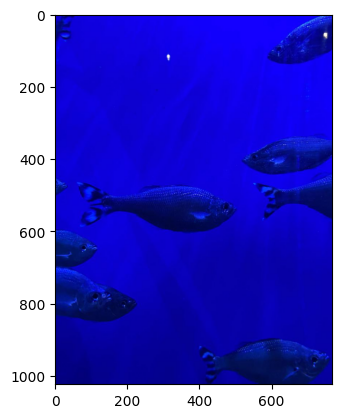

In [ ]:
img = cv2.cvtColor(cv2.imread('/content/train/IMG_2275_jpeg_jpg.rf.66355520a49ba7fb7082052f7ca6fee0.jpg'), cv2.COLOR_BGR2RGB)
plt.imshow(img)

203
[[0, 701, 231, 153], [58, 457, 446, 150], [581, 1, 187, 141], [517, 324, 251, 124], [545, 452, 222, 119], [0, 593, 124, 114], [0, 0, 57, 99], [395, 895, 373, 128]]
[1, 1, 1, 1, 1, 1, 1, 1]
['fish', 'fish', 'fish', 'fish', 'fish', 'fish', 'fish', 'fish']


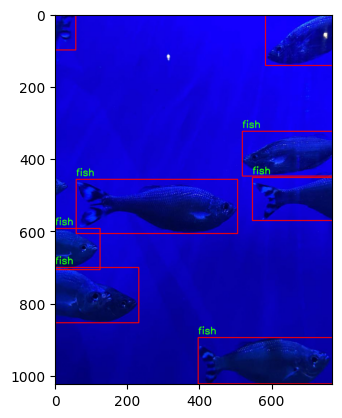

In [ ]:
img_path = 'IMG_2275_jpeg_jpg.rf.66355520a49ba7fb7082052f7ca6fee0.jpg'


train_ann_path = '/content/train/_annotations.coco.json'
file = open(train_ann_path)
data = json.load(file)
img_id = 0

for i in data['images']:
    if i['file_name'] == img_path:
        img_id = i['id']
        break

print(img_id)
bbox = []
category_id = []

for i in data['annotations']:
    if i['image_id'] == img_id:
        bbox.append(i['bbox'])
        category_id.append(i['category_id'])

print(bbox)
print(category_id)

categories = []

for i in data['categories']:
  for j in category_id:
    if i['id'] == j:
      categories.append(i['name'])

print(categories)

n = 0
for box in bbox:
    cv2.rectangle(img, (int(box[0]), int(box[1])), (int(box[0] + box[2]), int(box[1] + box[3])), (255, 0, 0), 2)
    cv2.putText(img, categories[n], (int(box[0]), int(box[1])-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
    n += 1
plt.imshow(img)
plt.show()


In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 96.4MB/s]


In [ ]:
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
import albumentations as A
def get_transforms(train = False):  #train = True
  if train:
    transform = A.Compose([
        A.Resize(600, 600),
        A.HorizontalFlip(p= 0.3),
        A.VerticalFlip(p= 0.3),
        A.RandomBrightnessContrast(p= 0.1),
        A.ColorJitter(p=0.1),
        ToTensorV2()
    ], bbox_params=A.BboxParams(format='coco'))
  else:
    transform = A.Compose([
        A.Resize(600, 600),
        ToTensorV2()
    ], bbox_params=A.BboxParams(format='coco'))
  return transform


In [ ]:
from torchvision import datasets, models
import os
import copy
class AquariumDetection(datasets.VisionDataset):
    def __init__(self, root, split= 'train', transform= None, target_transform=None, transforms= None):
        super(AquariumDetection, self).__init__(root, transforms, transform, target_transform)
        self.split = split # train, valid, test
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json"))
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]

    def _load_image(self, id: int):
      path = self.coco.loadImgs(id)[0]['file_name']
      image = cv2.imread(os.path.join(self.root, self.split, path))
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      return image

    def _load_target(self, id: int):
      return self.coco.loadAnns(self.coco.getAnnIds(id))

    def __getitem__(self, index):
      id = self.ids[index]
      image = self._load_image(id)
      target = self._load_target(id)
      target = copy.deepcopy(self._load_target(id))
      boxes = [t['bbox'] + [t['category_id']] for t in target]
      if self.transforms is not None:
        transformed = self.transforms(image=image, bboxes=boxes)
        image = transformed['image']
        boxes = transformed['bboxes']

      new_boxes = []
      #box == x, y, w, h
      for box in boxes:
        xmin = box[0]
        xmax = xmin + box[2]
        ymin = box[1]
        ymax = ymin + box[3]
        new_boxes.append([xmin, ymin, xmax, ymax])

      boxes = torch.tensor(new_boxes, dtype=torch.float32)

      targ = {}
      targ['boxes'] = boxes
      targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype= torch.int64)
      targ['image_id'] = torch.tensor([t['image_id'] for t in target])
      targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
      targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype= torch.int64)
      return image.div(255), targ

    def __len__(self):
      return len(self.ids)


In [ ]:
dataset_path = '/content'

In [ ]:
coco = COCO(os.path.join(dataset_path, 'train', "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
print(categories[2]['name'])

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
jellyfish


In [ ]:
classes = [i[1]['name'] for i in categories.items()]
print(classes)

['creatures', 'fish', 'jellyfish', 'penguin', 'puffin', 'shark', 'starfish', 'stingray']


In [ ]:
train_dataset = AquariumDetection(root = dataset_path, split='train', transforms=get_transforms(train=True))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


<ipython-input-63-960b9441c576>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)


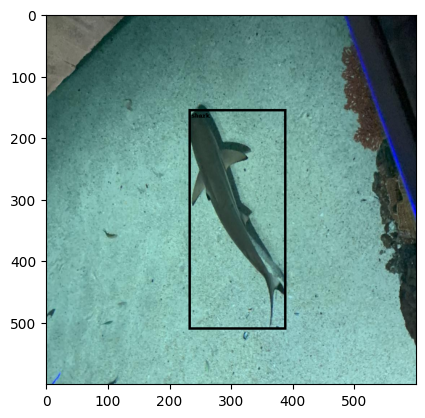

In [ ]:
from torchvision.utils import draw_bounding_boxes
sample = train_dataset[20]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width = 4).permute(1,2,0))

In [ ]:
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained = True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
def collate_fn(batch):
  return tuple(zip(*batch))
  # batch = [(i1, l1), (i2, l2), ... , (in, ln)]
  # *batch = (i1, l1), (i2, l2), ..., (in, ln)
  # zip = (i1, i2, ... , in), (l1, l2, ..., ln)
  # tuple ((i1, i2, ... , in), (l1, l2, ..., ln))

In [ ]:
from torch.utils.data import DataLoader, sampler, random_split, Dataset
train_loader = DataLoader(train_dataset, batch_size = 4, shuffle=True, collate_fn=collate_fn)

In [ ]:
images, targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
# print(targets[0])
output = model(images, targets)

In [ ]:
output
output_dict_append = {k: v.item() for k, v in output.items()}
output_dict_append
output.items()

dict_items([('loss_classifier', tensor(2.0305, grad_fn=<NllLossBackward0>)), ('loss_box_reg', tensor(0.5802, grad_fn=<DivBackward0>)), ('loss_objectness', tensor(0.3558, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)), ('loss_rpn_box_reg', tensor(0.0605, grad_fn=<DivBackward0>))])

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
model = model.to(device)

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)

In [ ]:
import sys

In [95]:
from tqdm import tqdm
import math
import pandas as pd
def train_one_epoch(model, optimizer, loader, device, epoch):
  model.to(device)
  model.train()

  all_losses = []
  all_losses_dict = []
  #for every 4 samples (batch = 4)
  for images, targets in tqdm(loader):
    images = list(image.to(device) for image in images)
    targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
    loss_dict = model(images, targets)
    losses = sum(loss for loss in loss_dict.values())
    loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
    loss_value = losses.item()

    all_losses.append(loss_value)
    all_losses_dict.append(loss_dict_append)

    if not math.isfinite(loss_value):
      print(f"Loss is {loss_value}, stopping training")
      print(loss_dict_append)
      sys.exit(1)

    optimizer.zero_grad()
    losses.backward()
    optimizer.step()

    # all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
    # print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
    #     epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
    #     all_losses_dict['loss_classifier'].mean(),
    #     all_losses_dict['loss_box_reg'].mean(),
    #     all_losses_dict['loss_rpn_box_reg'].mean(),
    #     all_losses_dict['loss_objectness'].mean()
    # ))
    loss_classifier = 0
    loss_box = 0
    loss_rpn_box = 0
    loss_object = 0
    for i in range(len(all_losses_dict)):
      loss_classifier += all_losses_dict[i]['loss_classifier']
      loss_box += all_losses_dict[i]['loss_box_reg']
      loss_rpn_box += all_losses_dict[i]['loss_rpn_box_reg']
      loss_object += all_losses_dict[i]['loss_objectness']
    loss_classifier = loss_classifier / len(all_losses_dict)
    loss_box = loss_box / len(all_losses_dict)
    loss_rpn_box = loss_rpn_box / len(all_losses_dict)
    loss_object = loss_object / len(all_losses_dict)
    print(f'loss_classifier = {loss_classifier}', end=" ")
    print(f'loss_box = {loss_box}', end= " ")
    print(f'loss_rpn_box = {loss_rpn_box}', end = " ")
    print(f'loss_object = {loss_object})')

In [96]:
num_epochs = 10

for epoch in range(num_epochs):
  print(f'Epoch {epoch + 1}/ {num_epochs}')
  train_one_epoch(model, optimizer, train_loader, device, epoch)

Epoch 1/ 10


  0%|          | 0/112 [00:00<?, ?it/s]

loss_classifier = 0.2583499848842621 loss_box = 0.410001277923584 

<ipython-input-95-f1f326eacfbc>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
  2%|▏         | 2/112 [00:00<00:20,  5.29it/s]

loss_rpn_box = 0.022918444126844406 loss_object = 0.05184127762913704)
loss_classifier = 0.26590877771377563 loss_box = 0.2732260301709175 loss_rpn_box = 0.013357811607420444 loss_object = 0.03763362020254135)


  4%|▎         | 4/112 [00:00<00:17,  6.04it/s]

loss_classifier = 0.2465993861357371 loss_box = 0.261696919798851 loss_rpn_box = 0.014134522527456284 loss_object = 0.04477161169052124)
loss_classifier = 0.2616667300462723 loss_box = 0.2878395728766918 loss_rpn_box = 0.019111583940684795 loss_object = 0.04681926127523184)


  5%|▌         | 6/112 [00:00<00:16,  6.40it/s]

loss_classifier = 0.265463775396347 loss_box = 0.316150364279747 loss_rpn_box = 0.02506861761212349 loss_object = 0.049814559519290924)
loss_classifier = 0.2825637658437093 loss_box = 0.3234307790795962 loss_rpn_box = 0.02516913351913293 loss_object = 0.04837419341007868)


  7%|▋         | 8/112 [00:01<00:16,  6.44it/s]

loss_classifier = 0.2776990809610912 loss_box = 0.32002622953483034 loss_rpn_box = 0.023718139954975674 loss_object = 0.0459588851247515)
loss_classifier = 0.2788796257227659 loss_box = 0.3345449436455965 loss_rpn_box = 0.02386844321154058 loss_object = 0.04245078796520829)


  9%|▉         | 10/112 [00:01<00:15,  6.56it/s]

loss_classifier = 0.2873854918612374 loss_box = 0.34018520679738784 loss_rpn_box = 0.022911285153693624 loss_object = 0.039647423144843846)
loss_classifier = 0.27099114283919334 loss_box = 0.32260883450508115 loss_rpn_box = 0.020932358922436833 loss_object = 0.03679425762966275)


 11%|█         | 12/112 [00:01<00:15,  6.63it/s]

loss_classifier = 0.28881298073313455 loss_box = 0.3314094678922133 loss_rpn_box = 0.020478308243169027 loss_object = 0.03754523879086429)
loss_classifier = 0.2795011556396882 loss_box = 0.3370688234766324 loss_rpn_box = 0.019457894881876808 loss_object = 0.035429899503166475)


 12%|█▎        | 14/112 [00:02<00:15,  6.48it/s]

loss_classifier = 0.27443476766347885 loss_box = 0.3373618034216074 loss_rpn_box = 0.01995347673073411 loss_object = 0.03459621657832311)
loss_classifier = 0.2750300887439932 loss_box = 0.34463354093687876 loss_rpn_box = 0.020957919669204524 loss_object = 0.03604092801521931)


 14%|█▍        | 16/112 [00:02<00:14,  6.42it/s]

loss_classifier = 0.28369007259607315 loss_box = 0.3499677896499634 loss_rpn_box = 0.021168448310345412 loss_object = 0.03522334216783444)
loss_classifier = 0.28794196201488376 loss_box = 0.34987947903573513 loss_rpn_box = 0.022429177799494937 loss_object = 0.03546449955319986)


 16%|█▌        | 18/112 [00:02<00:14,  6.28it/s]

loss_classifier = 0.28598888437537584 loss_box = 0.3487231170429903 loss_rpn_box = 0.022168778567848837 loss_object = 0.036156052997445357)
loss_classifier = 0.2865862345529927 loss_box = 0.3546826028161579 loss_rpn_box = 0.02276553381751809 loss_object = 0.03594689955934882)


 18%|█▊        | 20/112 [00:03<00:14,  6.33it/s]

loss_classifier = 0.28032941606483963 loss_box = 0.3507242234129655 loss_rpn_box = 0.022231009666268762 loss_object = 0.03542675778857971)
loss_classifier = 0.2846364665776491 loss_box = 0.3555166035890579 loss_rpn_box = 0.02276095359120518 loss_object = 0.035284818476065995)


 20%|█▉        | 22/112 [00:03<00:13,  6.44it/s]

loss_classifier = 0.2858770166834195 loss_box = 0.3602802412850516 loss_rpn_box = 0.022255171467328354 loss_object = 0.03458924179098436)
loss_classifier = 0.2851359983059493 loss_box = 0.36484243923967535 loss_rpn_box = 0.02216372412460094 loss_object = 0.03421025710519065)


 21%|██▏       | 24/112 [00:03<00:13,  6.30it/s]

loss_classifier = 0.2824783360828524 loss_box = 0.36283712153849396 loss_rpn_box = 0.02204308264038485 loss_object = 0.03416123407204514)
loss_classifier = 0.2796574058011174 loss_box = 0.3670288758973281 loss_rpn_box = 0.022121022707627464 loss_object = 0.03499628483162572)


 23%|██▎       | 26/112 [00:04<00:13,  6.24it/s]

loss_classifier = 0.2841290077567101 loss_box = 0.3750046956539154 loss_rpn_box = 0.022337662000209094 loss_object = 0.034953304119408134)
loss_classifier = 0.28638704092456746 loss_box = 0.3780357321867576 loss_rpn_box = 0.022717972948717382 loss_object = 0.03507635559743413)


 25%|██▌       | 28/112 [00:04<00:13,  6.28it/s]

loss_classifier = 0.28169959590390875 loss_box = 0.37248948050869835 loss_rpn_box = 0.02251410989642695 loss_object = 0.03426850062829477)
loss_classifier = 0.2803035934588739 loss_box = 0.37332288761224064 loss_rpn_box = 0.022106176591478288 loss_object = 0.0340910479426384)


 27%|██▋       | 30/112 [00:04<00:13,  6.28it/s]

loss_classifier = 0.27630872073872337 loss_box = 0.3673120192412672 loss_rpn_box = 0.021867767634705222 loss_object = 0.03349448123882557)
loss_classifier = 0.2754380238552888 loss_box = 0.36765477856000267 loss_rpn_box = 0.022918439547841746 loss_object = 0.03476192876696586)


 29%|██▊       | 32/112 [00:05<00:12,  6.39it/s]

loss_classifier = 0.28007678375128775 loss_box = 0.36807092255161655 loss_rpn_box = 0.02272648882541445 loss_object = 0.03452166284043943)
loss_classifier = 0.2797021570149809 loss_box = 0.36766938026994467 loss_rpn_box = 0.022756302627385594 loss_object = 0.034389352484140545)


 30%|███       | 34/112 [00:05<00:12,  6.35it/s]

loss_classifier = 0.27867397598244925 loss_box = 0.3659663444215601 loss_rpn_box = 0.023719535308015165 loss_object = 0.03515940684486519)
loss_classifier = 0.2787021768881994 loss_box = 0.36722590029239655 loss_rpn_box = 0.023883031201822794 loss_object = 0.034968004288042295)


 32%|███▏      | 36/112 [00:05<00:11,  6.38it/s]

loss_classifier = 0.28219708736453736 loss_box = 0.3657378196716309 loss_rpn_box = 0.023647400005055327 loss_object = 0.03597667557852609)
loss_classifier = 0.2807279881089926 loss_box = 0.3656671651535564 loss_rpn_box = 0.02381494120022075 loss_object = 0.03600563026136822)


 34%|███▍      | 38/112 [00:06<00:11,  6.23it/s]

loss_classifier = 0.27666779204800324 loss_box = 0.3600974211821685 loss_rpn_box = 0.023359395664285968 loss_object = 0.03565964888076525)
loss_classifier = 0.2780534623092727 loss_box = 0.3631855233719474 loss_rpn_box = 0.024320935536372035 loss_object = 0.03719740870751833)


 36%|███▌      | 40/112 [00:06<00:11,  6.31it/s]

loss_classifier = 0.2763515789157305 loss_box = 0.364923731638835 loss_rpn_box = 0.02386094658420636 loss_object = 0.03674194694329531)
loss_classifier = 0.2742894360795617 loss_box = 0.3644023329019547 loss_rpn_box = 0.023624618421308696 loss_object = 0.036567303957417606)


 38%|███▊      | 42/112 [00:06<00:10,  6.37it/s]

loss_classifier = 0.2723617911702249 loss_box = 0.3630579106691407 loss_rpn_box = 0.02336929193357142 loss_object = 0.03641723832342683)
loss_classifier = 0.2718923987732047 loss_box = 0.3653923748504548 loss_rpn_box = 0.023104740129340263 loss_object = 0.035926920406165574)


 39%|███▉      | 44/112 [00:06<00:10,  6.36it/s]

loss_classifier = 0.27441458802583607 loss_box = 0.36670182541359303 loss_rpn_box = 0.02327256493790205 loss_object = 0.035878596610801165)
loss_classifier = 0.27351267280226405 loss_box = 0.3656473220749335 loss_rpn_box = 0.02312976181168448 loss_object = 0.035788202319632874)


 41%|████      | 46/112 [00:07<00:10,  6.25it/s]

loss_classifier = 0.2737902315126525 loss_box = 0.3661998126241896 loss_rpn_box = 0.023604056984186172 loss_object = 0.036066407793098026)
loss_classifier = 0.27731913765487465 loss_box = 0.3675852638223897 loss_rpn_box = 0.023563299409073334 loss_object = 0.03752528438749521)


 43%|████▎     | 48/112 [00:07<00:10,  6.33it/s]

loss_classifier = 0.27811198586479147 loss_box = 0.3695664196572405 loss_rpn_box = 0.02343336223287785 loss_object = 0.03755662352480787)
loss_classifier = 0.2774037524747352 loss_box = 0.3695134489486615 loss_rpn_box = 0.023253339420383174 loss_object = 0.03715111132866392)


 45%|████▍     | 50/112 [00:07<00:09,  6.23it/s]

loss_classifier = 0.275204494443475 loss_box = 0.36773494007636087 loss_rpn_box = 0.02299935750815333 loss_object = 0.03682453538842347)
loss_classifier = 0.2763864018023014 loss_box = 0.37031718313694 loss_rpn_box = 0.023916185051202774 loss_object = 0.037546635307371616)


 46%|████▋     | 52/112 [00:08<00:09,  6.21it/s]

loss_classifier = 0.2767080631034047 loss_box = 0.3716399728083143 loss_rpn_box = 0.024209827038587307 loss_object = 0.03790947871611399)
loss_classifier = 0.27588546405044884 loss_box = 0.37116458037724864 loss_rpn_box = 0.023922964357412778 loss_object = 0.03775528205845218)


 48%|████▊     | 54/112 [00:08<00:09,  6.38it/s]

loss_classifier = 0.27396957084255397 loss_box = 0.36805879141924513 loss_rpn_box = 0.0235681678080615 loss_object = 0.03763064028660081)
loss_classifier = 0.27330684537688893 loss_box = 0.3658134843464251 loss_rpn_box = 0.023514021067293705 loss_object = 0.03735694541009488)


 50%|█████     | 56/112 [00:08<00:08,  6.62it/s]

loss_classifier = 0.2732426739551804 loss_box = 0.3664210969751531 loss_rpn_box = 0.02336609387262301 loss_object = 0.03690302819013595)
loss_classifier = 0.2738292253177081 loss_box = 0.36573947380696026 loss_rpn_box = 0.023492665961384773 loss_object = 0.03732488211244345)


 52%|█████▏    | 58/112 [00:09<00:08,  6.50it/s]

loss_classifier = 0.2731297799108321 loss_box = 0.36604073643684387 loss_rpn_box = 0.02354951830286729 loss_object = 0.037327204879961516)
loss_classifier = 0.2727899493585373 loss_box = 0.36581750214099884 loss_rpn_box = 0.023714581825609864 loss_object = 0.03722183387084254)


 54%|█████▎    | 60/112 [00:09<00:08,  6.38it/s]

loss_classifier = 0.2716655156622499 loss_box = 0.3656247424877296 loss_rpn_box = 0.02352623126895751 loss_object = 0.03690986111128734)
loss_classifier = 0.2707175107051929 loss_box = 0.36448830415805183 loss_rpn_box = 0.02382216810559233 loss_object = 0.0368964273793002)


 55%|█████▌    | 62/112 [00:09<00:07,  6.28it/s]

loss_classifier = 0.27147187622355634 loss_box = 0.3629400285541034 loss_rpn_box = 0.02411296343827834 loss_object = 0.03718249490637271)
loss_classifier = 0.2713906799833621 loss_box = 0.3624180915855592 loss_rpn_box = 0.024418582028198625 loss_object = 0.037557384810380394)


 57%|█████▋    | 64/112 [00:10<00:07,  6.44it/s]

loss_classifier = 0.2720887179649065 loss_box = 0.36019262363986365 loss_rpn_box = 0.02410227848246457 loss_object = 0.03726332253288655)
loss_classifier = 0.2720114524709061 loss_box = 0.36116491234861314 loss_rpn_box = 0.023880061417003162 loss_object = 0.0368513362336671)


 59%|█████▉    | 66/112 [00:10<00:07,  6.35it/s]

loss_classifier = 0.271285013625255 loss_box = 0.3619116679980205 loss_rpn_box = 0.024021616477805836 loss_object = 0.0368379019630643)
loss_classifier = 0.2726602835411375 loss_box = 0.3603183353940646 loss_rpn_box = 0.02383283388829141 loss_object = 0.03642753236503764)


 61%|██████    | 68/112 [00:10<00:07,  6.21it/s]

loss_classifier = 0.2730230267590551 loss_box = 0.361692211743611 loss_rpn_box = 0.024222086211527463 loss_object = 0.03680910599598689)
loss_classifier = 0.2718836797730011 loss_box = 0.3602929546990815 loss_rpn_box = 0.0243583876393078 loss_object = 0.03662598602857221)


 62%|██████▎   | 70/112 [00:11<00:06,  6.19it/s]

loss_classifier = 0.27177325938490854 loss_box = 0.3610491832529289 loss_rpn_box = 0.024624932543847008 loss_object = 0.03660836555333673)
loss_classifier = 0.27024356265153204 loss_box = 0.3599283080015864 loss_rpn_box = 0.024571301402258022 loss_object = 0.036321146027850255)


 64%|██████▍   | 72/112 [00:11<00:06,  6.34it/s]

loss_classifier = 0.2701995604684655 loss_box = 0.3597602124365283 loss_rpn_box = 0.024423505441928412 loss_object = 0.03612148456118056)
loss_classifier = 0.2687257636959354 loss_box = 0.358518291471733 loss_rpn_box = 0.024247595147850614 loss_object = 0.03594254496662567)


 66%|██████▌   | 74/112 [00:11<00:05,  6.40it/s]

loss_classifier = 0.26844488278235473 loss_box = 0.3575511674766671 loss_rpn_box = 0.024082927377766943 loss_object = 0.03586217463781981)
loss_classifier = 0.2674487036829059 loss_box = 0.35618079050972656 loss_rpn_box = 0.024003849427744344 loss_object = 0.03583248552388033)


 68%|██████▊   | 76/112 [00:12<00:05,  6.28it/s]

loss_classifier = 0.2669647193948428 loss_box = 0.3562381249666214 loss_rpn_box = 0.024169474927087625 loss_object = 0.0360821895673871)
loss_classifier = 0.26765147998536887 loss_box = 0.35735089782821505 loss_rpn_box = 0.024257108850992824 loss_object = 0.03607138524469184)


 70%|██████▉   | 78/112 [00:12<00:05,  6.20it/s]

loss_classifier = 0.2672334682051237 loss_box = 0.35790377255384026 loss_rpn_box = 0.024412340629700716 loss_object = 0.036064000231782335)
loss_classifier = 0.2667576004870427 loss_box = 0.35761052733048415 loss_rpn_box = 0.024314693187196285 loss_object = 0.036050518532880604)


 71%|███████▏  | 80/112 [00:12<00:05,  6.37it/s]

loss_classifier = 0.2668399866434592 loss_box = 0.3581245739625979 loss_rpn_box = 0.024096532070514144 loss_object = 0.03570587658382292)
loss_classifier = 0.2676593310199678 loss_box = 0.35844265315681695 loss_rpn_box = 0.02396026760688983 loss_object = 0.03552805379731581)


 73%|███████▎  | 82/112 [00:12<00:04,  6.35it/s]

loss_classifier = 0.2672137015579659 loss_box = 0.3590897614205325 loss_rpn_box = 0.024625361373901 loss_object = 0.03575178050654538)
loss_classifier = 0.2658570456977298 loss_box = 0.35752939669097344 loss_rpn_box = 0.024462946503218716 loss_object = 0.03578199390549122)


 75%|███████▌  | 84/112 [00:13<00:04,  6.34it/s]

loss_classifier = 0.265150197388896 loss_box = 0.3557503124676555 loss_rpn_box = 0.02432604714756809 loss_object = 0.03577837894435029)
loss_classifier = 0.26447191098261447 loss_box = 0.3556033548499857 loss_rpn_box = 0.024242860547799085 loss_object = 0.03557979212408619)


 77%|███████▋  | 86/112 [00:13<00:04,  6.35it/s]

loss_classifier = 0.265255024590913 loss_box = 0.3545119003337972 loss_rpn_box = 0.02404149875373525 loss_object = 0.035409093418103804)
loss_classifier = 0.2660299245874549 loss_box = 0.3559184949411902 loss_rpn_box = 0.02410711282539333 loss_object = 0.03558692833148809)


 79%|███████▊  | 88/112 [00:13<00:03,  6.31it/s]

loss_classifier = 0.26521292320270645 loss_box = 0.35616169458833236 loss_rpn_box = 0.02406652087088803 loss_object = 0.03557334509517612)
loss_classifier = 0.26501192889091646 loss_box = 0.3553145502439954 loss_rpn_box = 0.02405146163867109 loss_object = 0.03537308095573363)


 80%|████████  | 90/112 [00:14<00:03,  6.33it/s]

loss_classifier = 0.26504666843775954 loss_box = 0.3551648977432358 loss_rpn_box = 0.02395520345150922 loss_object = 0.03528765297044864)
loss_classifier = 0.2662725580235322 loss_box = 0.3563874878817134 loss_rpn_box = 0.0240268528720157 loss_object = 0.03560572267613477)


 82%|████████▏ | 92/112 [00:14<00:03,  6.25it/s]

loss_classifier = 0.26487471105960697 loss_box = 0.35407002139222493 loss_rpn_box = 0.02390030878442493 loss_object = 0.03571073847034803)
loss_classifier = 0.26533534790834656 loss_box = 0.35377043242687767 loss_rpn_box = 0.024464373684326267 loss_object = 0.03582622083511366)


 84%|████████▍ | 94/112 [00:14<00:02,  6.36it/s]

loss_classifier = 0.26541735015569196 loss_box = 0.3529303652304475 loss_rpn_box = 0.024345543280604384 loss_object = 0.03598661389281993)
loss_classifier = 0.26611019536218744 loss_box = 0.3536303511008303 loss_rpn_box = 0.024356004529375027 loss_object = 0.03585691004000763)


 86%|████████▌ | 96/112 [00:15<00:02,  6.57it/s]

loss_classifier = 0.26748493211834057 loss_box = 0.3531131912218897 loss_rpn_box = 0.024289350961580088 loss_object = 0.03574659035197998)
loss_classifier = 0.2662414129978667 loss_box = 0.35095223349829513 loss_rpn_box = 0.024235720906290226 loss_object = 0.03574762511804389)


 88%|████████▊ | 98/112 [00:15<00:02,  6.44it/s]

loss_classifier = 0.2665351396522571 loss_box = 0.35184177479793116 loss_rpn_box = 0.02415355487448192 loss_object = 0.035622768017665014)
loss_classifier = 0.2662808923240827 loss_box = 0.3517525600535529 loss_rpn_box = 0.02407860783004791 loss_object = 0.03548518411473048)


 89%|████████▉ | 100/112 [00:15<00:01,  6.38it/s]

loss_classifier = 0.2666548614700635 loss_box = 0.35211503415396717 loss_rpn_box = 0.024132345534973974 loss_object = 0.03592486057731539)
loss_classifier = 0.2657868280261755 loss_box = 0.3507831607758999 loss_rpn_box = 0.024019913827069105 loss_object = 0.035746747022494675)


 91%|█████████ | 102/112 [00:16<00:01,  6.22it/s]

loss_classifier = 0.265786447368636 loss_box = 0.35068574769072014 loss_rpn_box = 0.024127360659254953 loss_object = 0.035858676861049515)
loss_classifier = 0.26516960773105713 loss_box = 0.3495531987910177 loss_rpn_box = 0.024122160772665168 loss_object = 0.035851985791369397)


 93%|█████████▎| 104/112 [00:16<00:01,  6.15it/s]

loss_classifier = 0.2657153560843283 loss_box = 0.3497948209637577 loss_rpn_box = 0.024155385923363918 loss_object = 0.035966958299062206)
loss_classifier = 0.26587621215730906 loss_box = 0.35008365746874076 loss_rpn_box = 0.024118991376151547 loss_object = 0.03583641768468974)


 95%|█████████▍| 106/112 [00:16<00:00,  6.25it/s]

loss_classifier = 0.26556053864104406 loss_box = 0.35090585407756625 loss_rpn_box = 0.023982574564537833 loss_object = 0.03562677319915522)
loss_classifier = 0.2657210514089971 loss_box = 0.35105821293479994 loss_rpn_box = 0.023902241601872275 loss_object = 0.03569015672535829)


 96%|█████████▋| 108/112 [00:17<00:00,  6.35it/s]

loss_classifier = 0.26517331885678747 loss_box = 0.34984880407279895 loss_rpn_box = 0.023982078676921464 loss_object = 0.035607246124995086)
loss_classifier = 0.26439042161736226 loss_box = 0.34879309725430274 loss_rpn_box = 0.02381109480349416 loss_object = 0.035395811320523975)


 98%|█████████▊| 110/112 [00:17<00:00,  6.26it/s]

loss_classifier = 0.2633426998049841 loss_box = 0.3478643481337696 loss_rpn_box = 0.023765834642215333 loss_object = 0.03525490263357348)
loss_classifier = 0.2623110003769398 loss_box = 0.34650024446574124 loss_rpn_box = 0.023635552311316133 loss_object = 0.03512501631101424)


100%|██████████| 112/112 [00:17<00:00,  6.33it/s]


loss_classifier = 0.26124851573426444 loss_box = 0.34622624811825453 loss_rpn_box = 0.02352323437210273 loss_object = 0.03495823433371009)
loss_classifier = 0.2612457567426775 loss_box = 0.3460301623812744 loss_rpn_box = 0.02349223694182001 loss_object = 0.03489227415827502)
Epoch 2/ 10


  2%|▏         | 2/112 [00:00<00:17,  6.17it/s]

loss_classifier = 0.2476349025964737 loss_box = 0.31786802411079407 loss_rpn_box = 0.03184622526168823 loss_object = 0.055455226451158524)
loss_classifier = 0.2326405793428421 loss_box = 0.3363700807094574 loss_rpn_box = 0.029171079397201538 loss_object = 0.04275909438729286)


  4%|▎         | 4/112 [00:00<00:17,  6.32it/s]

loss_classifier = 0.20299822092056274 loss_box = 0.30303845802942914 loss_rpn_box = 0.020582071350266535 loss_object = 0.03409352463980516)
loss_classifier = 0.21793142706155777 loss_box = 0.3217696398496628 loss_rpn_box = 0.023086952627636492 loss_object = 0.0367894028313458)


  5%|▌         | 6/112 [00:00<00:16,  6.24it/s]

loss_classifier = 0.2167329102754593 loss_box = 0.34752782583236697 loss_rpn_box = 0.021585217211395502 loss_object = 0.03445703573524952)
loss_classifier = 0.20991175373395285 loss_box = 0.3442496607700984 loss_rpn_box = 0.021493936656042933 loss_object = 0.033110897056758404)


  7%|▋         | 8/112 [00:01<00:16,  6.31it/s]

loss_classifier = 0.2132494172879628 loss_box = 0.34627910596983774 loss_rpn_box = 0.020689496038747684 loss_object = 0.03772257933659213)
loss_classifier = 0.21503973007202148 loss_box = 0.3449823260307312 loss_rpn_box = 0.020770793373230845 loss_object = 0.03733355435542762)


  9%|▉         | 10/112 [00:01<00:16,  6.37it/s]

loss_classifier = 0.22302344110276964 loss_box = 0.34824277957280475 loss_rpn_box = 0.022866749566876225 loss_object = 0.041605752168430224)
loss_classifier = 0.23363944590091706 loss_box = 0.3616310268640518 loss_rpn_box = 0.023282357724383473 loss_object = 0.04103043805807829)


 11%|█         | 12/112 [00:01<00:15,  6.39it/s]

loss_classifier = 0.23228693143887955 loss_box = 0.36054081266576593 loss_rpn_box = 0.023316492961550302 loss_object = 0.03998880376192657)
loss_classifier = 0.2294750896592935 loss_box = 0.3530915478865306 loss_rpn_box = 0.022722905385307968 loss_object = 0.039535720056543745)


 12%|█▎        | 14/112 [00:02<00:15,  6.24it/s]

loss_classifier = 0.22952733704676995 loss_box = 0.3607089932148273 loss_rpn_box = 0.024296336341649294 loss_object = 0.04425182666342992)
loss_classifier = 0.23060121600117003 loss_box = 0.361171047602381 loss_rpn_box = 0.0242542423906603 loss_object = 0.04301168064453772)


 14%|█▍        | 16/112 [00:02<00:14,  6.50it/s]

loss_classifier = 0.23404060900211335 loss_box = 0.3604702095190684 loss_rpn_box = 0.02365663880482316 loss_object = 0.044477097565929095)
loss_classifier = 0.22862078342586756 loss_box = 0.34792051557451487 loss_rpn_box = 0.022876219969475642 loss_object = 0.04215733479941264)


 16%|█▌        | 18/112 [00:02<00:14,  6.46it/s]

loss_classifier = 0.23353323077454285 loss_box = 0.35549008057397957 loss_rpn_box = 0.022667081944425318 loss_object = 0.04087806597132893)
loss_classifier = 0.22927809837791654 loss_box = 0.3500317144725058 loss_rpn_box = 0.02207789215673175 loss_object = 0.040084318516569004)


 18%|█▊        | 20/112 [00:03<00:14,  6.37it/s]

loss_classifier = 0.2296340575343684 loss_box = 0.3460262849142677 loss_rpn_box = 0.021661078434829648 loss_object = 0.03928249932237362)
loss_classifier = 0.22952906265854836 loss_box = 0.3445106022059917 loss_rpn_box = 0.022571538924239576 loss_object = 0.03980275648646057)


 20%|█▉        | 22/112 [00:03<00:14,  6.38it/s]

loss_classifier = 0.22953941921393076 loss_box = 0.34483846383435385 loss_rpn_box = 0.02253700347085084 loss_object = 0.03912332081901176)
loss_classifier = 0.23114417696541006 loss_box = 0.3467018732970411 loss_rpn_box = 0.02242215483618731 loss_object = 0.0391034620644694)


 21%|██▏       | 24/112 [00:03<00:13,  6.36it/s]

loss_classifier = 0.23033272701760996 loss_box = 0.3432408629552178 loss_rpn_box = 0.02250284156964525 loss_object = 0.03875941115067057)
loss_classifier = 0.23189425468444824 loss_box = 0.34161374531686306 loss_rpn_box = 0.02244485990377143 loss_object = 0.03840503410901874)


 23%|██▎       | 26/112 [00:04<00:13,  6.36it/s]

loss_classifier = 0.23541494846343994 loss_box = 0.34350806891918184 loss_rpn_box = 0.022257405128329993 loss_object = 0.037545029185712335)
loss_classifier = 0.23714969822993645 loss_box = 0.34817045067365354 loss_rpn_box = 0.02261928402675459 loss_object = 0.03763001738116145)


 25%|██▌       | 28/112 [00:04<00:13,  6.25it/s]

loss_classifier = 0.23937120923289545 loss_box = 0.35018461887483243 loss_rpn_box = 0.025535612660287706 loss_object = 0.0448115493895279)
loss_classifier = 0.23820458299347333 loss_box = 0.34692949429154396 loss_rpn_box = 0.025191440163845464 loss_object = 0.04476864699141255)


 27%|██▋       | 30/112 [00:04<00:13,  6.30it/s]

loss_classifier = 0.23615802413430706 loss_box = 0.3459546375891258 loss_rpn_box = 0.024961465953624452 loss_object = 0.044471086966323445)
loss_classifier = 0.23621566792329152 loss_box = 0.3476465071241061 loss_rpn_box = 0.024942528751368324 loss_object = 0.04424685745810469)


 29%|██▊       | 32/112 [00:05<00:12,  6.39it/s]

loss_classifier = 0.23298305849875173 loss_box = 0.3437890367161843 loss_rpn_box = 0.02427425217484274 loss_object = 0.04303575950043817)
loss_classifier = 0.23244456481188536 loss_box = 0.34394733840599656 loss_rpn_box = 0.024729662633035332 loss_object = 0.04251303564524278)


 30%|███       | 34/112 [00:05<00:12,  6.46it/s]

loss_classifier = 0.2337132692337036 loss_box = 0.34530430896715686 loss_rpn_box = 0.0247779493079041 loss_object = 0.04205594906075434)
loss_classifier = 0.23136938713929234 loss_box = 0.3433853681473171 loss_rpn_box = 0.024544542984050864 loss_object = 0.0411530485486283)


 32%|███▏      | 36/112 [00:05<00:11,  6.58it/s]

loss_classifier = 0.23070732482842038 loss_box = 0.34395514854363035 loss_rpn_box = 0.024268250805991036 loss_object = 0.04036795568785497)
loss_classifier = 0.23064635155929458 loss_box = 0.3434268629385365 loss_rpn_box = 0.02379486655505995 loss_object = 0.04003948663982252)


 34%|███▍      | 38/112 [00:05<00:11,  6.62it/s]

loss_classifier = 0.2292820440756308 loss_box = 0.34229809327705485 loss_rpn_box = 0.023451929911971092 loss_object = 0.03967856693811513)
loss_classifier = 0.22753529211408213 loss_box = 0.339576371406254 loss_rpn_box = 0.022996086088058195 loss_object = 0.039257739302947334)


 36%|███▌      | 40/112 [00:06<00:11,  6.46it/s]

loss_classifier = 0.2291276176006366 loss_box = 0.34197540466602033 loss_rpn_box = 0.024075241663899176 loss_object = 0.03899537654927908)
loss_classifier = 0.23053230084478854 loss_box = 0.34418862909078596 loss_rpn_box = 0.024280415708199145 loss_object = 0.03923154470976442)


 38%|███▊      | 42/112 [00:06<00:11,  6.25it/s]

loss_classifier = 0.23044509676898398 loss_box = 0.34350672945743654 loss_rpn_box = 0.02421641672348104 loss_object = 0.03880138642995096)
loss_classifier = 0.23103129828260058 loss_box = 0.3444486693257377 loss_rpn_box = 0.024558796547353268 loss_object = 0.038808637631258795)


 39%|███▉      | 44/112 [00:06<00:10,  6.34it/s]

loss_classifier = 0.23016318574894307 loss_box = 0.34596960419832273 loss_rpn_box = 0.024408444632277933 loss_object = 0.03857112825350013)
loss_classifier = 0.22885379940271378 loss_box = 0.346734303642403 loss_rpn_box = 0.024192528566345572 loss_object = 0.03868404295380143)


 41%|████      | 46/112 [00:07<00:10,  6.30it/s]

loss_classifier = 0.22714626292387644 loss_box = 0.3438425964779324 loss_rpn_box = 0.02403183738804526 loss_object = 0.03834515062885152)
loss_classifier = 0.22729145638320758 loss_box = 0.34519727787245874 loss_rpn_box = 0.023901277039524004 loss_object = 0.037815167750839304)


 43%|████▎     | 48/112 [00:07<00:09,  6.47it/s]

loss_classifier = 0.22618551140135906 loss_box = 0.34335314847053366 loss_rpn_box = 0.02348687935699808 loss_object = 0.037140683548406085)
loss_classifier = 0.2306472168614467 loss_box = 0.3432868042339881 loss_rpn_box = 0.023327946042021114 loss_object = 0.036814043550596885)


 45%|████▍     | 50/112 [00:07<00:09,  6.62it/s]

loss_classifier = 0.23300420021524235 loss_box = 0.3433995928083147 loss_rpn_box = 0.02337524321462427 loss_object = 0.036790709049269864)
loss_classifier = 0.23115470439195632 loss_box = 0.3452771145105362 loss_rpn_box = 0.02299086719751358 loss_object = 0.036163880825042724)


 46%|████▋     | 52/112 [00:08<00:09,  6.43it/s]

loss_classifier = 0.23445233498133866 loss_box = 0.3459075344543831 loss_rpn_box = 0.022670806805584944 loss_object = 0.03590085594823547)
loss_classifier = 0.23410751183445638 loss_box = 0.3455692558334424 loss_rpn_box = 0.02283200775631345 loss_object = 0.035950123153340355)


 48%|████▊     | 54/112 [00:08<00:09,  6.25it/s]

loss_classifier = 0.2349030080268968 loss_box = 0.34521209462633673 loss_rpn_box = 0.022872361196380742 loss_object = 0.03619583067044897)
loss_classifier = 0.23451508360880394 loss_box = 0.3428479157112263 loss_rpn_box = 0.02258886888416277 loss_object = 0.03578936567323075)


 50%|█████     | 56/112 [00:08<00:08,  6.25it/s]

loss_classifier = 0.23473610417409377 loss_box = 0.34160863161087035 loss_rpn_box = 0.02243032655255361 loss_object = 0.03592432910068469)
loss_classifier = 0.23446932887392385 loss_box = 0.3413271488887923 loss_rpn_box = 0.02226483349555305 loss_object = 0.035765103064477444)


 52%|█████▏    | 58/112 [00:09<00:08,  6.30it/s]

loss_classifier = 0.23421766831163773 loss_box = 0.339422568417432 loss_rpn_box = 0.022019070344405214 loss_object = 0.03575961893064934)
loss_classifier = 0.23382734276097397 loss_box = 0.3378869880890024 loss_rpn_box = 0.021945846379445546 loss_object = 0.03572141880105282)


 54%|█████▎    | 60/112 [00:09<00:08,  6.46it/s]

loss_classifier = 0.23596932170754772 loss_box = 0.33747549430798673 loss_rpn_box = 0.022032641963559692 loss_object = 0.03570904115499076)
loss_classifier = 0.23620749562978743 loss_box = 0.33743417511383694 loss_rpn_box = 0.022441949027900896 loss_object = 0.03582596220076084)


 55%|█████▌    | 62/112 [00:09<00:07,  6.49it/s]

loss_classifier = 0.2345820587189471 loss_box = 0.3347258201388062 loss_rpn_box = 0.022370068249521684 loss_object = 0.03555507209823757)
loss_classifier = 0.23459753634468203 loss_box = 0.33482787686009563 loss_rpn_box = 0.022400241930999102 loss_object = 0.03538904909885699)


 57%|█████▋    | 64/112 [00:10<00:07,  6.28it/s]

loss_classifier = 0.23572338100463625 loss_box = 0.3349217933321756 loss_rpn_box = 0.022450464334161507 loss_object = 0.035679349587077185)
loss_classifier = 0.23781625973060727 loss_box = 0.3360133389942348 loss_rpn_box = 0.022590235676034354 loss_object = 0.03567410260438919)


 59%|█████▉    | 66/112 [00:10<00:07,  6.37it/s]

loss_classifier = 0.2374934767301266 loss_box = 0.3345456483272406 loss_rpn_box = 0.02245461677129452 loss_object = 0.03540078149392055)
loss_classifier = 0.2373175205606403 loss_box = 0.3337613825093616 loss_rpn_box = 0.02224873114998142 loss_object = 0.03508636217112794)


 61%|██████    | 68/112 [00:10<00:07,  6.29it/s]

loss_classifier = 0.237585452065539 loss_box = 0.3343498824692484 loss_rpn_box = 0.022354360572548946 loss_object = 0.03529456432964375)
loss_classifier = 0.2399893565212979 loss_box = 0.334017072311219 loss_rpn_box = 0.022609170923447785 loss_object = 0.03509552834336372)


 62%|██████▎   | 70/112 [00:10<00:06,  6.27it/s]

loss_classifier = 0.24491175836411075 loss_box = 0.3365874556095704 loss_rpn_box = 0.02241513388150412 loss_object = 0.03479810747439447)
loss_classifier = 0.2457697949239186 loss_box = 0.33571802186114447 loss_rpn_box = 0.02218137765303254 loss_object = 0.03473452845854419)


 64%|██████▍   | 72/112 [00:11<00:06,  6.32it/s]

loss_classifier = 0.24559710416155803 loss_box = 0.33592511293753774 loss_rpn_box = 0.021975072677916204 loss_object = 0.03446318091116321)
loss_classifier = 0.24567318273087344 loss_box = 0.3350810054689646 loss_rpn_box = 0.022078730347048905 loss_object = 0.0347442710513456)


 66%|██████▌   | 74/112 [00:11<00:06,  6.27it/s]

loss_classifier = 0.2464672916964309 loss_box = 0.3376270599969446 loss_rpn_box = 0.021918351749238903 loss_object = 0.03452260021681655)
loss_classifier = 0.24905708734248136 loss_box = 0.3392239899651424 loss_rpn_box = 0.02198595898477612 loss_object = 0.03486521214850851)


 68%|██████▊   | 76/112 [00:11<00:05,  6.17it/s]

loss_classifier = 0.2479278310139974 loss_box = 0.33706147750218707 loss_rpn_box = 0.021829305241505306 loss_object = 0.034696771303812664)
loss_classifier = 0.2478147792188745 loss_box = 0.33718913087719365 loss_rpn_box = 0.021775250127048867 loss_object = 0.034782088214629574)


 70%|██████▉   | 78/112 [00:12<00:05,  6.15it/s]

loss_classifier = 0.2472997536132862 loss_box = 0.3368748732201465 loss_rpn_box = 0.021962822693121897 loss_object = 0.035243823447010734)
loss_classifier = 0.24684493530255097 loss_box = 0.3366691053677828 loss_rpn_box = 0.02183649353444194 loss_object = 0.035174885836358256)


 71%|███████▏  | 80/112 [00:12<00:05,  6.13it/s]

loss_classifier = 0.24749448574796507 loss_box = 0.3383806461020361 loss_rpn_box = 0.021972233111251006 loss_object = 0.03544457848596422)
loss_classifier = 0.24700585156679153 loss_box = 0.33634095545858145 loss_rpn_box = 0.022781518416013568 loss_object = 0.03572461579460651)


 73%|███████▎  | 82/112 [00:12<00:04,  6.14it/s]

loss_classifier = 0.24590843584802416 loss_box = 0.33462349555374665 loss_rpn_box = 0.022883437746376904 loss_object = 0.03591211859918671)
loss_classifier = 0.24542085971774125 loss_box = 0.3350192302974259 loss_rpn_box = 0.023066887393502926 loss_object = 0.03587063113454639)


 75%|███████▌  | 84/112 [00:13<00:04,  6.26it/s]

loss_classifier = 0.2447215819574264 loss_box = 0.3340930969241154 loss_rpn_box = 0.022870950782334948 loss_object = 0.0356518822127437)
loss_classifier = 0.24463504410925366 loss_box = 0.33262441537919496 loss_rpn_box = 0.0227013672480271 loss_object = 0.035484296979293936)


 77%|███████▋  | 86/112 [00:13<00:04,  6.46it/s]

loss_classifier = 0.24514309062677272 loss_box = 0.33294749943649066 loss_rpn_box = 0.022880657937596825 loss_object = 0.03544811330297414)
loss_classifier = 0.24471158603596133 loss_box = 0.33298049919133965 loss_rpn_box = 0.022832393906144208 loss_object = 0.03529634298540132)


 79%|███████▊  | 88/112 [00:13<00:03,  6.45it/s]

loss_classifier = 0.24622779656415697 loss_box = 0.3349977274393213 loss_rpn_box = 0.022900082363650716 loss_object = 0.03529106206849389)
loss_classifier = 0.24590316753495822 loss_box = 0.33422492630779743 loss_rpn_box = 0.022727986035699196 loss_object = 0.03499037117316303)


 80%|████████  | 90/112 [00:14<00:03,  6.61it/s]

loss_classifier = 0.24578987698206742 loss_box = 0.3346607941255141 loss_rpn_box = 0.022553209340974188 loss_object = 0.034819297461111225)
loss_classifier = 0.2448402774002817 loss_box = 0.3329007547762659 loss_rpn_box = 0.022479780225290194 loss_object = 0.03462421853716175)


 82%|████████▏ | 92/112 [00:14<00:02,  6.68it/s]

loss_classifier = 0.24480181097329318 loss_box = 0.3340781735522406 loss_rpn_box = 0.022323047476155416 loss_object = 0.03441278872868189)
loss_classifier = 0.2445357749643533 loss_box = 0.3323543567372405 loss_rpn_box = 0.02222966335956817 loss_object = 0.03428282577584943)


 84%|████████▍ | 94/112 [00:14<00:02,  6.56it/s]

loss_classifier = 0.24499776895328235 loss_box = 0.33417437121432314 loss_rpn_box = 0.022313061080151988 loss_object = 0.03423774772153426)
loss_classifier = 0.24630190971049856 loss_box = 0.33570873515403016 loss_rpn_box = 0.022262329453642062 loss_object = 0.03417782098094516)


 86%|████████▌ | 96/112 [00:15<00:02,  6.57it/s]

loss_classifier = 0.24596719977102782 loss_box = 0.3359635779732152 loss_rpn_box = 0.02216917646950797 loss_object = 0.03396479738386054)
loss_classifier = 0.2457047326800724 loss_box = 0.3350433416975041 loss_rpn_box = 0.022109441575594246 loss_object = 0.03379468324904641)


 88%|████████▊ | 98/112 [00:15<00:02,  6.44it/s]

loss_classifier = 0.24582640519461682 loss_box = 0.3352395715479998 loss_rpn_box = 0.022044862879766633 loss_object = 0.03365052347407513)
loss_classifier = 0.24537626775551816 loss_box = 0.3350220263308408 loss_rpn_box = 0.02199766600542531 loss_object = 0.03352686515724172)


 89%|████████▉ | 100/112 [00:15<00:01,  6.55it/s]

loss_classifier = 0.2451945153450725 loss_box = 0.3350008875131607 loss_rpn_box = 0.021880638042483667 loss_object = 0.03341110178617516)
loss_classifier = 0.24566222384572028 loss_box = 0.33486817464232443 loss_rpn_box = 0.021818196550011635 loss_object = 0.03343649048358202)


 91%|█████████ | 102/112 [00:15<00:01,  6.57it/s]

loss_classifier = 0.24556884258100303 loss_box = 0.3354642029741023 loss_rpn_box = 0.021843813617925832 loss_object = 0.03326667426615068)
loss_classifier = 0.24626349964562586 loss_box = 0.33599404859192233 loss_rpn_box = 0.021981792232277347 loss_object = 0.03327304060917859)


 93%|█████████▎| 104/112 [00:16<00:01,  6.63it/s]

loss_classifier = 0.2460882864820147 loss_box = 0.3367271624433184 loss_rpn_box = 0.021804634271442747 loss_object = 0.032984942860123746)
loss_classifier = 0.24622923178741565 loss_box = 0.3380532400825849 loss_rpn_box = 0.02196925696513902 loss_object = 0.03295798966204389)


 95%|█████████▍| 106/112 [00:16<00:00,  6.57it/s]

loss_classifier = 0.2461664046560015 loss_box = 0.3386220277774902 loss_rpn_box = 0.022118692071221413 loss_object = 0.032879053014108824)
loss_classifier = 0.24582955620761188 loss_box = 0.3384984828672319 loss_rpn_box = 0.022115001320961933 loss_object = 0.03289501062585568)


 96%|█████████▋| 108/112 [00:16<00:00,  6.37it/s]

loss_classifier = 0.24698830388973805 loss_box = 0.3399781029079562 loss_rpn_box = 0.02229640490775841 loss_object = 0.033067417576926474)
loss_classifier = 0.24689320571444653 loss_box = 0.34118325139085454 loss_rpn_box = 0.022342878745230672 loss_object = 0.032888963984549734)


 98%|█████████▊| 110/112 [00:17<00:00,  6.29it/s]

loss_classifier = 0.24702513450329458 loss_box = 0.34098438535808423 loss_rpn_box = 0.022515557815295156 loss_object = 0.03293477876513445)
loss_classifier = 0.2480174095793204 loss_box = 0.3422988001595844 loss_rpn_box = 0.0227103243899447 loss_object = 0.03318344584285197)


100%|██████████| 112/112 [00:17<00:00,  6.39it/s]


loss_classifier = 0.24764416507772496 loss_box = 0.34265866969619785 loss_rpn_box = 0.02264907235187386 loss_object = 0.033071636895623965)
loss_classifier = 0.2477205012525831 loss_box = 0.343619227808501 loss_rpn_box = 0.022774727854994126 loss_object = 0.0331004828850772)
Epoch 3/ 10


  2%|▏         | 2/112 [00:00<00:17,  6.43it/s]

loss_classifier = 0.18136057257652283 loss_box = 0.248979389667511 loss_rpn_box = 0.03769467771053314 loss_object = 0.03863735496997833)
loss_classifier = 0.21547841280698776 loss_box = 0.2874857038259506 loss_rpn_box = 0.0277254618704319 loss_object = 0.03244506288319826)


  4%|▎         | 4/112 [00:00<00:17,  6.24it/s]

loss_classifier = 0.22019695242245993 loss_box = 0.2858026921749115 loss_rpn_box = 0.028559360032280285 loss_object = 0.0317244678735733)
loss_classifier = 0.20421168208122253 loss_box = 0.2519201189279556 loss_rpn_box = 0.022505821427330375 loss_object = 0.030080423690378666)


  5%|▌         | 6/112 [00:00<00:16,  6.51it/s]

loss_classifier = 0.19703754484653474 loss_box = 0.2470567286014557 loss_rpn_box = 0.018994643911719324 loss_object = 0.028104675561189653)
loss_classifier = 0.20023735364278158 loss_box = 0.26496754089991253 loss_rpn_box = 0.01751663504789273 loss_object = 0.031071655452251434)


  7%|▋         | 8/112 [00:01<00:16,  6.39it/s]

loss_classifier = 0.20843360253742763 loss_box = 0.2780155539512634 loss_rpn_box = 0.017876748527799333 loss_object = 0.030781574813382968)
loss_classifier = 0.21149896271526814 loss_box = 0.2858712524175644 loss_rpn_box = 0.017687238520011306 loss_object = 0.029300697846338153)


  9%|▉         | 10/112 [00:01<00:15,  6.46it/s]

loss_classifier = 0.2193826652235455 loss_box = 0.3044281303882599 loss_rpn_box = 0.01970139042370849 loss_object = 0.02972242132657104)
loss_classifier = 0.2247215822339058 loss_box = 0.3167094081640244 loss_rpn_box = 0.018531411420553923 loss_object = 0.027581118140369655)


 11%|█         | 12/112 [00:01<00:15,  6.47it/s]

loss_classifier = 0.22762355072931809 loss_box = 0.32123009995980695 loss_rpn_box = 0.019876292060044678 loss_object = 0.02727880540557883)
loss_classifier = 0.228364580621322 loss_box = 0.3275689904888471 loss_rpn_box = 0.01957455719821155 loss_object = 0.0260615109000355)


 12%|█▎        | 14/112 [00:02<00:15,  6.48it/s]

loss_classifier = 0.22601440778145424 loss_box = 0.32898067281796384 loss_rpn_box = 0.01939530190653526 loss_object = 0.02593940603904999)
loss_classifier = 0.22457317688635417 loss_box = 0.32761877136571066 loss_rpn_box = 0.018999152617262944 loss_object = 0.02572716579639486)


 14%|█▍        | 16/112 [00:02<00:14,  6.46it/s]

loss_classifier = 0.22873388826847077 loss_box = 0.32474701007207235 loss_rpn_box = 0.018441279791295527 loss_object = 0.025455924061437447)
loss_classifier = 0.22607814334332943 loss_box = 0.3223622925579548 loss_rpn_box = 0.01824182056589052 loss_object = 0.025240355811547488)


 16%|█▌        | 18/112 [00:02<00:14,  6.45it/s]

loss_classifier = 0.23068047972286448 loss_box = 0.32497362178914685 loss_rpn_box = 0.01946742717614945 loss_object = 0.027209667762851015)
loss_classifier = 0.2320348239607281 loss_box = 0.3318814171685113 loss_rpn_box = 0.019513426814228296 loss_object = 0.027038214055614337)


 18%|█▊        | 20/112 [00:03<00:14,  6.26it/s]

loss_classifier = 0.23273387708162008 loss_box = 0.3348559219586222 loss_rpn_box = 0.019871001818070288 loss_object = 0.02782808690282859)
loss_classifier = 0.23142649754881858 loss_box = 0.33649108558893204 loss_rpn_box = 0.020062980661168694 loss_object = 0.02870884886942804)


 20%|█▉        | 22/112 [00:03<00:14,  6.13it/s]

loss_classifier = 0.2355533391237259 loss_box = 0.3385972692852929 loss_rpn_box = 0.020868294340159212 loss_object = 0.028907171805344876)
loss_classifier = 0.23616911809552799 loss_box = 0.3416900323195891 loss_rpn_box = 0.022369313519448042 loss_object = 0.029006794052706522)


 21%|██▏       | 24/112 [00:03<00:14,  6.25it/s]

loss_classifier = 0.2361110973617305 loss_box = 0.3371313622464304 loss_rpn_box = 0.021754716522991657 loss_object = 0.028641025454777737)
loss_classifier = 0.23519526918729147 loss_box = 0.34011190695067245 loss_rpn_box = 0.021184157541332144 loss_object = 0.027992702710131805)


 23%|██▎       | 26/112 [00:04<00:13,  6.30it/s]

loss_classifier = 0.233764346241951 loss_box = 0.3362491047382355 loss_rpn_box = 0.020758932121098042 loss_object = 0.028300547599792482)
loss_classifier = 0.2305228406420121 loss_box = 0.3330395003924003 loss_rpn_box = 0.020553232421382114 loss_object = 0.02785870819710768)


 25%|██▌       | 28/112 [00:04<00:13,  6.29it/s]

loss_classifier = 0.2322287565028226 loss_box = 0.3434893124633365 loss_rpn_box = 0.020357024579964304 loss_object = 0.027329891368194862)
loss_classifier = 0.23008193714278086 loss_box = 0.3426120472805841 loss_rpn_box = 0.020310937260676707 loss_object = 0.027079422226441757)


 27%|██▋       | 30/112 [00:04<00:13,  6.25it/s]

loss_classifier = 0.23543670054139762 loss_box = 0.3489808378548458 loss_rpn_box = 0.020945444927904112 loss_object = 0.030257616256331575)
loss_classifier = 0.23611329992612204 loss_box = 0.35114895502726234 loss_rpn_box = 0.021065272856503725 loss_object = 0.030462452334662278)


 29%|██▊       | 32/112 [00:05<00:12,  6.29it/s]

loss_classifier = 0.23834181504864846 loss_box = 0.35052342376401346 loss_rpn_box = 0.02074616240157235 loss_object = 0.030243614688515663)
loss_classifier = 0.23610359337180853 loss_box = 0.3479545544832945 loss_rpn_box = 0.020543053629808128 loss_object = 0.029901028552558273)


 30%|███       | 34/112 [00:05<00:12,  6.11it/s]

loss_classifier = 0.23624970425258984 loss_box = 0.35018998023235437 loss_rpn_box = 0.020593879575079136 loss_object = 0.029783229315371224)
loss_classifier = 0.2376264833352145 loss_box = 0.3530456791905796 loss_rpn_box = 0.020731481723487377 loss_object = 0.029682031284798596)


 32%|███▏      | 36/112 [00:05<00:12,  5.99it/s]

loss_classifier = 0.23815626161439077 loss_box = 0.3527900406292507 loss_rpn_box = 0.020785163289734294 loss_object = 0.02958220046545778)
loss_classifier = 0.2384189408686426 loss_box = 0.35480109602212906 loss_rpn_box = 0.02047382820294135 loss_object = 0.02903020239642097)


 34%|███▍      | 38/112 [00:06<00:12,  6.15it/s]

loss_classifier = 0.24192855567545504 loss_box = 0.35900866743680593 loss_rpn_box = 0.02087246231432702 loss_object = 0.029109770205576677)
loss_classifier = 0.24109750241041183 loss_box = 0.35592345854169444 loss_rpn_box = 0.020714623731021817 loss_object = 0.02902486437539521)


 36%|███▌      | 40/112 [00:06<00:12,  5.98it/s]

loss_classifier = 0.23919984851128015 loss_box = 0.35446156790623295 loss_rpn_box = 0.020435109089773435 loss_object = 0.028720111968234565)
loss_classifier = 0.23987302631139756 loss_box = 0.3561466697603464 loss_rpn_box = 0.020717273117043078 loss_object = 0.02868711275514215)


 38%|███▊      | 42/112 [00:06<00:11,  6.18it/s]

loss_classifier = 0.23767271819638042 loss_box = 0.35667911499011806 loss_rpn_box = 0.020337816134731217 loss_object = 0.02823543201041658)
loss_classifier = 0.23601556711253666 loss_box = 0.356170712127572 loss_rpn_box = 0.020138814235993084 loss_object = 0.027996482394103493)


 39%|███▉      | 44/112 [00:07<00:10,  6.23it/s]

loss_classifier = 0.2361242798871772 loss_box = 0.35692892760731454 loss_rpn_box = 0.020171467723801385 loss_object = 0.02821407872143873)
loss_classifier = 0.236993476071141 loss_box = 0.3570235456255349 loss_rpn_box = 0.02037122251931578 loss_object = 0.02874107318083671)


 41%|████      | 46/112 [00:07<00:10,  6.24it/s]

loss_classifier = 0.23703926901022593 loss_box = 0.3593698432048162 loss_rpn_box = 0.02035433549640907 loss_object = 0.02856433538513051)
loss_classifier = 0.23812786230574484 loss_box = 0.3592871320636376 loss_rpn_box = 0.020511787374625386 loss_object = 0.02935661875602344)


 43%|████▎     | 48/112 [00:07<00:10,  6.37it/s]

loss_classifier = 0.23709359384597617 loss_box = 0.3562166671803657 loss_rpn_box = 0.020382524953481366 loss_object = 0.028956547855062686)
loss_classifier = 0.23628930499156317 loss_box = 0.3540636623899142 loss_rpn_box = 0.020152987747375544 loss_object = 0.028770517519054312)


 45%|████▍     | 50/112 [00:07<00:09,  6.42it/s]

loss_classifier = 0.23559426440268147 loss_box = 0.35248752272858913 loss_rpn_box = 0.020074643489277483 loss_object = 0.02862188877651886)
loss_classifier = 0.23574819326400756 loss_box = 0.3503852751851082 loss_rpn_box = 0.02027592576108873 loss_object = 0.02880209092050791)


 46%|████▋     | 52/112 [00:08<00:09,  6.32it/s]

loss_classifier = 0.23465123480441524 loss_box = 0.34810099239442865 loss_rpn_box = 0.020079416706792863 loss_object = 0.02885653286734048)
loss_classifier = 0.23500875784800604 loss_box = 0.34823672759991425 loss_rpn_box = 0.020030689810832534 loss_object = 0.028836980032233093)


 48%|████▊     | 54/112 [00:08<00:09,  6.32it/s]

loss_classifier = 0.23445698253388675 loss_box = 0.34675490068939496 loss_rpn_box = 0.01989128084783003 loss_object = 0.029022945899446057)
loss_classifier = 0.23444171332650715 loss_box = 0.3476889023074397 loss_rpn_box = 0.019935942936205753 loss_object = 0.02888765655182026)


 50%|█████     | 56/112 [00:08<00:08,  6.33it/s]

loss_classifier = 0.23469507585872304 loss_box = 0.34765010584484446 loss_rpn_box = 0.020064149145036937 loss_object = 0.02876145053993572)
loss_classifier = 0.23366206006280013 loss_box = 0.3479732588997909 loss_rpn_box = 0.019986801805706427 loss_object = 0.028545432391443422)


 52%|█████▏    | 58/112 [00:09<00:08,  6.37it/s]

loss_classifier = 0.23292604193352817 loss_box = 0.34707712708858024 loss_rpn_box = 0.020105687141614526 loss_object = 0.02845674638816139)
loss_classifier = 0.23543367817484098 loss_box = 0.34707795545972625 loss_rpn_box = 0.019831521075283146 loss_object = 0.028080362184294338)


 54%|█████▎    | 60/112 [00:09<00:08,  6.16it/s]

loss_classifier = 0.23598326818417695 loss_box = 0.3490903892759549 loss_rpn_box = 0.01993481608865372 loss_object = 0.02811587147288403)
loss_classifier = 0.23743675798177719 loss_box = 0.3515973841150602 loss_rpn_box = 0.021040872569816807 loss_object = 0.02930510180691878)


 55%|█████▌    | 62/112 [00:09<00:08,  6.18it/s]

loss_classifier = 0.23638373882067007 loss_box = 0.3513267177050231 loss_rpn_box = 0.020979653272899936 loss_object = 0.02911553076911168)
loss_classifier = 0.23682152816364843 loss_box = 0.35189031064510345 loss_rpn_box = 0.020980197868700468 loss_object = 0.02908541938109744)


 57%|█████▋    | 64/112 [00:10<00:07,  6.28it/s]

loss_classifier = 0.23654690976180728 loss_box = 0.3508735582942054 loss_rpn_box = 0.02092132707762103 loss_object = 0.028946199587413242)
loss_classifier = 0.2368216549511999 loss_box = 0.35051839565858245 loss_rpn_box = 0.021067005196528044 loss_object = 0.02883764007128775)


 59%|█████▉    | 66/112 [00:10<00:07,  6.33it/s]

loss_classifier = 0.23623226789327767 loss_box = 0.35006938851796665 loss_rpn_box = 0.020847126504836173 loss_object = 0.0286158207947245)
loss_classifier = 0.23561534398432935 loss_box = 0.3489105078307065 loss_rpn_box = 0.021158382868055593 loss_object = 0.02891989683055065)


 61%|██████    | 68/112 [00:10<00:07,  6.22it/s]

loss_classifier = 0.23679630547317107 loss_box = 0.3511435327245228 loss_rpn_box = 0.02199397970741587 loss_object = 0.029156756698529223)
loss_classifier = 0.23616572491386356 loss_box = 0.3504051807172158 loss_rpn_box = 0.021850330556523714 loss_object = 0.02913076722282259)


 62%|██████▎   | 70/112 [00:11<00:06,  6.37it/s]

loss_classifier = 0.2391164158133493 loss_box = 0.34988050270771637 loss_rpn_box = 0.021693778312022703 loss_object = 0.0289559763977709)
loss_classifier = 0.23876582235097885 loss_box = 0.34886580067021505 loss_rpn_box = 0.02162567850069276 loss_object = 0.02881431926840118)


 64%|██████▍   | 72/112 [00:11<00:06,  6.41it/s]

loss_classifier = 0.23879006316124554 loss_box = 0.34786296100683617 loss_rpn_box = 0.021393989835878913 loss_object = 0.028640915219947487)
loss_classifier = 0.23911573592987326 loss_box = 0.34824953766332734 loss_rpn_box = 0.021403378321944427 loss_object = 0.028859402454044256)


 66%|██████▌   | 74/112 [00:11<00:06,  6.26it/s]

loss_classifier = 0.2392720782185254 loss_box = 0.3495581872659187 loss_rpn_box = 0.021382322286140835 loss_object = 0.028864080762516144)
loss_classifier = 0.23936854282746445 loss_box = 0.3480033540242427 loss_rpn_box = 0.0221158910756679 loss_object = 0.029172289449520206)


 68%|██████▊   | 76/112 [00:12<00:05,  6.32it/s]

loss_classifier = 0.23836178998152416 loss_box = 0.34778753280639646 loss_rpn_box = 0.021898419621090095 loss_object = 0.028886372943719228)
loss_classifier = 0.2380590995675639 loss_box = 0.3467324085925755 loss_rpn_box = 0.021942026435250516 loss_object = 0.02879576703631564)


 70%|██████▉   | 78/112 [00:12<00:05,  6.16it/s]

loss_classifier = 0.23754165040982234 loss_box = 0.34572783770499294 loss_rpn_box = 0.02184729740120374 loss_object = 0.02884447869735879)
loss_classifier = 0.23730204330805021 loss_box = 0.34570983625375307 loss_rpn_box = 0.02181011025244609 loss_object = 0.02886363711112585)


 71%|███████▏  | 80/112 [00:12<00:05,  5.95it/s]

loss_classifier = 0.23699221618567842 loss_box = 0.3460267514367647 loss_rpn_box = 0.02230746032599407 loss_object = 0.029688989248456834)
loss_classifier = 0.23558107102289796 loss_box = 0.34454402383416893 loss_rpn_box = 0.02227893399540335 loss_object = 0.02955081881955266)


 73%|███████▎  | 82/112 [00:13<00:04,  6.11it/s]

loss_classifier = 0.23485729732999094 loss_box = 0.3430256359739068 loss_rpn_box = 0.022581419850021232 loss_object = 0.029776570053748144)
loss_classifier = 0.2342973681303059 loss_box = 0.3422038775028252 loss_rpn_box = 0.02250957895615479 loss_object = 0.029681150983201295)


 75%|███████▌  | 84/112 [00:13<00:04,  6.38it/s]

loss_classifier = 0.233320503978126 loss_box = 0.34120701648384694 loss_rpn_box = 0.022409764892724622 loss_object = 0.029482764315353818)
loss_classifier = 0.23230383695945853 loss_box = 0.3399430463711421 loss_rpn_box = 0.022309553454674426 loss_object = 0.029596598042796057)


 77%|███████▋  | 86/112 [00:13<00:03,  6.50it/s]

loss_classifier = 0.23307056155274897 loss_box = 0.34133700693354885 loss_rpn_box = 0.02231562924297417 loss_object = 0.029545971970347796)
loss_classifier = 0.23345049877845964 loss_box = 0.34184013653633205 loss_rpn_box = 0.02238578819344903 loss_object = 0.029485370725566565)


 79%|███████▊  | 88/112 [00:13<00:03,  6.61it/s]

loss_classifier = 0.23403152455201096 loss_box = 0.3432915923239171 loss_rpn_box = 0.022215169372743572 loss_object = 0.0294657607787642)
loss_classifier = 0.23386170638894493 loss_box = 0.34251380881125276 loss_rpn_box = 0.022062935718250545 loss_object = 0.029407437742603095)


 80%|████████  | 90/112 [00:14<00:03,  6.60it/s]

loss_classifier = 0.2329580896858419 loss_box = 0.3409214729673407 loss_rpn_box = 0.021876245517325536 loss_object = 0.029182303320156054)
loss_classifier = 0.23229533491863144 loss_box = 0.3389098021719191 loss_rpn_box = 0.02173407952197724 loss_object = 0.029101755345861118)


 82%|████████▏ | 92/112 [00:14<00:03,  6.44it/s]

loss_classifier = 0.23233825615146658 loss_box = 0.3381077434335436 loss_rpn_box = 0.021683886780270507 loss_object = 0.029174867526188003)
loss_classifier = 0.23173448030391466 loss_box = 0.33792866734058963 loss_rpn_box = 0.021654401025127456 loss_object = 0.02909525550658936)


 84%|████████▍ | 94/112 [00:14<00:02,  6.39it/s]

loss_classifier = 0.2323073909007093 loss_box = 0.3396102654677565 loss_rpn_box = 0.021743973026112202 loss_object = 0.029236641802614736)
loss_classifier = 0.23225825779298517 loss_box = 0.34030424407187926 loss_rpn_box = 0.021990514390091313 loss_object = 0.02923510483208489)


 86%|████████▌ | 96/112 [00:15<00:02,  6.58it/s]

loss_classifier = 0.23290836411087137 loss_box = 0.34134584539815 loss_rpn_box = 0.022007142134795064 loss_object = 0.029320583590551428)
loss_classifier = 0.23374056171936294 loss_box = 0.3430783450603485 loss_rpn_box = 0.022008471123020474 loss_object = 0.02948242680092032)


 88%|████████▊ | 98/112 [00:15<00:02,  6.59it/s]

loss_classifier = 0.23381299848101803 loss_box = 0.34324536895014574 loss_rpn_box = 0.022043029393655125 loss_object = 0.02934081856276571)
loss_classifier = 0.2338400383536913 loss_box = 0.34320360482955464 loss_rpn_box = 0.022005220523522218 loss_object = 0.029388905141730697)


 89%|████████▉ | 100/112 [00:15<00:01,  6.63it/s]

loss_classifier = 0.2331739899636519 loss_box = 0.34187374647819635 loss_rpn_box = 0.021890718405219643 loss_object = 0.02919674009987802)
loss_classifier = 0.2337742457538843 loss_box = 0.34234463348984717 loss_rpn_box = 0.021818829840049146 loss_object = 0.029035097025334834)


 91%|█████████ | 102/112 [00:16<00:01,  6.53it/s]

loss_classifier = 0.23299669297319828 loss_box = 0.3416595637503237 loss_rpn_box = 0.021670433383730082 loss_object = 0.028882130980491638)
loss_classifier = 0.2326306569956097 loss_box = 0.34162040595330445 loss_rpn_box = 0.02160437548916568 loss_object = 0.028879718836762158)


 93%|█████████▎| 104/112 [00:16<00:01,  6.43it/s]

loss_classifier = 0.2333559938570828 loss_box = 0.3423154853212023 loss_rpn_box = 0.021654780352831755 loss_object = 0.029062089428884313)
loss_classifier = 0.23324905429035425 loss_box = 0.34207246638834476 loss_rpn_box = 0.02162610185601247 loss_object = 0.02891697881456751)


 95%|█████████▍| 106/112 [00:16<00:00,  6.48it/s]

loss_classifier = 0.23301429968504678 loss_box = 0.3420727225996199 loss_rpn_box = 0.021633156420042116 loss_object = 0.028880138446887336)
loss_classifier = 0.23343707079876144 loss_box = 0.34222270759209145 loss_rpn_box = 0.021541192824513 loss_object = 0.028746212164888967)


 96%|█████████▋| 108/112 [00:17<00:00,  6.11it/s]

loss_classifier = 0.23340107423958378 loss_box = 0.34198789270681756 loss_rpn_box = 0.021465910576875802 loss_object = 0.028675455634839066)
loss_classifier = 0.23350330711238915 loss_box = 0.34296371525636427 loss_rpn_box = 0.021500394727034425 loss_object = 0.02869097928137139)


 98%|█████████▊| 110/112 [00:17<00:00,  6.02it/s]

loss_classifier = 0.23331523659305836 loss_box = 0.34269559424404705 loss_rpn_box = 0.02149884648398932 loss_object = 0.028875736382986426)
loss_classifier = 0.23288291333751246 loss_box = 0.3422729108821262 loss_rpn_box = 0.021733937848528676 loss_object = 0.028989815762774512)


100%|██████████| 112/112 [00:17<00:00,  6.31it/s]


loss_classifier = 0.23210222582827816 loss_box = 0.34129136317485087 loss_rpn_box = 0.02177732531400817 loss_object = 0.029203898416043404)
loss_classifier = 0.23114296228491835 loss_box = 0.3396973249369434 loss_rpn_box = 0.021660329304203123 loss_object = 0.028999551839660853)
Epoch 4/ 10


  2%|▏         | 2/112 [00:00<00:17,  6.28it/s]

loss_classifier = 0.17029926180839539 loss_box = 0.2174053192138672 loss_rpn_box = 0.00454243877902627 loss_object = 0.015474582090973854)
loss_classifier = 0.21500533819198608 loss_box = 0.29760898649692535 loss_rpn_box = 0.026323600905016065 loss_object = 0.021214716136455536)


  4%|▎         | 4/112 [00:00<00:17,  6.00it/s]

loss_classifier = 0.2060633252064387 loss_box = 0.2935401399930318 loss_rpn_box = 0.02876192160571615 loss_object = 0.029342912137508392)
loss_classifier = 0.22163250669836998 loss_box = 0.3230828121304512 loss_rpn_box = 0.030048001208342612 loss_object = 0.027102957479655743)


  5%|▌         | 6/112 [00:00<00:16,  6.30it/s]

loss_classifier = 0.20059633105993271 loss_box = 0.2935460537672043 loss_rpn_box = 0.02554571395739913 loss_object = 0.023869132436811925)
loss_classifier = 0.20826859399676323 loss_box = 0.3008316134413083 loss_rpn_box = 0.025205158861353993 loss_object = 0.022888101792583864)


  7%|▋         | 8/112 [00:01<00:16,  6.40it/s]

loss_classifier = 0.20545550010034017 loss_box = 0.29084069601127077 loss_rpn_box = 0.025544614331530675 loss_object = 0.026547693381352083)
loss_classifier = 0.1989035764709115 loss_box = 0.28735304065048695 loss_rpn_box = 0.023102152976207435 loss_object = 0.024232048890553415)


  9%|▉         | 10/112 [00:01<00:15,  6.54it/s]

loss_classifier = 0.19438998152812323 loss_box = 0.28490714066558415 loss_rpn_box = 0.022160754435592227 loss_object = 0.02269517071545124)
loss_classifier = 0.19780788496136664 loss_box = 0.2863360092043877 loss_rpn_box = 0.023392219468951224 loss_object = 0.023242444917559623)


 11%|█         | 12/112 [00:01<00:15,  6.57it/s]

loss_classifier = 0.20274880596182562 loss_box = 0.2959047569469972 loss_rpn_box = 0.023913483050736515 loss_object = 0.023811753500591625)
loss_classifier = 0.2077285529424747 loss_box = 0.3044595830142498 loss_rpn_box = 0.02362582366913557 loss_object = 0.02252196924140056)


 12%|█▎        | 14/112 [00:02<00:14,  6.64it/s]

loss_classifier = 0.2199028804898262 loss_box = 0.31361537827895236 loss_rpn_box = 0.02429759703003443 loss_object = 0.022574291063042786)
loss_classifier = 0.21923630524958884 loss_box = 0.31611560604401995 loss_rpn_box = 0.023414562988494123 loss_object = 0.02205399390576141)


 14%|█▍        | 16/112 [00:02<00:14,  6.60it/s]

loss_classifier = 0.2173422579964002 loss_box = 0.3134454756975174 loss_rpn_box = 0.02243935540318489 loss_object = 0.022313484611610573)
loss_classifier = 0.21483100531622767 loss_box = 0.3113519037142396 loss_rpn_box = 0.021741301694419235 loss_object = 0.022215680626686662)


 16%|█▌        | 18/112 [00:02<00:14,  6.49it/s]

loss_classifier = 0.22455818994956858 loss_box = 0.32274453867884245 loss_rpn_box = 0.022432117284659076 loss_object = 0.023490428869776866)
loss_classifier = 0.22673685807320806 loss_box = 0.32703738328483367 loss_rpn_box = 0.022178822248760197 loss_object = 0.023381367481003206)


 18%|█▊        | 20/112 [00:03<00:14,  6.18it/s]

loss_classifier = 0.22459181790289126 loss_box = 0.3269394204804772 loss_rpn_box = 0.022895159640986668 loss_object = 0.023747913392358704)
loss_classifier = 0.22318136133253574 loss_box = 0.32211900129914284 loss_rpn_box = 0.023818327067419886 loss_object = 0.024352675350382925)


 20%|█▉        | 22/112 [00:03<00:14,  6.24it/s]

loss_classifier = 0.22330415213391894 loss_box = 0.32136035887967973 loss_rpn_box = 0.023547977874321595 loss_object = 0.024026240843037765)
loss_classifier = 0.21999966319311748 loss_box = 0.31875007328662003 loss_rpn_box = 0.02315338332714005 loss_object = 0.024060270537368277)


 21%|██▏       | 24/112 [00:03<00:13,  6.40it/s]

loss_classifier = 0.22136891568484512 loss_box = 0.3234959471484889 loss_rpn_box = 0.022811022587120533 loss_object = 0.0255418272850954)
loss_classifier = 0.22161452130724987 loss_box = 0.32556342023114365 loss_rpn_box = 0.022142172131376963 loss_object = 0.02469804770468424)


 23%|██▎       | 26/112 [00:04<00:13,  6.50it/s]

loss_classifier = 0.2201972445845604 loss_box = 0.3276362293958664 loss_rpn_box = 0.021732165850698947 loss_object = 0.024264801815152167)
loss_classifier = 0.22111943679360244 loss_box = 0.33157591922925067 loss_rpn_box = 0.021888497894486554 loss_object = 0.02429463406308339)


 25%|██▌       | 28/112 [00:04<00:12,  6.65it/s]

loss_classifier = 0.22065015109600844 loss_box = 0.3294743878973855 loss_rpn_box = 0.0215357917326468 loss_object = 0.02399344114517724)
loss_classifier = 0.21843938928629672 loss_box = 0.3280343408031123 loss_rpn_box = 0.021122698838423406 loss_object = 0.023452747014484236)


 27%|██▋       | 30/112 [00:04<00:12,  6.51it/s]

loss_classifier = 0.21853937799560613 loss_box = 0.33089921957459945 loss_rpn_box = 0.020939996819300897 loss_object = 0.023660618747616637)
loss_classifier = 0.2181233711540699 loss_box = 0.329885363082091 loss_rpn_box = 0.020508187512556713 loss_object = 0.023676027792195478)


 29%|██▊       | 32/112 [00:04<00:11,  6.74it/s]

loss_classifier = 0.21627002065220186 loss_box = 0.32480105180894175 loss_rpn_box = 0.02017065654358556 loss_object = 0.02320857421164551)
loss_classifier = 0.2141905042808503 loss_box = 0.32255551032721996 loss_rpn_box = 0.019803640228928998 loss_object = 0.022622816715738736)


 30%|███       | 34/112 [00:05<00:11,  6.59it/s]

loss_classifier = 0.21533911855834903 loss_box = 0.3252721591429277 loss_rpn_box = 0.019872620786455544 loss_object = 0.022504630286923864)
loss_classifier = 0.21649997966254458 loss_box = 0.32699010039077087 loss_rpn_box = 0.02002030296032043 loss_object = 0.022471442092757893)


 32%|███▏      | 36/112 [00:05<00:11,  6.37it/s]

loss_classifier = 0.21660011133977344 loss_box = 0.32713000093187605 loss_rpn_box = 0.01975066547415086 loss_object = 0.022509813135755913)
loss_classifier = 0.22029518315361607 loss_box = 0.33115798731644946 loss_rpn_box = 0.020250153132817812 loss_object = 0.023270367787012622)


 34%|███▍      | 38/112 [00:05<00:11,  6.39it/s]

loss_classifier = 0.22056651135554184 loss_box = 0.33216838981654195 loss_rpn_box = 0.020257714657566032 loss_object = 0.022817416695525516)
loss_classifier = 0.22099008705270917 loss_box = 0.3343992154849203 loss_rpn_box = 0.020318828204548674 loss_object = 0.02315587092092947)


 36%|███▌      | 40/112 [00:06<00:11,  6.28it/s]

loss_classifier = 0.2211871026800229 loss_box = 0.3357717035672603 loss_rpn_box = 0.020314102061092854 loss_object = 0.023082495332719423)
loss_classifier = 0.22086771856993437 loss_box = 0.3337267264723778 loss_rpn_box = 0.019951414689421652 loss_object = 0.023038385692052542)


 38%|███▊      | 42/112 [00:06<00:12,  5.83it/s]

loss_classifier = 0.22300488756197254 loss_box = 0.33539498797277123 loss_rpn_box = 0.01973282141474689 loss_object = 0.022912238043074202)
loss_classifier = 0.22271700859779403 loss_box = 0.3372441835346676 loss_rpn_box = 0.019645922418151582 loss_object = 0.02269291157080304)


 39%|███▉      | 44/112 [00:06<00:11,  6.17it/s]

loss_classifier = 0.22260032542223154 loss_box = 0.3364639684211376 loss_rpn_box = 0.020178163467451583 loss_object = 0.022479293434772382)
loss_classifier = 0.22093477828258817 loss_box = 0.3337503410875797 loss_rpn_box = 0.01982660095249726 loss_object = 0.02215431414713914)


 41%|████      | 46/112 [00:07<00:10,  6.19it/s]

loss_classifier = 0.22169459644291137 loss_box = 0.33414991663561927 loss_rpn_box = 0.019908720741255416 loss_object = 0.022217858086029687)
loss_classifier = 0.22232006668396617 loss_box = 0.3345297111765198 loss_rpn_box = 0.019869735940238057 loss_object = 0.02253167792830778)


 43%|████▎     | 48/112 [00:07<00:10,  6.07it/s]

loss_classifier = 0.22310967949476648 loss_box = 0.33241677347649917 loss_rpn_box = 0.019782562829316296 loss_object = 0.022441108176048767)
loss_classifier = 0.22341385281955203 loss_box = 0.33395919886728126 loss_rpn_box = 0.01992170814385948 loss_object = 0.0227295586373657)


 45%|████▍     | 50/112 [00:07<00:10,  6.19it/s]

loss_classifier = 0.22326342350974374 loss_box = 0.3338326142758739 loss_rpn_box = 0.020057936474604875 loss_object = 0.022852513368944734)
loss_classifier = 0.22235114827752114 loss_box = 0.3317435383796692 loss_rpn_box = 0.02001390396617353 loss_object = 0.023388428948819637)


 46%|████▋     | 52/112 [00:08<00:09,  6.22it/s]

loss_classifier = 0.2236023050020723 loss_box = 0.3346451421578725 loss_rpn_box = 0.019918057072323327 loss_object = 0.023413473374995532)
loss_classifier = 0.22429691384044978 loss_box = 0.33522307070401997 loss_rpn_box = 0.020491396963524703 loss_object = 0.024578853617780484)


 48%|████▊     | 54/112 [00:08<00:09,  6.14it/s]

loss_classifier = 0.2257102515618756 loss_box = 0.33546923410217716 loss_rpn_box = 0.021122134404854394 loss_object = 0.02513676611179451)
loss_classifier = 0.22687739368390153 loss_box = 0.3384427715230871 loss_rpn_box = 0.020974791703607748 loss_object = 0.024863009979189547)


 50%|█████     | 56/112 [00:08<00:08,  6.34it/s]

loss_classifier = 0.22618542598052457 loss_box = 0.33814123218709774 loss_rpn_box = 0.02085539789193056 loss_object = 0.024806147729131308)
loss_classifier = 0.22586804215929338 loss_box = 0.3384127308215414 loss_rpn_box = 0.02104504788128127 loss_object = 0.024927687615023127)


 52%|█████▏    | 58/112 [00:09<00:08,  6.48it/s]

loss_classifier = 0.22517020490608716 loss_box = 0.3367219099350143 loss_rpn_box = 0.020895034148308792 loss_object = 0.024838160805142763)
loss_classifier = 0.2262183416249423 loss_box = 0.33598605543375015 loss_rpn_box = 0.020572126345259362 loss_object = 0.02451121860890296)


 54%|█████▎    | 60/112 [00:09<00:08,  6.23it/s]

loss_classifier = 0.22677118937342855 loss_box = 0.3384116557189974 loss_rpn_box = 0.021132707895742633 loss_object = 0.024938196725196253)
loss_classifier = 0.22618470676243305 loss_box = 0.33709807867805164 loss_rpn_box = 0.020926786555598178 loss_object = 0.024806286355790994)


 55%|█████▌    | 62/112 [00:09<00:07,  6.46it/s]

loss_classifier = 0.22578949774386453 loss_box = 0.3360605945841211 loss_rpn_box = 0.020818461526612767 loss_object = 0.02470197769065128)
loss_classifier = 0.2256223531740327 loss_box = 0.33526322365768496 loss_rpn_box = 0.020787266383488334 loss_object = 0.02446108303152986)


 57%|█████▋    | 64/112 [00:10<00:07,  6.46it/s]

loss_classifier = 0.22590782469700252 loss_box = 0.3368743977376393 loss_rpn_box = 0.020859307919939358 loss_object = 0.02437678485783556)
loss_classifier = 0.22578544856514782 loss_box = 0.33662524982355535 loss_rpn_box = 0.020722879824461415 loss_object = 0.024400122441875283)


 59%|█████▉    | 66/112 [00:10<00:06,  6.59it/s]

loss_classifier = 0.22584083664875765 loss_box = 0.3385088253479738 loss_rpn_box = 0.02080253462951917 loss_object = 0.024770141543390658)
loss_classifier = 0.22642888207778786 loss_box = 0.3385203013365919 loss_rpn_box = 0.020686602967819483 loss_object = 0.02466013006668425)


 61%|██████    | 68/112 [00:10<00:06,  6.50it/s]

loss_classifier = 0.22626715598266517 loss_box = 0.33945042584369434 loss_rpn_box = 0.020808849859037505 loss_object = 0.02478317177590372)
loss_classifier = 0.22688214185045047 loss_box = 0.3406958003692767 loss_rpn_box = 0.020979065598700854 loss_object = 0.024916359504191753)


 62%|██████▎   | 70/112 [00:11<00:06,  6.26it/s]

loss_classifier = 0.22609569769406665 loss_box = 0.34009777873322583 loss_rpn_box = 0.02084274213437153 loss_object = 0.02488809252373766)
loss_classifier = 0.2244092471897602 loss_box = 0.33801873603037424 loss_rpn_box = 0.020680514723062517 loss_object = 0.02469303930577423)


 64%|██████▍   | 72/112 [00:11<00:06,  6.23it/s]

loss_classifier = 0.2254213307734946 loss_box = 0.33986667029454676 loss_rpn_box = 0.02062052498820802 loss_object = 0.024810612759172495)
loss_classifier = 0.22532801671574512 loss_box = 0.33861020228101146 loss_rpn_box = 0.020557222448082432 loss_object = 0.025315668724942952)


 66%|██████▌   | 74/112 [00:11<00:06,  6.06it/s]

loss_classifier = 0.22499764486126703 loss_box = 0.33929397818976886 loss_rpn_box = 0.020723067810886526 loss_object = 0.02541438819942613)
loss_classifier = 0.22530209403988477 loss_box = 0.33961963069600026 loss_rpn_box = 0.0207519021539672 loss_object = 0.025382512909788137)


 68%|██████▊   | 76/112 [00:11<00:05,  6.12it/s]

loss_classifier = 0.22487896035114924 loss_box = 0.3391099133094152 loss_rpn_box = 0.02061844779799382 loss_object = 0.025209581535309552)
loss_classifier = 0.22792667415189116 loss_box = 0.33974215211836917 loss_rpn_box = 0.020902163140769852 loss_object = 0.025575823132193795)


 70%|██████▉   | 78/112 [00:12<00:05,  6.21it/s]

loss_classifier = 0.22748486804110662 loss_box = 0.33982733414544686 loss_rpn_box = 0.02106800935436766 loss_object = 0.025724460485742076)
loss_classifier = 0.2283104001902617 loss_box = 0.34088016148561084 loss_rpn_box = 0.02108056588958089 loss_object = 0.025681253695764985)


 71%|███████▏  | 80/112 [00:12<00:05,  6.36it/s]

loss_classifier = 0.22796631453535224 loss_box = 0.3414544566899915 loss_rpn_box = 0.021022385045225862 loss_object = 0.0255365949654598)
loss_classifier = 0.22805527923628688 loss_box = 0.3421828800812364 loss_rpn_box = 0.021209078922402112 loss_object = 0.025634791265474632)


 73%|███████▎  | 82/112 [00:12<00:04,  6.42it/s]

loss_classifier = 0.22766856582444392 loss_box = 0.342502631706956 loss_rpn_box = 0.02116821686748737 loss_object = 0.025726183265861537)
loss_classifier = 0.22920352811130082 loss_box = 0.34319902829280713 loss_rpn_box = 0.02107956194568698 loss_object = 0.02558408630443964)


 75%|███████▌  | 84/112 [00:13<00:04,  6.40it/s]

loss_classifier = 0.22941489275320467 loss_box = 0.3437370038535221 loss_rpn_box = 0.02101433853876878 loss_object = 0.025409986236951797)
loss_classifier = 0.22897259491894925 loss_box = 0.3437201208656743 loss_rpn_box = 0.020965318639008773 loss_object = 0.025471997940691098)


 77%|███████▋  | 86/112 [00:13<00:04,  6.26it/s]

loss_classifier = 0.22829012301038293 loss_box = 0.3422392205280416 loss_rpn_box = 0.020875756048104342 loss_object = 0.025542086587451836)
loss_classifier = 0.22855819094666216 loss_box = 0.34233582279709884 loss_rpn_box = 0.0208099908195436 loss_object = 0.0253978613385021)


 79%|███████▊  | 88/112 [00:13<00:03,  6.21it/s]

loss_classifier = 0.22922393945099293 loss_box = 0.34361418139660493 loss_rpn_box = 0.02140014362789091 loss_object = 0.025775034970807277)
loss_classifier = 0.22950945108790288 loss_box = 0.34377311390231957 loss_rpn_box = 0.021371301062489776 loss_object = 0.025849704551298848)


 80%|████████  | 90/112 [00:14<00:03,  6.27it/s]

loss_classifier = 0.22971102670672233 loss_box = 0.3432672353607885 loss_rpn_box = 0.02123517483430967 loss_object = 0.025713871751148046)
loss_classifier = 0.22961897643076049 loss_box = 0.3432339659995503 loss_rpn_box = 0.021350735084464154 loss_object = 0.025771945057850746)


 82%|████████▏ | 92/112 [00:14<00:03,  6.36it/s]

loss_classifier = 0.23316732728546793 loss_box = 0.3446328690746328 loss_rpn_box = 0.021390322790286697 loss_object = 0.02652157442439552)
loss_classifier = 0.2333047426427188 loss_box = 0.34460784057560173 loss_rpn_box = 0.02145435900994293 loss_object = 0.02652709316158586)


 84%|████████▍ | 94/112 [00:14<00:02,  6.26it/s]

loss_classifier = 0.2336860556275614 loss_box = 0.34461623926957446 loss_rpn_box = 0.021408271214734483 loss_object = 0.026514654162950735)
loss_classifier = 0.23307832734698944 loss_box = 0.3442879647333571 loss_rpn_box = 0.021402394210800847 loss_object = 0.026565069298041945)


 86%|████████▌ | 96/112 [00:15<00:02,  6.30it/s]

loss_classifier = 0.2322867333104736 loss_box = 0.34420121955244165 loss_rpn_box = 0.02137043408461307 loss_object = 0.026503583636919136)
loss_classifier = 0.23153329539733628 loss_box = 0.3427512473426759 loss_rpn_box = 0.02125472205807455 loss_object = 0.02633061373004845)


 88%|████████▊ | 98/112 [00:15<00:02,  6.23it/s]

loss_classifier = 0.2316898550723017 loss_box = 0.3420633205126241 loss_rpn_box = 0.021153617765485626 loss_object = 0.026238749288598595)
loss_classifier = 0.23236409992891915 loss_box = 0.3430217171506006 loss_rpn_box = 0.021701700225168347 loss_object = 0.026608122897581483)


 89%|████████▉ | 100/112 [00:15<00:01,  6.10it/s]

loss_classifier = 0.2315107226522282 loss_box = 0.340974822640419 loss_rpn_box = 0.021606849694643358 loss_object = 0.026774102807835196)
loss_classifier = 0.23104459263384342 loss_box = 0.33999519869685174 loss_rpn_box = 0.02147692324593663 loss_object = 0.02677122697699815)


 91%|█████████ | 102/112 [00:16<00:01,  6.14it/s]

loss_classifier = 0.2301253858621758 loss_box = 0.3382867214703324 loss_rpn_box = 0.021333991803487044 loss_object = 0.02672808462901428)
loss_classifier = 0.22961854956605854 loss_box = 0.337687102895157 loss_rpn_box = 0.021273447269135538 loss_object = 0.02680776210264394)


 93%|█████████▎| 104/112 [00:16<00:01,  6.08it/s]

loss_classifier = 0.22873155288036587 loss_box = 0.3358328106623251 loss_rpn_box = 0.02121067533124853 loss_object = 0.02683478022826094)
loss_classifier = 0.22831391020176503 loss_box = 0.33478347656245416 loss_rpn_box = 0.02123161789943249 loss_object = 0.026865405142486382)


 95%|█████████▍| 106/112 [00:16<00:00,  6.02it/s]

loss_classifier = 0.22793720839988618 loss_box = 0.33440177937348686 loss_rpn_box = 0.021383491455621663 loss_object = 0.026906936691098268)
loss_classifier = 0.2281064584429534 loss_box = 0.33463334264057987 loss_rpn_box = 0.021374706490808783 loss_object = 0.026871847362204822)


 96%|█████████▋| 108/112 [00:17<00:00,  6.36it/s]

loss_classifier = 0.22964706675750074 loss_box = 0.33620080059376833 loss_rpn_box = 0.02131258932629896 loss_object = 0.0267997480728707)
loss_classifier = 0.2293523982581165 loss_box = 0.3358084392492418 loss_rpn_box = 0.02116642390912468 loss_object = 0.026636879240093683)


 98%|█████████▊| 110/112 [00:17<00:00,  6.21it/s]

loss_classifier = 0.2295237299089038 loss_box = 0.33537237564904976 loss_rpn_box = 0.021274537245375574 loss_object = 0.02673876070665247)
loss_classifier = 0.22833315242420543 loss_box = 0.33324469341473145 loss_rpn_box = 0.021119943328879096 loss_object = 0.026556931355629455)


100%|██████████| 112/112 [00:17<00:00,  6.31it/s]


loss_classifier = 0.22824197913612332 loss_box = 0.333007038042352 loss_rpn_box = 0.02106672579103762 loss_object = 0.026692843169544463)
loss_classifier = 0.22797733398952655 loss_box = 0.3333689153992704 loss_rpn_box = 0.021176767967907444 loss_object = 0.026802778165022443)
Epoch 5/ 10


  2%|▏         | 2/112 [00:00<00:16,  6.77it/s]

loss_classifier = 0.16848820447921753 loss_box = 0.247569277882576 loss_rpn_box = 0.0037929052487015724 loss_object = 0.011605679988861084)
loss_classifier = 0.20139721781015396 loss_box = 0.28363101929426193 loss_rpn_box = 0.016539388801902533 loss_object = 0.018947032280266285)


  4%|▎         | 4/112 [00:00<00:16,  6.59it/s]

loss_classifier = 0.2112579494714737 loss_box = 0.30262620747089386 loss_rpn_box = 0.017992987918357056 loss_object = 0.019620173300306003)
loss_classifier = 0.207838986068964 loss_box = 0.3019936718046665 loss_rpn_box = 0.018919146386906505 loss_object = 0.020226407796144485)


  5%|▌         | 6/112 [00:00<00:16,  6.41it/s]

loss_classifier = 0.2178896337747574 loss_box = 0.294147190451622 loss_rpn_box = 0.015931876190006734 loss_object = 0.021599824726581573)
loss_classifier = 0.22673368205626807 loss_box = 0.32103248685598373 loss_rpn_box = 0.01548854447901249 loss_object = 0.020378961538275082)


  7%|▋         | 8/112 [00:01<00:15,  6.55it/s]

loss_classifier = 0.2297178911311286 loss_box = 0.3318421095609665 loss_rpn_box = 0.015012822113931179 loss_object = 0.01902743482163974)
loss_classifier = 0.2154231360182166 loss_box = 0.32129075191915035 loss_rpn_box = 0.013745627482421696 loss_object = 0.017400361481122673)


  9%|▉         | 10/112 [00:01<00:15,  6.39it/s]

loss_classifier = 0.21940584894683626 loss_box = 0.32630856997436947 loss_rpn_box = 0.01426676671124167 loss_object = 0.019817077761722937)
loss_classifier = 0.21002527996897696 loss_box = 0.31479790806770325 loss_rpn_box = 0.013191399862989783 loss_object = 0.018170091486535967)


 11%|█         | 12/112 [00:01<00:15,  6.39it/s]

loss_classifier = 0.2131470638242635 loss_box = 0.3191315477544611 loss_rpn_box = 0.01307633150876923 loss_object = 0.01761304212480106)
loss_classifier = 0.21134665670494238 loss_box = 0.31641915688912076 loss_rpn_box = 0.01391220127698034 loss_object = 0.0174361026341406)


 12%|█▎        | 14/112 [00:02<00:15,  6.40it/s]

loss_classifier = 0.21372585399792746 loss_box = 0.3217417551920964 loss_rpn_box = 0.013674171247447912 loss_object = 0.017433571682956357)
loss_classifier = 0.21732895129493304 loss_box = 0.32609435490199495 loss_rpn_box = 0.016193144588864276 loss_object = 0.01871573497607772)


 14%|█▍        | 16/112 [00:02<00:14,  6.46it/s]

loss_classifier = 0.21659500946601232 loss_box = 0.33450159231821697 loss_rpn_box = 0.016518182090173163 loss_object = 0.01872931990462045)
loss_classifier = 0.21614889102056623 loss_box = 0.33156346157193184 loss_rpn_box = 0.01722633992903866 loss_object = 0.019340431535965763)


 16%|█▌        | 18/112 [00:02<00:15,  6.24it/s]

loss_classifier = 0.21329181991955815 loss_box = 0.3283165272544412 loss_rpn_box = 0.016866414889912393 loss_object = 0.020021029569975594)
loss_classifier = 0.21075569382972187 loss_box = 0.32933807041909957 loss_rpn_box = 0.017278896877542138 loss_object = 0.020496026806843776)


 18%|█▊        | 20/112 [00:03<00:14,  6.32it/s]

loss_classifier = 0.21770611366159037 loss_box = 0.33306417810289485 loss_rpn_box = 0.018124701577777926 loss_object = 0.02074655506906933)
loss_classifier = 0.21911545805633068 loss_box = 0.33781647086143496 loss_rpn_box = 0.017862994712777434 loss_object = 0.021372780471574516)


 20%|█▉        | 22/112 [00:03<00:13,  6.51it/s]

loss_classifier = 0.2216259947135335 loss_box = 0.34036108709516977 loss_rpn_box = 0.017470082822477535 loss_object = 0.020875035774051434)
loss_classifier = 0.21880567107688298 loss_box = 0.3369268476963043 loss_rpn_box = 0.017370205647735434 loss_object = 0.02099610301030969)


 21%|██▏       | 24/112 [00:03<00:13,  6.31it/s]

loss_classifier = 0.21661244818697806 loss_box = 0.3344018109466719 loss_rpn_box = 0.01698534982278943 loss_object = 0.020871900295352807)
loss_classifier = 0.21457159922768673 loss_box = 0.33065626956522465 loss_rpn_box = 0.016661084548104554 loss_object = 0.020731939575246845)


 23%|██▎       | 26/112 [00:04<00:13,  6.40it/s]

loss_classifier = 0.21366505950689316 loss_box = 0.33176095187664034 loss_rpn_box = 0.016502037849277257 loss_object = 0.02048113557510078)
loss_classifier = 0.21367979536835963 loss_box = 0.3313932344317436 loss_rpn_box = 0.017149019323719237 loss_object = 0.021065958444244012)


 25%|██▌       | 28/112 [00:04<00:13,  6.32it/s]

loss_classifier = 0.220117733710342 loss_box = 0.333432506080027 loss_rpn_box = 0.017927683527684875 loss_object = 0.02143598750613078)
loss_classifier = 0.21894862103675092 loss_box = 0.3321178752396788 loss_rpn_box = 0.01760523278997945 loss_object = 0.021255278918293437)


 27%|██▋       | 30/112 [00:04<00:12,  6.46it/s]

loss_classifier = 0.22631882105408044 loss_box = 0.33867012683687536 loss_rpn_box = 0.01766324240778541 loss_object = 0.021308903767052908)
loss_classifier = 0.22641334906220437 loss_box = 0.3388412768642108 loss_rpn_box = 0.0176403497500966 loss_object = 0.021308343570368985)


 29%|██▊       | 32/112 [00:04<00:12,  6.30it/s]

loss_classifier = 0.2259262249835076 loss_box = 0.3385761154274787 loss_rpn_box = 0.017864393596086773 loss_object = 0.021509700387175524)
loss_classifier = 0.226575045613572 loss_box = 0.34049092466011643 loss_rpn_box = 0.017569810137501918 loss_object = 0.021116933865414467)


 30%|███       | 34/112 [00:05<00:12,  6.34it/s]

loss_classifier = 0.22841787767229657 loss_box = 0.3409688034743974 loss_rpn_box = 0.017604165781063563 loss_object = 0.021722213301638312)
loss_classifier = 0.23299742599620538 loss_box = 0.34356233258457747 loss_rpn_box = 0.017242212122415796 loss_object = 0.021680107415544197)


 32%|███▏      | 36/112 [00:05<00:12,  6.32it/s]

loss_classifier = 0.234420203098229 loss_box = 0.3436057273830686 loss_rpn_box = 0.01716616324016026 loss_object = 0.021390925687072532)
loss_classifier = 0.2326632057213121 loss_box = 0.34044084118472207 loss_rpn_box = 0.0168453527148813 loss_object = 0.021154385545135785)


 34%|███▍      | 38/112 [00:05<00:11,  6.24it/s]

loss_classifier = 0.23012000584119074 loss_box = 0.33884602704563654 loss_rpn_box = 0.01665129844804068 loss_object = 0.020942792139091605)
loss_classifier = 0.23044959200840248 loss_box = 0.33747403088368866 loss_rpn_box = 0.01690170742375286 loss_object = 0.021804291209647136)


 36%|███▌      | 40/112 [00:06<00:11,  6.35it/s]

loss_classifier = 0.2304758641582269 loss_box = 0.3398320522063818 loss_rpn_box = 0.016845314142604668 loss_object = 0.021658980830882985)
loss_classifier = 0.23107541780918836 loss_box = 0.3392141476273537 loss_rpn_box = 0.017331463913433254 loss_object = 0.02179026626399718)


 38%|███▊      | 42/112 [00:06<00:11,  6.21it/s]

loss_classifier = 0.23124198379313074 loss_box = 0.33908400230291413 loss_rpn_box = 0.017120902063097895 loss_object = 0.021473745923353042)
loss_classifier = 0.23329095418254533 loss_box = 0.34257870061056955 loss_rpn_box = 0.0176915520403002 loss_object = 0.021690169343769196)


 39%|███▉      | 44/112 [00:06<00:11,  6.15it/s]

loss_classifier = 0.23272780190373576 loss_box = 0.3418479742005814 loss_rpn_box = 0.017805532855523186 loss_object = 0.021762058306702)
loss_classifier = 0.23279628580944103 loss_box = 0.3419537361372601 loss_rpn_box = 0.017722247189588168 loss_object = 0.021787478964225473)


 41%|████      | 46/112 [00:07<00:10,  6.12it/s]

loss_classifier = 0.23475919051302804 loss_box = 0.3457835813363393 loss_rpn_box = 0.01838942917270793 loss_object = 0.022899413890101843)
loss_classifier = 0.23525007862759673 loss_box = 0.34585637566835986 loss_rpn_box = 0.01818659496696099 loss_object = 0.022575805930461247)


 43%|████▎     | 48/112 [00:07<00:10,  6.18it/s]

loss_classifier = 0.23539098320489235 loss_box = 0.3451040824677082 loss_rpn_box = 0.018302809447050095 loss_object = 0.022417344247050424)
loss_classifier = 0.23572000224764147 loss_box = 0.3441743416090806 loss_rpn_box = 0.018141423313257594 loss_object = 0.022741570928095218)


 45%|████▍     | 50/112 [00:07<00:09,  6.34it/s]

loss_classifier = 0.23435735656898848 loss_box = 0.3421699599343903 loss_rpn_box = 0.0179083522941385 loss_object = 0.022457454500871957)
loss_classifier = 0.23442491754889488 loss_box = 0.3429651367664337 loss_rpn_box = 0.01778288811445236 loss_object = 0.022188341761939227)


 46%|████▋     | 52/112 [00:08<00:09,  6.32it/s]

loss_classifier = 0.2339891959346977 loss_box = 0.3415297112044166 loss_rpn_box = 0.017720131532234305 loss_object = 0.02206051239616)
loss_classifier = 0.23244737131664386 loss_box = 0.33931717391197497 loss_rpn_box = 0.018009861214802816 loss_object = 0.021900386401774503)


 48%|████▊     | 54/112 [00:08<00:08,  6.45it/s]

loss_classifier = 0.23139820135426972 loss_box = 0.3391937607864164 loss_rpn_box = 0.01780215858147954 loss_object = 0.021753351428141852)
loss_classifier = 0.22916725070940125 loss_box = 0.335779736439387 loss_rpn_box = 0.017622274933037935 loss_object = 0.021652037928881193)


 50%|█████     | 56/112 [00:08<00:08,  6.49it/s]

loss_classifier = 0.22708104754036124 loss_box = 0.33488418351520194 loss_rpn_box = 0.01748693600635637 loss_object = 0.021394279290159995)
loss_classifier = 0.2271060442019786 loss_box = 0.33427780281220165 loss_rpn_box = 0.01731258935927014 loss_object = 0.021274809571748068)


 52%|█████▏    | 58/112 [00:09<00:08,  6.54it/s]

loss_classifier = 0.22803799664242225 loss_box = 0.33380018200790673 loss_rpn_box = 0.01729719111238394 loss_object = 0.021203800067795736)
loss_classifier = 0.22747456475064673 loss_box = 0.33356110135029104 loss_rpn_box = 0.017277782261050468 loss_object = 0.02113359313506376)


 54%|█████▎    | 60/112 [00:09<00:08,  6.35it/s]

loss_classifier = 0.22665567052061275 loss_box = 0.3324380951412654 loss_rpn_box = 0.017243499701874235 loss_object = 0.020953015846563346)
loss_classifier = 0.22683205045759677 loss_box = 0.33167428225278855 loss_rpn_box = 0.018710840842686594 loss_object = 0.022258445213083178)


 55%|█████▌    | 62/112 [00:09<00:08,  6.03it/s]

loss_classifier = 0.22719735798777127 loss_box = 0.33229806726096106 loss_rpn_box = 0.01861988393528784 loss_object = 0.022378805501875085)
loss_classifier = 0.22805187166217836 loss_box = 0.3326623454209297 loss_rpn_box = 0.019471606127016487 loss_object = 0.0229823162982)


 57%|█████▋    | 64/112 [00:10<00:08,  5.96it/s]

loss_classifier = 0.2275227846370803 loss_box = 0.33181128710035296 loss_rpn_box = 0.019794886436549915 loss_object = 0.023109251511327568)
loss_classifier = 0.22723922168370336 loss_box = 0.33384251268580556 loss_rpn_box = 0.0200966844058712 loss_object = 0.02359764845095924)


 59%|█████▉    | 66/112 [00:10<00:07,  6.07it/s]

loss_classifier = 0.22747300760104106 loss_box = 0.3367215014421023 loss_rpn_box = 0.020158381996533047 loss_object = 0.023612236256639545)
loss_classifier = 0.22772607670137376 loss_box = 0.3375469830000039 loss_rpn_box = 0.020297578881692254 loss_object = 0.023755567398797157)


 61%|██████    | 68/112 [00:10<00:07,  6.23it/s]

loss_classifier = 0.22703437851880914 loss_box = 0.3370881476509037 loss_rpn_box = 0.020171452626419156 loss_object = 0.023562986483630626)
loss_classifier = 0.22664592667099306 loss_box = 0.3377164755673969 loss_rpn_box = 0.020296625306775028 loss_object = 0.023741915298160166)


 62%|██████▎   | 70/112 [00:11<00:06,  6.30it/s]

loss_classifier = 0.2259255510525427 loss_box = 0.33569746324117633 loss_rpn_box = 0.020210150217610426 loss_object = 0.023778491123727916)
loss_classifier = 0.2252193039017064 loss_box = 0.33533370388405664 loss_rpn_box = 0.020093509441773807 loss_object = 0.023593300338169292)


 64%|██████▍   | 72/112 [00:11<00:06,  6.55it/s]

loss_classifier = 0.2250559744490704 loss_box = 0.3344993362544288 loss_rpn_box = 0.019947229746834074 loss_object = 0.023323635842887238)
loss_classifier = 0.2242097911528415 loss_box = 0.3332234463757939 loss_rpn_box = 0.019899803504813462 loss_object = 0.0232502362503308)


 66%|██████▌   | 74/112 [00:11<00:05,  6.53it/s]

loss_classifier = 0.22573236355634585 loss_box = 0.33446904282047324 loss_rpn_box = 0.019670115885873363 loss_object = 0.02300190777288214)
loss_classifier = 0.22561365597554156 loss_box = 0.3342081292255505 loss_rpn_box = 0.01958456262946129 loss_object = 0.022973460570053273)


 68%|██████▊   | 76/112 [00:11<00:05,  6.50it/s]

loss_classifier = 0.22600271771351496 loss_box = 0.33531824707984925 loss_rpn_box = 0.01948700544734796 loss_object = 0.022817819016054272)
loss_classifier = 0.22444203564603077 loss_box = 0.3340827571718316 loss_rpn_box = 0.019266027932692515 loss_object = 0.02256856655309859)


 70%|██████▉   | 78/112 [00:12<00:05,  6.43it/s]

loss_classifier = 0.22557826195057337 loss_box = 0.3356411534470397 loss_rpn_box = 0.019260747648485295 loss_object = 0.022484664091622676)
loss_classifier = 0.22506250202273712 loss_box = 0.33564265416218686 loss_rpn_box = 0.01930941856251313 loss_object = 0.022643156707859956)


 71%|███████▏  | 80/112 [00:12<00:04,  6.42it/s]

loss_classifier = 0.2254427953422824 loss_box = 0.3360720182521434 loss_rpn_box = 0.019699540177855312 loss_object = 0.02289141103908231)
loss_classifier = 0.22556869564577936 loss_box = 0.3349478943273425 loss_rpn_box = 0.01958945746300742 loss_object = 0.0227237562648952)


 73%|███████▎  | 82/112 [00:12<00:04,  6.40it/s]

loss_classifier = 0.22908989395256396 loss_box = 0.33541025147761827 loss_rpn_box = 0.01955251656702639 loss_object = 0.022761472351389166)
loss_classifier = 0.23053731414966466 loss_box = 0.33621793058587285 loss_rpn_box = 0.01951282386236438 loss_object = 0.022782316749415745)


 75%|███████▌  | 84/112 [00:13<00:04,  6.53it/s]

loss_classifier = 0.2295851523438132 loss_box = 0.33546702096979303 loss_rpn_box = 0.019343549744730973 loss_object = 0.022614159924258668)
loss_classifier = 0.22937335881094137 loss_box = 0.3358680291899613 loss_rpn_box = 0.01926061119662509 loss_object = 0.022608391319712002)


 77%|███████▋  | 86/112 [00:13<00:04,  6.47it/s]

loss_classifier = 0.22995450978769977 loss_box = 0.3359953499892179 loss_rpn_box = 0.019125916211701493 loss_object = 0.02249239297474132)
loss_classifier = 0.23084689633444297 loss_box = 0.33572568605805553 loss_rpn_box = 0.019210222171792805 loss_object = 0.023724143588265707)


 79%|███████▊  | 88/112 [00:13<00:03,  6.39it/s]

loss_classifier = 0.23205292558875576 loss_box = 0.33615001265344946 loss_rpn_box = 0.01919166533404897 loss_object = 0.02385787357544077)
loss_classifier = 0.23281971255147998 loss_box = 0.3362346760589968 loss_rpn_box = 0.019402154673695226 loss_object = 0.023799945557997984)


 80%|████████  | 90/112 [00:14<00:03,  6.27it/s]

loss_classifier = 0.23315377809693305 loss_box = 0.33647281383530475 loss_rpn_box = 0.01944650432848361 loss_object = 0.023770056455657725)
loss_classifier = 0.23366057235333654 loss_box = 0.33738016337156296 loss_rpn_box = 0.019326411555003788 loss_object = 0.023643322785695395)


 82%|████████▏ | 92/112 [00:14<00:03,  6.20it/s]

loss_classifier = 0.23475524218200328 loss_box = 0.3375930319448094 loss_rpn_box = 0.019478806708990545 loss_object = 0.023999635662351335)
loss_classifier = 0.2354081482828959 loss_box = 0.3398784423327964 loss_rpn_box = 0.019768652258157406 loss_object = 0.024389144438116447)


 84%|████████▍ | 94/112 [00:14<00:02,  6.19it/s]

loss_classifier = 0.23506426883320655 loss_box = 0.3386813557596617 loss_rpn_box = 0.019795648568379943 loss_object = 0.024512183281683152)
loss_classifier = 0.23541533352529748 loss_box = 0.3390137627720833 loss_rpn_box = 0.019877401453026747 loss_object = 0.02453579048210002)


 86%|████████▌ | 96/112 [00:15<00:02,  6.19it/s]

loss_classifier = 0.23650422825625067 loss_box = 0.33995777321489234 loss_rpn_box = 0.019795101268315 loss_object = 0.024526634341792055)
loss_classifier = 0.23652493728635213 loss_box = 0.340837681821237 loss_rpn_box = 0.02005236209273183 loss_object = 0.02473585862511148)


 88%|████████▊ | 98/112 [00:15<00:02,  6.33it/s]

loss_classifier = 0.23617139097648798 loss_box = 0.34053082426184234 loss_rpn_box = 0.019937805442581166 loss_object = 0.024635641317161703)
loss_classifier = 0.23549613409808703 loss_box = 0.3394796860461332 loss_rpn_box = 0.01985335057810405 loss_object = 0.024582741069322338)


 89%|████████▉ | 100/112 [00:15<00:01,  6.28it/s]

loss_classifier = 0.23481508374515206 loss_box = 0.3383082580385786 loss_rpn_box = 0.019896289996915693 loss_object = 0.024676432823668226)
loss_classifier = 0.2348068917542696 loss_box = 0.3385922522842884 loss_rpn_box = 0.019828063477762045 loss_object = 0.024557822570204734)


 91%|█████████ | 102/112 [00:16<00:01,  6.06it/s]

loss_classifier = 0.2349526921268737 loss_box = 0.33770312103304534 loss_rpn_box = 0.019748742097417022 loss_object = 0.02450813131757302)
loss_classifier = 0.23563582910334363 loss_box = 0.33885794162165883 loss_rpn_box = 0.02006965808515601 loss_object = 0.025163210490170645)


 93%|█████████▎| 104/112 [00:16<00:01,  6.12it/s]

loss_classifier = 0.23536638286217904 loss_box = 0.3386770181574868 loss_rpn_box = 0.02000006983165168 loss_object = 0.02518599057226505)
loss_classifier = 0.2353488366621045 loss_box = 0.33896235505548805 loss_rpn_box = 0.020012996826643266 loss_object = 0.025165666038027175)


 95%|█████████▍| 106/112 [00:16<00:00,  6.22it/s]

loss_classifier = 0.23589178969462712 loss_box = 0.33928529776277994 loss_rpn_box = 0.02012985102566225 loss_object = 0.025096478526081357)
loss_classifier = 0.23606849553168946 loss_box = 0.33996174934337725 loss_rpn_box = 0.02019707219376457 loss_object = 0.025110729038715363)


 96%|█████████▋| 108/112 [00:17<00:00,  6.38it/s]

loss_classifier = 0.23606046498100333 loss_box = 0.34034234967744237 loss_rpn_box = 0.020211454137080462 loss_object = 0.02506931958215259)
loss_classifier = 0.2359888569486362 loss_box = 0.3396505237453514 loss_rpn_box = 0.02009538147615752 loss_object = 0.025006472288320463)


 98%|█████████▊| 110/112 [00:17<00:00,  6.39it/s]

loss_classifier = 0.23608980218478298 loss_box = 0.33979601091747985 loss_rpn_box = 0.020145145069739415 loss_object = 0.024933681866034455)
loss_classifier = 0.23571779599243944 loss_box = 0.34012736529111864 loss_rpn_box = 0.020219134916128083 loss_object = 0.02492481581866741)


100%|██████████| 112/112 [00:17<00:00,  6.34it/s]


loss_classifier = 0.23591429968406488 loss_box = 0.34039326307472884 loss_rpn_box = 0.020205563559356304 loss_object = 0.02497794881865785)
loss_classifier = 0.23994719350178326 loss_box = 0.3417557034907596 loss_rpn_box = 0.020602246451224864 loss_object = 0.025910104824496166)
Epoch 6/ 10


  2%|▏         | 2/112 [00:00<00:18,  5.98it/s]

loss_classifier = 0.28965213894844055 loss_box = 0.35997530817985535 loss_rpn_box = 0.038587816059589386 loss_object = 0.027905113995075226)
loss_classifier = 0.24992810189723969 loss_box = 0.32475100457668304 loss_rpn_box = 0.02339878771454096 loss_object = 0.018031293526291847)


  4%|▎         | 4/112 [00:00<00:17,  6.13it/s]

loss_classifier = 0.21150469283262888 loss_box = 0.29002812008063 loss_rpn_box = 0.01736281191309293 loss_object = 0.022127360105514526)
loss_classifier = 0.22455666586756706 loss_box = 0.3327868916094303 loss_rpn_box = 0.02381447982043028 loss_object = 0.02505164034664631)


  5%|▌         | 6/112 [00:00<00:17,  6.20it/s]

loss_classifier = 0.23134759366512297 loss_box = 0.3515745550394058 loss_rpn_box = 0.023063065856695174 loss_object = 0.02459299936890602)
loss_classifier = 0.24645037204027176 loss_box = 0.3679124141732852 loss_rpn_box = 0.023477078105012577 loss_object = 0.026103096082806587)


  7%|▋         | 8/112 [00:01<00:16,  6.26it/s]

loss_classifier = 0.2395123839378357 loss_box = 0.3700361145394189 loss_rpn_box = 0.022159790886299952 loss_object = 0.02513782094631876)
loss_classifier = 0.22970454022288322 loss_box = 0.36293735168874264 loss_rpn_box = 0.020342276839073747 loss_object = 0.023420110112056136)


  9%|▉         | 10/112 [00:01<00:16,  6.08it/s]

loss_classifier = 0.22480758859051597 loss_box = 0.3533794896470176 loss_rpn_box = 0.020548816304653883 loss_object = 0.024667605550752744)
loss_classifier = 0.22739010900259018 loss_box = 0.35788851231336594 loss_rpn_box = 0.02134783039800823 loss_object = 0.025709065608680248)


 11%|█         | 12/112 [00:01<00:16,  6.13it/s]

loss_classifier = 0.23127904127944598 loss_box = 0.35953956977887586 loss_rpn_box = 0.019967911722646517 loss_object = 0.02490919405086474)
loss_classifier = 0.22866381953159967 loss_box = 0.3559747027854125 loss_rpn_box = 0.020356591131227713 loss_object = 0.025292877573519945)


 12%|█▎        | 14/112 [00:02<00:16,  6.08it/s]

loss_classifier = 0.22560572165709275 loss_box = 0.3515367702795909 loss_rpn_box = 0.019900352156792697 loss_object = 0.025855379179120064)
loss_classifier = 0.22177223967654364 loss_box = 0.3535212076136044 loss_rpn_box = 0.019162196167079464 loss_object = 0.025069986336997578)


 14%|█▍        | 16/112 [00:02<00:15,  6.32it/s]

loss_classifier = 0.21819852888584138 loss_box = 0.3494644969701767 loss_rpn_box = 0.0185413573247691 loss_object = 0.024007609238227208)
loss_classifier = 0.21527884993702173 loss_box = 0.3498820746317506 loss_rpn_box = 0.0185327093640808 loss_object = 0.023544205585494637)


 16%|█▌        | 18/112 [00:02<00:14,  6.44it/s]

loss_classifier = 0.22300602670978098 loss_box = 0.3578937009853475 loss_rpn_box = 0.020102943923762617 loss_object = 0.024230993626748815)
loss_classifier = 0.22033407870266172 loss_box = 0.35324083848132026 loss_rpn_box = 0.019260165669644874 loss_object = 0.023510785307735205)


 18%|█▊        | 20/112 [00:03<00:14,  6.43it/s]

loss_classifier = 0.21941159351875908 loss_box = 0.3509152147330736 loss_rpn_box = 0.018653747405072574 loss_object = 0.023416528723349695)
loss_classifier = 0.21831304132938384 loss_box = 0.3476008214056492 loss_rpn_box = 0.018166227475740017 loss_object = 0.022764388751238585)


 20%|█▉        | 22/112 [00:03<00:14,  6.25it/s]

loss_classifier = 0.2187119218565169 loss_box = 0.3501886817671004 loss_rpn_box = 0.01914856159349992 loss_object = 0.025188231663334937)
loss_classifier = 0.21923341398889368 loss_box = 0.3507060645656152 loss_rpn_box = 0.019019380402327937 loss_object = 0.025320964272726666)


 21%|██▏       | 24/112 [00:03<00:14,  6.24it/s]

loss_classifier = 0.22238305081491885 loss_box = 0.3528365201276282 loss_rpn_box = 0.02011842072091025 loss_object = 0.026696188132400097)
loss_classifier = 0.2188034759213527 loss_box = 0.3455778018881877 loss_rpn_box = 0.019655845923504483 loss_object = 0.02613993000704795)


 23%|██▎       | 26/112 [00:04<00:13,  6.49it/s]

loss_classifier = 0.22054702699184417 loss_box = 0.34848993718624116 loss_rpn_box = 0.01965426893904805 loss_object = 0.0256075756251812)
loss_classifier = 0.21729858735432991 loss_box = 0.34365994597856814 loss_rpn_box = 0.019341477354128774 loss_object = 0.02517685043410613)


 25%|██▌       | 28/112 [00:04<00:13,  6.31it/s]

loss_classifier = 0.22093352068353583 loss_box = 0.346321189293155 loss_rpn_box = 0.021326242721881026 loss_object = 0.027461531330589897)
loss_classifier = 0.2257630681352956 loss_box = 0.3496175115661962 loss_rpn_box = 0.02110802270804665 loss_object = 0.027404229023626873)


 27%|██▋       | 30/112 [00:04<00:13,  6.29it/s]

loss_classifier = 0.2251085351253378 loss_box = 0.3535047415001639 loss_rpn_box = 0.021070909606100155 loss_object = 0.027236420532752728)
loss_classifier = 0.22793426314989726 loss_box = 0.35465713689724604 loss_rpn_box = 0.022126217388237515 loss_object = 0.027934412906567254)


 29%|██▊       | 32/112 [00:05<00:12,  6.38it/s]

loss_classifier = 0.2256262158193896 loss_box = 0.3494703966763712 loss_rpn_box = 0.021639519250921665 loss_object = 0.027547708201792934)
loss_classifier = 0.2242562137544155 loss_box = 0.3474759557284415 loss_rpn_box = 0.021230500453384593 loss_object = 0.027174165821634233)


 30%|███       | 34/112 [00:05<00:11,  6.58it/s]

loss_classifier = 0.22197594200119827 loss_box = 0.343253803524104 loss_rpn_box = 0.02072870996639584 loss_object = 0.02675967499839537)
loss_classifier = 0.22568421547903733 loss_box = 0.34756512983756904 loss_rpn_box = 0.02034397835514563 loss_object = 0.026229190366233095)


 32%|███▏      | 36/112 [00:05<00:12,  6.27it/s]

loss_classifier = 0.2247213729790279 loss_box = 0.34633512028626035 loss_rpn_box = 0.02130864918498056 loss_object = 0.026619592841182437)
loss_classifier = 0.22359387949109077 loss_box = 0.3434559735986922 loss_rpn_box = 0.020855536490368348 loss_object = 0.02616240953405698)


 34%|███▍      | 38/112 [00:06<00:11,  6.65it/s]

loss_classifier = 0.22523089719785228 loss_box = 0.3466821731747808 loss_rpn_box = 0.020512438416984434 loss_object = 0.025795048278932635)
loss_classifier = 0.22496401204874641 loss_box = 0.34776293133434494 loss_rpn_box = 0.02042620561673845 loss_object = 0.02551844228353155)


 36%|███▌      | 40/112 [00:06<00:11,  6.53it/s]

loss_classifier = 0.22538986954933557 loss_box = 0.34758026630450517 loss_rpn_box = 0.020391205671983652 loss_object = 0.025743889431349743)
loss_classifier = 0.2242919284850359 loss_box = 0.3422838307917118 loss_rpn_box = 0.020384597417432815 loss_object = 0.025715064047835766)


 38%|███▊      | 42/112 [00:06<00:10,  6.57it/s]

loss_classifier = 0.22609344960712804 loss_box = 0.3422577875416453 loss_rpn_box = 0.020177614772919475 loss_object = 0.02528620606697187)
loss_classifier = 0.2247895190403575 loss_box = 0.3392656807388578 loss_rpn_box = 0.019881229736797866 loss_object = 0.02478906477890199)


 39%|███▉      | 44/112 [00:06<00:09,  6.83it/s]

loss_classifier = 0.22225151072407878 loss_box = 0.33827320780864983 loss_rpn_box = 0.019581333864047083 loss_object = 0.024312525218742533)
loss_classifier = 0.22280718775635416 loss_box = 0.3396911167285659 loss_rpn_box = 0.019346741430292077 loss_object = 0.02428206273312257)


 41%|████      | 46/112 [00:07<00:09,  6.63it/s]

loss_classifier = 0.22301388333241146 loss_box = 0.33844871719678243 loss_rpn_box = 0.01921428708980481 loss_object = 0.024001280166622667)
loss_classifier = 0.22138919729901396 loss_box = 0.33744060280530347 loss_rpn_box = 0.018957693929500554 loss_object = 0.023611546433328287)


 43%|████▎     | 48/112 [00:07<00:09,  6.72it/s]

loss_classifier = 0.2222412312601475 loss_box = 0.33881811068413104 loss_rpn_box = 0.019072909453051522 loss_object = 0.02357712925035269)
loss_classifier = 0.22364276352648935 loss_box = 0.3422697565207879 loss_rpn_box = 0.0190633929548009 loss_object = 0.023603897832799703)


 45%|████▍     | 50/112 [00:07<00:09,  6.53it/s]

loss_classifier = 0.22311762446651653 loss_box = 0.3422677881863652 loss_rpn_box = 0.01916214206959216 loss_object = 0.02406345670852734)
loss_classifier = 0.22376971885561944 loss_box = 0.34425733983516693 loss_rpn_box = 0.019850460132583975 loss_object = 0.024330757539719344)


 46%|████▋     | 52/112 [00:08<00:09,  6.45it/s]

loss_classifier = 0.22552827804111966 loss_box = 0.34655684641763274 loss_rpn_box = 0.021007709488199622 loss_object = 0.02516413726569975)
loss_classifier = 0.2244219480512234 loss_box = 0.346529867213506 loss_rpn_box = 0.02069089070069962 loss_object = 0.02479114902850527)


 48%|████▊     | 54/112 [00:08<00:09,  6.36it/s]

loss_classifier = 0.22426147997941612 loss_box = 0.3454678491601404 loss_rpn_box = 0.020455234077811805 loss_object = 0.024664366477221814)
loss_classifier = 0.22503728543718657 loss_box = 0.3459816884111475 loss_rpn_box = 0.021482801728847402 loss_object = 0.024944980559801613)


 50%|█████     | 56/112 [00:08<00:08,  6.30it/s]

loss_classifier = 0.22644476714459333 loss_box = 0.34731039892543447 loss_rpn_box = 0.021695926489139147 loss_object = 0.02520141638815403)
loss_classifier = 0.22668704536876508 loss_box = 0.34781387395092417 loss_rpn_box = 0.021684205733306174 loss_object = 0.025291424743565067)


 52%|█████▏    | 58/112 [00:09<00:08,  6.40it/s]

loss_classifier = 0.22557303557793298 loss_box = 0.34583469048926707 loss_rpn_box = 0.02162175907410289 loss_object = 0.025087647679212847)
loss_classifier = 0.22515724817740507 loss_box = 0.34509169207564716 loss_rpn_box = 0.02151648657685467 loss_object = 0.024861102474146878)


 54%|█████▎    | 60/112 [00:09<00:08,  6.40it/s]

loss_classifier = 0.22490383091114335 loss_box = 0.34464477911844094 loss_rpn_box = 0.021575273748613514 loss_object = 0.02489933333659576)
loss_classifier = 0.22505745254456996 loss_box = 0.3457233555614948 loss_rpn_box = 0.021608018991537394 loss_object = 0.02490230786303679)


 55%|█████▌    | 62/112 [00:09<00:07,  6.48it/s]

loss_classifier = 0.2253656535119307 loss_box = 0.34806936661728094 loss_rpn_box = 0.021542721954708705 loss_object = 0.024852636102281632)
loss_classifier = 0.22573657297799665 loss_box = 0.34960460590739406 loss_rpn_box = 0.021342900949680516 loss_object = 0.024586729044395107)


 57%|█████▋    | 64/112 [00:10<00:07,  6.70it/s]

loss_classifier = 0.2255824197615896 loss_box = 0.3502387690638739 loss_rpn_box = 0.021450103726238012 loss_object = 0.024776040916405027)
loss_classifier = 0.23068973689805716 loss_box = 0.34967545536346734 loss_rpn_box = 0.02125793396407971 loss_object = 0.024476701677485835)


 59%|█████▉    | 66/112 [00:10<00:07,  6.43it/s]

loss_classifier = 0.23231471948898755 loss_box = 0.3516241571077934 loss_rpn_box = 0.021540574536014063 loss_object = 0.02469742400571704)
loss_classifier = 0.23275106817935454 loss_box = 0.35321779842629575 loss_rpn_box = 0.021547956229893094 loss_object = 0.024845695736902682)


 61%|██████    | 68/112 [00:10<00:06,  6.43it/s]

loss_classifier = 0.2325895174003359 loss_box = 0.35355638234472986 loss_rpn_box = 0.02137144657074293 loss_object = 0.024736990561403)
loss_classifier = 0.23147710796226473 loss_box = 0.35222600641496044 loss_rpn_box = 0.021245991324951106 loss_object = 0.024634495973313117)


 62%|██████▎   | 70/112 [00:10<00:06,  6.42it/s]

loss_classifier = 0.23372937015433243 loss_box = 0.35334084884843964 loss_rpn_box = 0.021479810878256525 loss_object = 0.02495776920619866)
loss_classifier = 0.23407074585556983 loss_box = 0.3525897654039519 loss_rpn_box = 0.021257060546694056 loss_object = 0.02485863879722144)


 64%|██████▍   | 72/112 [00:11<00:06,  6.47it/s]

loss_classifier = 0.23486601540320357 loss_box = 0.35278372172738465 loss_rpn_box = 0.021337788965238233 loss_object = 0.024942167018028632)
loss_classifier = 0.23425347389032444 loss_box = 0.35204252041876316 loss_rpn_box = 0.021371424864304975 loss_object = 0.02506473734845511)


 66%|██████▌   | 74/112 [00:11<00:06,  6.27it/s]

loss_classifier = 0.23483324489773136 loss_box = 0.35363634583884723 loss_rpn_box = 0.021511839823924923 loss_object = 0.025643385557636414)
loss_classifier = 0.23475341670013763 loss_box = 0.35456964997826396 loss_rpn_box = 0.02150677888956223 loss_object = 0.025881852671453678)


 68%|██████▊   | 76/112 [00:11<00:05,  6.41it/s]

loss_classifier = 0.23400280406077703 loss_box = 0.35528243680795035 loss_rpn_box = 0.021385244249055784 loss_object = 0.02571724807843566)
loss_classifier = 0.23354590243022694 loss_box = 0.35491593907538216 loss_rpn_box = 0.021256961816872814 loss_object = 0.025544542126896743)


 70%|██████▉   | 78/112 [00:12<00:05,  6.30it/s]

loss_classifier = 0.23352423165138667 loss_box = 0.355357342919746 loss_rpn_box = 0.021219460662551128 loss_object = 0.02535522190321769)
loss_classifier = 0.2338586569023438 loss_box = 0.35478056489657134 loss_rpn_box = 0.021105999312100884 loss_object = 0.025432773346367937)


 71%|███████▏  | 80/112 [00:12<00:04,  6.47it/s]

loss_classifier = 0.23347658720574802 loss_box = 0.35513892373706724 loss_rpn_box = 0.021062736358210633 loss_object = 0.02541327781244358)
loss_classifier = 0.23337536985054613 loss_box = 0.35461707767099143 loss_rpn_box = 0.020919247792335227 loss_object = 0.02520455830381252)


 73%|███████▎  | 82/112 [00:12<00:04,  6.37it/s]

loss_classifier = 0.2327890161562849 loss_box = 0.3550897087947822 loss_rpn_box = 0.02081060596385304 loss_object = 0.025047280888912487)
loss_classifier = 0.23291407443764733 loss_box = 0.3552817373377521 loss_rpn_box = 0.020938607824330286 loss_object = 0.025001168847311198)


 75%|███████▌  | 84/112 [00:13<00:04,  6.42it/s]

loss_classifier = 0.23243439260376506 loss_box = 0.35487719095615017 loss_rpn_box = 0.02076134149052472 loss_object = 0.024869696972106236)
loss_classifier = 0.23242142202243918 loss_box = 0.3547674021905377 loss_rpn_box = 0.02110617821260045 loss_object = 0.025038558241379048)


 77%|███████▋  | 86/112 [00:13<00:04,  6.23it/s]

loss_classifier = 0.2323940099162214 loss_box = 0.3543364484520519 loss_rpn_box = 0.02114760874058394 loss_object = 0.025084076564320747)
loss_classifier = 0.23185109182499175 loss_box = 0.3541634139973064 loss_rpn_box = 0.020985270357625777 loss_object = 0.02486795845961328)


 79%|███████▊  | 88/112 [00:13<00:03,  6.34it/s]

loss_classifier = 0.23188376606538377 loss_box = 0.3539293286786682 loss_rpn_box = 0.020884015313724334 loss_object = 0.024639265204983198)
loss_classifier = 0.23142357924106446 loss_box = 0.35294756513427605 loss_rpn_box = 0.020846864764197646 loss_object = 0.02456856658682227)


 80%|████████  | 90/112 [00:14<00:03,  6.22it/s]

loss_classifier = 0.23038035438636714 loss_box = 0.3514567200052604 loss_rpn_box = 0.02080699714068114 loss_object = 0.024752703317430583)
loss_classifier = 0.2306115654607614 loss_box = 0.3522116762068537 loss_rpn_box = 0.020683737425133585 loss_object = 0.02453940090102454)


 82%|████████▏ | 92/112 [00:14<00:03,  6.32it/s]

loss_classifier = 0.23026982056243078 loss_box = 0.3517194591708236 loss_rpn_box = 0.020691717304494026 loss_object = 0.024403627936288225)
loss_classifier = 0.23112504548676635 loss_box = 0.351778796347587 loss_rpn_box = 0.02059672734922851 loss_object = 0.024393351804262595)


 84%|████████▍ | 94/112 [00:14<00:02,  6.31it/s]

loss_classifier = 0.23198864897412638 loss_box = 0.35286716347740543 loss_rpn_box = 0.02067735693567703 loss_object = 0.024484513803154872)
loss_classifier = 0.2316461000195209 loss_box = 0.35291245976027025 loss_rpn_box = 0.020648993100931354 loss_object = 0.024498789269041192)


 86%|████████▌ | 96/112 [00:15<00:02,  6.35it/s]

loss_classifier = 0.23188943870757756 loss_box = 0.35317697603451575 loss_rpn_box = 0.020595447086778126 loss_object = 0.024469380703215537)
loss_classifier = 0.23185237442764142 loss_box = 0.3536308645270765 loss_rpn_box = 0.020601794972511318 loss_object = 0.02452291656421342)


 88%|████████▊ | 98/112 [00:15<00:02,  6.41it/s]

loss_classifier = 0.2310760281595987 loss_box = 0.3519905499883534 loss_rpn_box = 0.020495411752694353 loss_object = 0.024453995994186586)
loss_classifier = 0.23085501447928194 loss_box = 0.35162740261579045 loss_rpn_box = 0.02041954221679088 loss_object = 0.024511599490343004)


 89%|████████▉ | 100/112 [00:15<00:01,  6.35it/s]

loss_classifier = 0.23032061311632696 loss_box = 0.35138427624196716 loss_rpn_box = 0.020492180894985043 loss_object = 0.024319818436233986)
loss_classifier = 0.23020686648786068 loss_box = 0.35118510290980337 loss_rpn_box = 0.020497816535644232 loss_object = 0.02438170711044222)


 91%|█████████ | 102/112 [00:15<00:01,  6.53it/s]

loss_classifier = 0.22994343530718642 loss_box = 0.3514819813541847 loss_rpn_box = 0.020416444411851687 loss_object = 0.024243899146187128)
loss_classifier = 0.22918604263195805 loss_box = 0.3510444221251151 loss_rpn_box = 0.020290927646462533 loss_object = 0.02405490370138603)


 93%|█████████▎| 104/112 [00:16<00:01,  6.40it/s]

loss_classifier = 0.2297530122897 loss_box = 0.351856730372003 loss_rpn_box = 0.020511153303267596 loss_object = 0.023967913614170066)
loss_classifier = 0.23045914741949394 loss_box = 0.35311140248981804 loss_rpn_box = 0.020603736034200456 loss_object = 0.0240861122818807)


 95%|█████████▍| 106/112 [00:16<00:00,  6.52it/s]

loss_classifier = 0.22989854592652548 loss_box = 0.3522455949158896 loss_rpn_box = 0.020463635133845467 loss_object = 0.0239473700878166)
loss_classifier = 0.2303253435441908 loss_box = 0.3526748591717684 loss_rpn_box = 0.020643061237796297 loss_object = 0.024028628748261702)


 96%|█████████▋| 108/112 [00:16<00:00,  6.68it/s]

loss_classifier = 0.23088114095904003 loss_box = 0.35222213972951766 loss_rpn_box = 0.020645003800637253 loss_object = 0.024251051838988454)
loss_classifier = 0.23088242079096813 loss_box = 0.35265231918957496 loss_rpn_box = 0.02068589427680881 loss_object = 0.024254801890088454)


 98%|█████████▊| 110/112 [00:17<00:00,  6.61it/s]

loss_classifier = 0.2302235052536387 loss_box = 0.3513979554996578 loss_rpn_box = 0.020639632529485117 loss_object = 0.024085837450527815)
loss_classifier = 0.22997578822753645 loss_box = 0.3511565757068721 loss_rpn_box = 0.02076953187246214 loss_object = 0.024044216178696263)


100%|██████████| 112/112 [00:17<00:00,  6.40it/s]


loss_classifier = 0.23049085963148255 loss_box = 0.3508812391811663 loss_rpn_box = 0.02068449541725017 loss_object = 0.023936274981646386)
loss_classifier = 0.2316857135322477 loss_box = 0.3519419590011239 loss_rpn_box = 0.02083177084568888 loss_object = 0.02423723300619583)
Epoch 7/ 10


  2%|▏         | 2/112 [00:00<00:16,  6.75it/s]

loss_classifier = 0.18282422423362732 loss_box = 0.3108748197555542 loss_rpn_box = 0.008612126111984253 loss_object = 0.005560765042901039)
loss_classifier = 0.18475405871868134 loss_box = 0.2951304167509079 loss_rpn_box = 0.008501763921231031 loss_object = 0.0077164918184280396)


  4%|▎         | 4/112 [00:00<00:16,  6.55it/s]

loss_classifier = 0.19325045744578043 loss_box = 0.3078891436258952 loss_rpn_box = 0.014665079303085804 loss_object = 0.009327206139763197)
loss_classifier = 0.1815650835633278 loss_box = 0.2831638753414154 loss_rpn_box = 0.012420626706443727 loss_object = 0.011510503944009542)


  5%|▌         | 6/112 [00:00<00:16,  6.58it/s]

loss_classifier = 0.16598847061395644 loss_box = 0.25795166194438934 loss_rpn_box = 0.010597932059317828 loss_object = 0.011677561700344086)
loss_classifier = 0.17956425125400224 loss_box = 0.27210624764362973 loss_rpn_box = 0.010136171787356337 loss_object = 0.013203143142163754)


  7%|▋         | 8/112 [00:01<00:16,  6.45it/s]

loss_classifier = 0.18581626138516835 loss_box = 0.2787562587431499 loss_rpn_box = 0.011752680143607514 loss_object = 0.015704529892121042)
loss_classifier = 0.18498910684138536 loss_box = 0.3021950852125883 loss_rpn_box = 0.01210230082506314 loss_object = 0.015113199595361948)


  9%|▉         | 10/112 [00:01<00:15,  6.59it/s]

loss_classifier = 0.19152310407823986 loss_box = 0.30476898451646167 loss_rpn_box = 0.012636463933934769 loss_object = 0.016011082670754857)
loss_classifier = 0.18578635081648825 loss_box = 0.2945070222020149 loss_rpn_box = 0.012722304975613951 loss_object = 0.01591621907427907)


 11%|█         | 12/112 [00:01<00:15,  6.62it/s]

loss_classifier = 0.18118806115605615 loss_box = 0.29402339323000476 loss_rpn_box = 0.013055953070182692 loss_object = 0.016431747935712337)
loss_classifier = 0.18393114395439625 loss_box = 0.2895525408287843 loss_rpn_box = 0.012810646672733128 loss_object = 0.015901999237636726)


 12%|█▎        | 14/112 [00:02<00:15,  6.38it/s]

loss_classifier = 0.18467786965461877 loss_box = 0.29279495546450984 loss_rpn_box = 0.014544628381442565 loss_object = 0.02010718073982459)
loss_classifier = 0.1858298464545182 loss_box = 0.2938386084777968 loss_rpn_box = 0.013892535818740726 loss_object = 0.018808623592901443)


 14%|█▍        | 16/112 [00:02<00:15,  6.34it/s]

loss_classifier = 0.1906355028351148 loss_box = 0.2944888244072596 loss_rpn_box = 0.014812627341598272 loss_object = 0.019407240378980836)
loss_classifier = 0.19433498522266746 loss_box = 0.29616409819573164 loss_rpn_box = 0.015022858191514388 loss_object = 0.019176230489392765)


 16%|█▌        | 18/112 [00:02<00:14,  6.59it/s]

loss_classifier = 0.19105877026039012 loss_box = 0.2960055724662893 loss_rpn_box = 0.014913965920534204 loss_object = 0.01867468640043893)
loss_classifier = 0.1915698585410913 loss_box = 0.29909785836935043 loss_rpn_box = 0.014802738532630933 loss_object = 0.01821843303170883)


 18%|█▊        | 20/112 [00:03<00:14,  6.56it/s]

loss_classifier = 0.20071760957178317 loss_box = 0.3093589944274802 loss_rpn_box = 0.01661478152106467 loss_object = 0.019228313473592464)
loss_classifier = 0.1993715364485979 loss_box = 0.31542014256119727 loss_rpn_box = 0.01648052406962961 loss_object = 0.019143298699054866)


 20%|█▉        | 22/112 [00:03<00:13,  6.49it/s]

loss_classifier = 0.20151433455092566 loss_box = 0.31767951803547995 loss_rpn_box = 0.016829514410346746 loss_object = 0.018859628288607513)
loss_classifier = 0.20918951894749294 loss_box = 0.3284162980589 loss_rpn_box = 0.018992817177521912 loss_object = 0.02071943342558701)


 21%|██▏       | 24/112 [00:03<00:13,  6.54it/s]

loss_classifier = 0.20949873101452124 loss_box = 0.32752685508002405 loss_rpn_box = 0.019103812762414633 loss_object = 0.020253180293366313)
loss_classifier = 0.20864759975423416 loss_box = 0.3287921330581109 loss_rpn_box = 0.019037097750697285 loss_object = 0.02052293109591119)


 23%|██▎       | 26/112 [00:04<00:13,  6.29it/s]

loss_classifier = 0.20949676007032395 loss_box = 0.331805391907692 loss_rpn_box = 0.019657343085855247 loss_object = 0.020887324633076788)
loss_classifier = 0.20764010542860398 loss_box = 0.3288028853443953 loss_rpn_box = 0.019213779238410868 loss_object = 0.020413092812165044)


 25%|██▌       | 28/112 [00:04<00:12,  6.61it/s]

loss_classifier = 0.2065206757850117 loss_box = 0.33094711712113134 loss_rpn_box = 0.018906219672687626 loss_object = 0.020309406410281856)
loss_classifier = 0.2039505336433649 loss_box = 0.3286479961659227 loss_rpn_box = 0.019508940284140408 loss_object = 0.019981757845796113)


 27%|██▋       | 30/112 [00:04<00:12,  6.65it/s]

loss_classifier = 0.20379939289956256 loss_box = 0.32791006308177423 loss_rpn_box = 0.019303528158443755 loss_object = 0.020094047822379345)
loss_classifier = 0.20546835387746493 loss_box = 0.3282211020588875 loss_rpn_box = 0.018872883341585597 loss_object = 0.019592945145753524)


 29%|██▊       | 32/112 [00:04<00:12,  6.46it/s]

loss_classifier = 0.2043540513803882 loss_box = 0.3280449168336007 loss_rpn_box = 0.01882964172851174 loss_object = 0.01932848832990614)
loss_classifier = 0.20584362628869712 loss_box = 0.3312428151257336 loss_rpn_box = 0.019638421406853013 loss_object = 0.020278891191992443)


 30%|███       | 34/112 [00:05<00:12,  6.32it/s]

loss_classifier = 0.20433392420862662 loss_box = 0.3298807500889807 loss_rpn_box = 0.0196153724029886 loss_object = 0.020318076797676356)
loss_classifier = 0.20705514203976183 loss_box = 0.3326173560584293 loss_rpn_box = 0.02052774711731164 loss_object = 0.02114432424936882)


 32%|███▏      | 36/112 [00:05<00:12,  6.16it/s]

loss_classifier = 0.20758835737194334 loss_box = 0.3329869461911065 loss_rpn_box = 0.020367410073855095 loss_object = 0.02116525667453451)
loss_classifier = 0.20693056678606403 loss_box = 0.3322768447299798 loss_rpn_box = 0.02021149994753715 loss_object = 0.021046665128475677)


 34%|███▍      | 38/112 [00:05<00:11,  6.29it/s]

loss_classifier = 0.20534105659336657 loss_box = 0.3306326692974245 loss_rpn_box = 0.019940003740122995 loss_object = 0.02083857052305059)
loss_classifier = 0.20552261977603561 loss_box = 0.33129699645858063 loss_rpn_box = 0.019818590206437205 loss_object = 0.020696039795630464)


 36%|███▌      | 40/112 [00:06<00:11,  6.49it/s]

loss_classifier = 0.204093992519073 loss_box = 0.32688635014570677 loss_rpn_box = 0.019544255358572953 loss_object = 0.020473869726396143)
loss_classifier = 0.20195737332105637 loss_box = 0.3224420964717865 loss_rpn_box = 0.01943031925475225 loss_object = 0.020286297838902102)


 38%|███▊      | 42/112 [00:06<00:10,  6.62it/s]

loss_classifier = 0.20194595797759732 loss_box = 0.3214739023185358 loss_rpn_box = 0.01967152156980663 loss_object = 0.020161037532067518)
loss_classifier = 0.20207269205933526 loss_box = 0.3215607830456325 loss_rpn_box = 0.019464431230777075 loss_object = 0.020095061372211648)


 39%|███▉      | 44/112 [00:06<00:10,  6.59it/s]

loss_classifier = 0.2019051895585171 loss_box = 0.32164294428603596 loss_rpn_box = 0.019220711241021406 loss_object = 0.019912110636184036)
loss_classifier = 0.20574772357940674 loss_box = 0.3229309083385901 loss_rpn_box = 0.01913967115846886 loss_object = 0.020211005366449666)


 41%|████      | 46/112 [00:07<00:10,  6.51it/s]

loss_classifier = 0.20424802203973133 loss_box = 0.32069792217678494 loss_rpn_box = 0.019042485010706715 loss_object = 0.020138028590008617)
loss_classifier = 0.20575342521719311 loss_box = 0.32239894763283106 loss_rpn_box = 0.019700995818509356 loss_object = 0.020320664762276345)


 43%|████▎     | 48/112 [00:07<00:09,  6.53it/s]

loss_classifier = 0.20440761586453052 loss_box = 0.32085871189198595 loss_rpn_box = 0.019380901296167298 loss_object = 0.02005377968158969)
loss_classifier = 0.205565445125103 loss_box = 0.3245203358431657 loss_rpn_box = 0.01932740782892021 loss_object = 0.01994280617509503)


 45%|████▍     | 50/112 [00:07<00:09,  6.49it/s]

loss_classifier = 0.20461275170044024 loss_box = 0.32373890706471037 loss_rpn_box = 0.019238067572290192 loss_object = 0.019878102043567568)
loss_classifier = 0.20464177012443543 loss_box = 0.3239407271146774 loss_rpn_box = 0.01914808481000364 loss_object = 0.01982924699317664)


 46%|████▋     | 52/112 [00:08<00:09,  6.45it/s]

loss_classifier = 0.20289563270760516 loss_box = 0.3214326915787716 loss_rpn_box = 0.018995263860287034 loss_object = 0.019739855989339014)
loss_classifier = 0.20319466077937529 loss_box = 0.3235437967456304 loss_rpn_box = 0.018822473232061245 loss_object = 0.019596300513232842)


 48%|████▊     | 54/112 [00:08<00:08,  6.51it/s]

loss_classifier = 0.2036845066918517 loss_box = 0.3218970914494316 loss_rpn_box = 0.01864216670850819 loss_object = 0.01960729258925707)
loss_classifier = 0.20422066679155385 loss_box = 0.3232218830121888 loss_rpn_box = 0.01851666967936412 loss_object = 0.019337546032922412)


 50%|█████     | 56/112 [00:08<00:08,  6.26it/s]

loss_classifier = 0.203643022748557 loss_box = 0.32161050005392594 loss_rpn_box = 0.018283609580248595 loss_object = 0.0196267867164517)
loss_classifier = 0.2033890886232257 loss_box = 0.32217408823115484 loss_rpn_box = 0.0181167362274469 loss_object = 0.01958974013853419)


 52%|█████▏    | 58/112 [00:08<00:08,  6.32it/s]

loss_classifier = 0.20360115601828224 loss_box = 0.32217942099822194 loss_rpn_box = 0.017907793846046717 loss_object = 0.019372950998347318)
loss_classifier = 0.20389024643548603 loss_box = 0.3232067782303383 loss_rpn_box = 0.018218719946413206 loss_object = 0.019626463622914564)


 54%|█████▎    | 60/112 [00:09<00:08,  6.34it/s]

loss_classifier = 0.20337066269021922 loss_box = 0.3234367587808835 loss_rpn_box = 0.018185331091537315 loss_object = 0.019508709977144153)
loss_classifier = 0.2033910859376192 loss_box = 0.3246432806054751 loss_rpn_box = 0.017985421310489375 loss_object = 0.0194169753890795)


 55%|█████▌    | 62/112 [00:09<00:07,  6.42it/s]

loss_classifier = 0.20302477808760816 loss_box = 0.3247000247728629 loss_rpn_box = 0.01790691003753025 loss_object = 0.019314697642093065)
loss_classifier = 0.20378093241203216 loss_box = 0.3247810015755315 loss_rpn_box = 0.01820448679368823 loss_object = 0.01975093240053543)


 57%|█████▋    | 64/112 [00:09<00:07,  6.47it/s]

loss_classifier = 0.2038572926133398 loss_box = 0.32515742617940147 loss_rpn_box = 0.018107599963153167 loss_object = 0.019554153472806018)
loss_classifier = 0.2035757169360295 loss_box = 0.3256163848564029 loss_rpn_box = 0.01798529260850046 loss_object = 0.019366311073099496)


 59%|█████▉    | 66/112 [00:10<00:06,  6.61it/s]

loss_classifier = 0.20352075753303675 loss_box = 0.3276032379040351 loss_rpn_box = 0.01805817841623838 loss_object = 0.019408575320043243)
loss_classifier = 0.2040962137733445 loss_box = 0.33002765837943915 loss_rpn_box = 0.018016987198004215 loss_object = 0.019463945000263102)


 61%|██████    | 68/112 [00:10<00:06,  6.53it/s]

loss_classifier = 0.2037272490004995 loss_box = 0.3299964728640087 loss_rpn_box = 0.01795983365945407 loss_object = 0.01930174155424891)
loss_classifier = 0.20397576591109529 loss_box = 0.3289608885260189 loss_rpn_box = 0.017791987739174682 loss_object = 0.019260227286448592)


 62%|██████▎   | 70/112 [00:10<00:06,  6.50it/s]

loss_classifier = 0.20398845070082208 loss_box = 0.3286993788636249 loss_rpn_box = 0.01778289296434841 loss_object = 0.019301088732680764)
loss_classifier = 0.2044207163155079 loss_box = 0.32902256420680454 loss_rpn_box = 0.01770494600225772 loss_object = 0.019203101261518897)


 64%|██████▍   | 72/112 [00:11<00:06,  6.46it/s]

loss_classifier = 0.20509541779756546 loss_box = 0.33087844957768076 loss_rpn_box = 0.01777017241160215 loss_object = 0.019369638567580512)
loss_classifier = 0.2056862342481812 loss_box = 0.331338994204998 loss_rpn_box = 0.017787215080008738 loss_object = 0.019306001256659835)


 66%|██████▌   | 74/112 [00:11<00:05,  6.52it/s]

loss_classifier = 0.20622056957385312 loss_box = 0.33221613013581053 loss_rpn_box = 0.018058365478805485 loss_object = 0.01948378107842211)
loss_classifier = 0.20698749163263552 loss_box = 0.3323917932607032 loss_rpn_box = 0.017877899601149397 loss_object = 0.01931947992321708)


 68%|██████▊   | 76/112 [00:11<00:05,  6.45it/s]

loss_classifier = 0.207795340915521 loss_box = 0.33209786891937254 loss_rpn_box = 0.018652251648406188 loss_object = 0.02004459121885399)
loss_classifier = 0.2074547446283855 loss_box = 0.3331360197380969 loss_rpn_box = 0.018582604041225033 loss_object = 0.019836326855798496)


 70%|██████▉   | 78/112 [00:12<00:05,  6.38it/s]

loss_classifier = 0.20756359001645794 loss_box = 0.33326940799688365 loss_rpn_box = 0.018539498281943335 loss_object = 0.019864699467653773)
loss_classifier = 0.20849740896851587 loss_box = 0.3348483267502907 loss_rpn_box = 0.018674153882341508 loss_object = 0.019996993521300074)


 71%|███████▏  | 80/112 [00:12<00:05,  6.20it/s]

loss_classifier = 0.20838032427090633 loss_box = 0.3356575535822518 loss_rpn_box = 0.018787750950719738 loss_object = 0.019984826342426713)
loss_classifier = 0.20946981767192482 loss_box = 0.3368380844593048 loss_rpn_box = 0.019102740148082376 loss_object = 0.02140704643970821)


 73%|███████▎  | 82/112 [00:12<00:04,  6.28it/s]

loss_classifier = 0.20909017499214338 loss_box = 0.33672137834407667 loss_rpn_box = 0.01900222662974287 loss_object = 0.02142410896959956)
loss_classifier = 0.21009772280003966 loss_box = 0.3384289636117656 loss_rpn_box = 0.019038946935679854 loss_object = 0.021375324500429376)


 75%|███████▌  | 84/112 [00:13<00:04,  6.41it/s]

loss_classifier = 0.21065035237964377 loss_box = 0.3380819918161415 loss_rpn_box = 0.018916274566786836 loss_object = 0.021258698049820512)
loss_classifier = 0.21039943015646367 loss_box = 0.3391825876065663 loss_rpn_box = 0.018876453806158332 loss_object = 0.021294185816909054)


 77%|███████▋  | 86/112 [00:13<00:04,  6.47it/s]

loss_classifier = 0.21154816124369116 loss_box = 0.3393832441638498 loss_rpn_box = 0.01890208794571021 loss_object = 0.02122231402215274)
loss_classifier = 0.2119215817818808 loss_box = 0.33874274409094524 loss_rpn_box = 0.01882891461989561 loss_object = 0.021217174830759855)


 79%|███████▊  | 88/112 [00:13<00:03,  6.46it/s]

loss_classifier = 0.21221938412422423 loss_box = 0.33996779582966336 loss_rpn_box = 0.018892621161180668 loss_object = 0.0211529480641301)
loss_classifier = 0.21247538323090834 loss_box = 0.33922081847082486 loss_rpn_box = 0.018950304048220543 loss_object = 0.02128938143406148)


 80%|████████  | 90/112 [00:13<00:03,  6.24it/s]

loss_classifier = 0.2131907662816262 loss_box = 0.33995086490438226 loss_rpn_box = 0.01905561277245203 loss_object = 0.021265659504831676)
loss_classifier = 0.21382010156909625 loss_box = 0.34092049962944454 loss_rpn_box = 0.019764909613877536 loss_object = 0.02178285956227531)


 82%|████████▏ | 92/112 [00:14<00:03,  6.45it/s]

loss_classifier = 0.21337564903628695 loss_box = 0.34014148862807303 loss_rpn_box = 0.019631575214789136 loss_object = 0.021673177279388674)
loss_classifier = 0.21445957903304827 loss_box = 0.3417610419185265 loss_rpn_box = 0.01957134329005266 loss_object = 0.021688771315182195)


 84%|████████▍ | 94/112 [00:14<00:02,  6.14it/s]

loss_classifier = 0.214985555939136 loss_box = 0.34248610690075865 loss_rpn_box = 0.019611754519764775 loss_object = 0.021676905956419724)
loss_classifier = 0.21457169371399473 loss_box = 0.34152064583402997 loss_rpn_box = 0.01954956422559917 loss_object = 0.02154537211320898)


 86%|████████▌ | 96/112 [00:14<00:02,  6.26it/s]

loss_classifier = 0.21461846601021917 loss_box = 0.341310621562757 loss_rpn_box = 0.019621328837973507 loss_object = 0.02156312438463302)
loss_classifier = 0.21385886264033616 loss_box = 0.34024676711608964 loss_rpn_box = 0.019511782995929632 loss_object = 0.02144241865850442)


 88%|████████▊ | 98/112 [00:15<00:02,  6.14it/s]

loss_classifier = 0.21399651751997545 loss_box = 0.34086158195721733 loss_rpn_box = 0.01960600137268913 loss_object = 0.02163461224444825)
loss_classifier = 0.2144439605881973 loss_box = 0.341648704847511 loss_rpn_box = 0.019642886178263902 loss_object = 0.02260133233729142)


 89%|████████▉ | 100/112 [00:15<00:01,  6.35it/s]

loss_classifier = 0.21378081005932104 loss_box = 0.3415890327005675 loss_rpn_box = 0.019604333709323345 loss_object = 0.022598788981805697)
loss_classifier = 0.21442335091531275 loss_box = 0.3418139687180519 loss_rpn_box = 0.019657775280065834 loss_object = 0.022654604085255416)


 91%|█████████ | 102/112 [00:15<00:01,  6.31it/s]

loss_classifier = 0.21481448404564715 loss_box = 0.3423173200375963 loss_rpn_box = 0.01984469696307684 loss_object = 0.022909836449411393)
loss_classifier = 0.21448027612824067 loss_box = 0.34258286888692896 loss_rpn_box = 0.01975057598696474 loss_object = 0.022794859513512577)


 93%|█████████▎| 104/112 [00:16<00:01,  6.19it/s]

loss_classifier = 0.21378753985305435 loss_box = 0.34206094759181865 loss_rpn_box = 0.019824146080617475 loss_object = 0.022786438603008403)
loss_classifier = 0.2138344323835694 loss_box = 0.34184446644324523 loss_rpn_box = 0.019866014880020745 loss_object = 0.022764243196713954)


 95%|█████████▍| 106/112 [00:16<00:00,  6.11it/s]

loss_classifier = 0.21347443354981285 loss_box = 0.3413295567035675 loss_rpn_box = 0.019911357738255035 loss_object = 0.022676566405044424)
loss_classifier = 0.21332139585096882 loss_box = 0.34183962305761734 loss_rpn_box = 0.019997503340490302 loss_object = 0.022871116020294995)


 96%|█████████▋| 108/112 [00:16<00:00,  6.05it/s]

loss_classifier = 0.21392077089191597 loss_box = 0.34296536696291413 loss_rpn_box = 0.020110652351177462 loss_object = 0.022928247143401304)
loss_classifier = 0.21321277961962753 loss_box = 0.34215929083250185 loss_rpn_box = 0.02001982916543191 loss_object = 0.022856822869033313)


 98%|█████████▊| 110/112 [00:17<00:00,  6.06it/s]

loss_classifier = 0.2132691032159219 loss_box = 0.34238509464701383 loss_rpn_box = 0.020227958230353005 loss_object = 0.02301860205325033)
loss_classifier = 0.2132928680967201 loss_box = 0.34315414970571345 loss_rpn_box = 0.020240794693712483 loss_object = 0.02299164002972909)


100%|██████████| 112/112 [00:17<00:00,  6.41it/s]


loss_classifier = 0.2126049051010931 loss_box = 0.3420891389921979 loss_rpn_box = 0.020279901030867756 loss_object = 0.02292197100558058)
loss_classifier = 0.21328669393967306 loss_box = 0.34392284748277496 loss_rpn_box = 0.020385946425709074 loss_object = 0.022951907912751528)
Epoch 8/ 10


  2%|▏         | 2/112 [00:00<00:16,  6.74it/s]

loss_classifier = 0.20519769191741943 loss_box = 0.3168419599533081 loss_rpn_box = 0.007454082369804382 loss_object = 0.007509465329349041)
loss_classifier = 0.19471248239278793 loss_box = 0.3198615610599518 loss_rpn_box = 0.00984946172684431 loss_object = 0.00906081823632121)


  4%|▎         | 4/112 [00:00<00:16,  6.37it/s]

loss_classifier = 0.18680723011493683 loss_box = 0.31030504902203876 loss_rpn_box = 0.012539500991503397 loss_object = 0.010898583568632603)
loss_classifier = 0.1925397627055645 loss_box = 0.3281067684292793 loss_rpn_box = 0.0164027102291584 loss_object = 0.016586244804784656)


  5%|▌         | 6/112 [00:00<00:17,  6.14it/s]

loss_classifier = 0.19346806406974792 loss_box = 0.32610864043235777 loss_rpn_box = 0.016958054155111313 loss_object = 0.01655454244464636)
loss_classifier = 0.19333689908186594 loss_box = 0.3406778921683629 loss_rpn_box = 0.02023899493118127 loss_object = 0.01741531351581216)


  7%|▋         | 8/112 [00:01<00:16,  6.27it/s]

loss_classifier = 0.18595874522413527 loss_box = 0.3351409690720694 loss_rpn_box = 0.0190212574920484 loss_object = 0.016801578791013787)
loss_classifier = 0.1905436683446169 loss_box = 0.3438900001347065 loss_rpn_box = 0.018440982792526484 loss_object = 0.016954764374531806)


  9%|▉         | 10/112 [00:01<00:16,  6.32it/s]

loss_classifier = 0.18885106841723123 loss_box = 0.3344515893194411 loss_rpn_box = 0.017045855418675475 loss_object = 0.01572601616175638)
loss_classifier = 0.1841283068060875 loss_box = 0.32575640380382537 loss_rpn_box = 0.01567294218111783 loss_object = 0.014629227062687277)


 11%|█         | 12/112 [00:01<00:15,  6.48it/s]

loss_classifier = 0.19144788790832867 loss_box = 0.3436366455121474 loss_rpn_box = 0.014765030090612445 loss_object = 0.014201889788223938)
loss_classifier = 0.18988142038385072 loss_box = 0.3415251572926839 loss_rpn_box = 0.014493179798591882 loss_object = 0.014028531149961054)


 12%|█▎        | 14/112 [00:02<00:15,  6.51it/s]

loss_classifier = 0.19009977693741137 loss_box = 0.34067752269598156 loss_rpn_box = 0.014169933113197867 loss_object = 0.014569919807120012)
loss_classifier = 0.18706202719892775 loss_box = 0.33112515402691706 loss_rpn_box = 0.013311062257603876 loss_object = 0.01371724926866591)


 14%|█▍        | 16/112 [00:02<00:14,  6.48it/s]

loss_classifier = 0.18946973780790966 loss_box = 0.3396666914224625 loss_rpn_box = 0.013669574741895 loss_object = 0.014119730113695066)
loss_classifier = 0.18806935846805573 loss_box = 0.3374188067391515 loss_rpn_box = 0.012937919949763454 loss_object = 0.01351158830220811)


 16%|█▌        | 18/112 [00:02<00:14,  6.40it/s]

loss_classifier = 0.19342231399872722 loss_box = 0.3495081391404657 loss_rpn_box = 0.013067488024449524 loss_object = 0.013402761042337208)
loss_classifier = 0.19561677508884007 loss_box = 0.35198162910011077 loss_rpn_box = 0.01366586089392917 loss_object = 0.013714005886059668)


 18%|█▊        | 20/112 [00:03<00:14,  6.17it/s]

loss_classifier = 0.20430558292489304 loss_box = 0.36055291247995275 loss_rpn_box = 0.014548459298614608 loss_object = 0.016241617035120726)
loss_classifier = 0.20232366770505905 loss_box = 0.3560084395110607 loss_rpn_box = 0.014523346314672381 loss_object = 0.01614098285790533)


 20%|█▉        | 22/112 [00:03<00:13,  6.44it/s]

loss_classifier = 0.20386732263224466 loss_box = 0.35650535779339926 loss_rpn_box = 0.014730219917726658 loss_object = 0.016184194966973292)
loss_classifier = 0.20443685285069726 loss_box = 0.3523648482832042 loss_rpn_box = 0.014391656065444377 loss_object = 0.015930672239681535)


 21%|██▏       | 24/112 [00:03<00:13,  6.31it/s]

loss_classifier = 0.20570864431236102 loss_box = 0.3544912474310916 loss_rpn_box = 0.015476034822590325 loss_object = 0.016371870474161013)
loss_classifier = 0.20432510040700436 loss_box = 0.3499327711760998 loss_rpn_box = 0.015545903811774528 loss_object = 0.016365638449011993)


 23%|██▎       | 26/112 [00:04<00:13,  6.39it/s]

loss_classifier = 0.2033027845621109 loss_box = 0.3484895133972168 loss_rpn_box = 0.01626513714902103 loss_object = 0.016509135346859695)
loss_classifier = 0.20136328786611557 loss_box = 0.34780737184561217 loss_rpn_box = 0.015804711935253672 loss_object = 0.016056991630018905)


 25%|██▌       | 28/112 [00:04<00:13,  6.46it/s]

loss_classifier = 0.20072015402493654 loss_box = 0.3452381877987473 loss_rpn_box = 0.016579485110317666 loss_object = 0.017079252284020185)
loss_classifier = 0.2010285918201719 loss_box = 0.34780488801854 loss_rpn_box = 0.01650742141230564 loss_object = 0.01682632461389793)


 27%|██▋       | 30/112 [00:04<00:12,  6.49it/s]

loss_classifier = 0.20232652795725856 loss_box = 0.3467714447399666 loss_rpn_box = 0.016294161427830314 loss_object = 0.016991847724621666)
loss_classifier = 0.2013190229733785 loss_box = 0.3435885667800903 loss_rpn_box = 0.01606705690889309 loss_object = 0.016762161736066143)


 29%|██▊       | 32/112 [00:05<00:12,  6.50it/s]

loss_classifier = 0.20164372796012509 loss_box = 0.34342938084756175 loss_rpn_box = 0.01614426309993911 loss_object = 0.01677245212598674)
loss_classifier = 0.20162466680631042 loss_box = 0.341718596406281 loss_rpn_box = 0.016314112166583072 loss_object = 0.016904912059544586)


 30%|███       | 34/112 [00:05<00:11,  6.51it/s]

loss_classifier = 0.20185793620167355 loss_box = 0.3430703246232235 loss_rpn_box = 0.016380715317967715 loss_object = 0.016877716449512678)
loss_classifier = 0.20221424058956258 loss_box = 0.34170882929773894 loss_rpn_box = 0.01625382954336922 loss_object = 0.0168183500851121)


 32%|███▏      | 36/112 [00:05<00:11,  6.45it/s]

loss_classifier = 0.20487072425229208 loss_box = 0.3455349922180176 loss_rpn_box = 0.016943425252767545 loss_object = 0.017549594824335404)
loss_classifier = 0.20411292339364687 loss_box = 0.34347286654843223 loss_rpn_box = 0.017049885555429176 loss_object = 0.01743549901422941)


 34%|███▍      | 38/112 [00:05<00:11,  6.44it/s]

loss_classifier = 0.2068967058046444 loss_box = 0.34352355953809377 loss_rpn_box = 0.016910790081916226 loss_object = 0.01716651674360037)
loss_classifier = 0.20745480648781123 loss_box = 0.3461014565668608 loss_rpn_box = 0.017132585371942503 loss_object = 0.01746478561606062)


 36%|███▌      | 40/112 [00:06<00:11,  6.45it/s]

loss_classifier = 0.20720249911149344 loss_box = 0.3475166979508522 loss_rpn_box = 0.017053924065131027 loss_object = 0.017595909798565585)
loss_classifier = 0.20674465857446195 loss_box = 0.3472581885755062 loss_rpn_box = 0.016789474681718274 loss_object = 0.017369046900421382)


 38%|███▊      | 42/112 [00:06<00:10,  6.43it/s]

loss_classifier = 0.2060691394457003 loss_box = 0.3457478321180111 loss_rpn_box = 0.016824401205223872 loss_object = 0.017530399397379014)
loss_classifier = 0.20444729179143906 loss_box = 0.3426501935436612 loss_rpn_box = 0.016676702908062863 loss_object = 0.017551629138844355)


 39%|███▉      | 44/112 [00:06<00:10,  6.50it/s]

loss_classifier = 0.20404078655464705 loss_box = 0.34267786976902986 loss_rpn_box = 0.016614542467259737 loss_object = 0.017452549557526443)
loss_classifier = 0.2033799063752998 loss_box = 0.3431594202464277 loss_rpn_box = 0.016494773301846264 loss_object = 0.017356852429326285)


 41%|████      | 46/112 [00:07<00:10,  6.41it/s]

loss_classifier = 0.20369512173864576 loss_box = 0.3447429014576806 loss_rpn_box = 0.01633259746659961 loss_object = 0.017137609918912253)
loss_classifier = 0.2033672057416128 loss_box = 0.34549999820149463 loss_rpn_box = 0.016451985226012766 loss_object = 0.017454403574052063)


 43%|████▎     | 48/112 [00:07<00:09,  6.48it/s]

loss_classifier = 0.2064378689578239 loss_box = 0.34719022474390393 loss_rpn_box = 0.016238350465774855 loss_object = 0.017335427310714063)
loss_classifier = 0.20809191620598236 loss_box = 0.34726851992309093 loss_rpn_box = 0.016431425858172588 loss_object = 0.0176650004577823)


 45%|████▍     | 50/112 [00:07<00:09,  6.31it/s]

loss_classifier = 0.20993932625468897 loss_box = 0.35030813363133645 loss_rpn_box = 0.017959095542414153 loss_object = 0.019236179163717494)
loss_classifier = 0.20977586299180984 loss_box = 0.351173625588417 loss_rpn_box = 0.01801424447912723 loss_object = 0.019351660367101432)


 46%|████▋     | 52/112 [00:08<00:09,  6.47it/s]

loss_classifier = 0.2083987508918725 loss_box = 0.34846145908037823 loss_rpn_box = 0.01783519256951324 loss_object = 0.01929189938613597)
loss_classifier = 0.20868638473061416 loss_box = 0.34826678094955593 loss_rpn_box = 0.017792628133275475 loss_object = 0.019208838213951543)


 48%|████▊     | 54/112 [00:08<00:08,  6.50it/s]

loss_classifier = 0.21036024335420356 loss_box = 0.3510442966560148 loss_rpn_box = 0.017991299780507414 loss_object = 0.019357641965572565)
loss_classifier = 0.21009164248351697 loss_box = 0.34944619403945076 loss_rpn_box = 0.017887732587513274 loss_object = 0.019375160457221447)


 50%|█████     | 56/112 [00:08<00:08,  6.32it/s]

loss_classifier = 0.20987651348114014 loss_box = 0.35181325240568684 loss_rpn_box = 0.01792200880379162 loss_object = 0.019445915503258054)
loss_classifier = 0.20899879054299422 loss_box = 0.3524109290114471 loss_rpn_box = 0.01783314420858265 loss_object = 0.019434583223690943)


 52%|█████▏    | 58/112 [00:09<00:08,  6.41it/s]

loss_classifier = 0.21201964350123154 loss_box = 0.3531926739634129 loss_rpn_box = 0.017772648863396363 loss_object = 0.01929254362588389)
loss_classifier = 0.21156040733230524 loss_box = 0.35229805934018105 loss_rpn_box = 0.01785822635404123 loss_object = 0.01928830670257067)


 54%|█████▎    | 60/112 [00:09<00:08,  6.43it/s]

loss_classifier = 0.21117596530308158 loss_box = 0.3522966756659039 loss_rpn_box = 0.017740570170552295 loss_object = 0.01912566449619451)
loss_classifier = 0.2117617353796959 loss_box = 0.35200004031260806 loss_rpn_box = 0.017752674412137518 loss_object = 0.01930281043363114)


 55%|█████▌    | 62/112 [00:09<00:07,  6.47it/s]

loss_classifier = 0.2105895046327935 loss_box = 0.3499615011645145 loss_rpn_box = 0.017772851637793612 loss_object = 0.019622191557752303)
loss_classifier = 0.20972375667864276 loss_box = 0.34909319637283204 loss_rpn_box = 0.017598872332112683 loss_object = 0.01935918848105376)


 57%|█████▋    | 64/112 [00:10<00:07,  6.32it/s]

loss_classifier = 0.21179169889480348 loss_box = 0.35074198624444386 loss_rpn_box = 0.018323953769775848 loss_object = 0.01987540440648676)
loss_classifier = 0.21345423441380262 loss_box = 0.3515331977978349 loss_rpn_box = 0.01830474865346332 loss_object = 0.01998798510976485)


 59%|█████▉    | 66/112 [00:10<00:07,  6.44it/s]

loss_classifier = 0.21204203951817294 loss_box = 0.34998767421795773 loss_rpn_box = 0.018158107913600712 loss_object = 0.019843071781528682)
loss_classifier = 0.21106882088563658 loss_box = 0.34965161888888385 loss_rpn_box = 0.017984770735810427 loss_object = 0.019627322961406953)


 61%|██████    | 68/112 [00:10<00:06,  6.43it/s]

loss_classifier = 0.21003025803548186 loss_box = 0.3490894383458949 loss_rpn_box = 0.017817308059407035 loss_object = 0.019534826970228285)
loss_classifier = 0.21047230579835527 loss_box = 0.35022422013913884 loss_rpn_box = 0.017755950242965755 loss_object = 0.019610114994814947)


 62%|██████▎   | 70/112 [00:10<00:06,  6.00it/s]

loss_classifier = 0.21173994037984073 loss_box = 0.3500145807646323 loss_rpn_box = 0.017684214319898816 loss_object = 0.019782458739085258)
loss_classifier = 0.21151196796979224 loss_box = 0.35063773819378447 loss_rpn_box = 0.017612926000063974 loss_object = 0.019693901226855815)


 64%|██████▍   | 72/112 [00:11<00:06,  5.75it/s]

loss_classifier = 0.2125459923080995 loss_box = 0.3521058441887439 loss_rpn_box = 0.01773190262570033 loss_object = 0.019754239446549138)
loss_classifier = 0.21205695956531498 loss_box = 0.3509524448050393 loss_rpn_box = 0.01763480781745683 loss_object = 0.019868870184937906)


 66%|██████▌   | 74/112 [00:11<00:06,  6.08it/s]

loss_classifier = 0.2118850561649832 loss_box = 0.34961876599756003 loss_rpn_box = 0.017496140370757817 loss_object = 0.019772812976080873)
loss_classifier = 0.2117482116697608 loss_box = 0.349487593850574 loss_rpn_box = 0.017479686824781064 loss_object = 0.01965323798798931)


 67%|██████▋   | 75/112 [00:11<00:06,  5.97it/s]

loss_classifier = 0.210819165011247 loss_box = 0.3484195780754089 loss_rpn_box = 0.017468991133694847 loss_object = 0.019487497207398216)


 68%|██████▊   | 76/112 [00:12<00:06,  5.61it/s]

loss_classifier = 0.2112491204354324 loss_box = 0.3483315800365649 loss_rpn_box = 0.018278911761866 loss_object = 0.02000744532683472)


 70%|██████▉   | 78/112 [00:12<00:06,  5.42it/s]

loss_classifier = 0.21131739223545248 loss_box = 0.34888069273589495 loss_rpn_box = 0.018412713109600274 loss_object = 0.020192536437738832)
loss_classifier = 0.2109316813831146 loss_box = 0.3496205997772706 loss_rpn_box = 0.018267934452384137 loss_object = 0.019974934483448472)


 71%|███████▏  | 80/112 [00:12<00:05,  5.61it/s]

loss_classifier = 0.2108994240436373 loss_box = 0.35006324739395817 loss_rpn_box = 0.018412966307700625 loss_object = 0.019924910641805845)
loss_classifier = 0.21092594461515546 loss_box = 0.349612046033144 loss_rpn_box = 0.018877150423941204 loss_object = 0.020293076310190374)


 73%|███████▎  | 82/112 [00:13<00:04,  6.00it/s]

loss_classifier = 0.2107822706485972 loss_box = 0.35055342390213484 loss_rpn_box = 0.018725831029982664 loss_object = 0.02020818755938959)
loss_classifier = 0.21028453175251077 loss_box = 0.3498792183108446 loss_rpn_box = 0.018646659661743153 loss_object = 0.020106053158709006)


 75%|███████▌  | 84/112 [00:13<00:04,  5.97it/s]

loss_classifier = 0.21063320168170585 loss_box = 0.3499378590698702 loss_rpn_box = 0.01847227842614324 loss_object = 0.01999896881170571)
loss_classifier = 0.21070103356171221 loss_box = 0.35038619949704125 loss_rpn_box = 0.018600062957765267 loss_object = 0.020015408193492994)


 76%|███████▌  | 85/112 [00:13<00:04,  5.65it/s]

loss_classifier = 0.211165647734614 loss_box = 0.3512753220165477 loss_rpn_box = 0.018670738447347984 loss_object = 0.02020440758753787)


 77%|███████▋  | 86/112 [00:13<00:04,  5.40it/s]

loss_classifier = 0.21142024659486705 loss_box = 0.35264597382656365 loss_rpn_box = 0.01871941797706017 loss_object = 0.020151245145148836)


 78%|███████▊  | 87/112 [00:14<00:05,  4.85it/s]

loss_classifier = 0.2129794303541896 loss_box = 0.354164719581604 loss_rpn_box = 0.018696594857557237 loss_object = 0.02046806645451178)


 79%|███████▊  | 88/112 [00:14<00:05,  4.74it/s]

loss_classifier = 0.2127282859080217 loss_box = 0.35355706174265256 loss_rpn_box = 0.018726643473862416 loss_object = 0.020495026496725834)


 79%|███████▉  | 89/112 [00:14<00:04,  4.66it/s]

loss_classifier = 0.21297135053390867 loss_box = 0.3544796802354663 loss_rpn_box = 0.01873992178641427 loss_object = 0.02043610077424582)


 81%|████████▏ | 91/112 [00:15<00:04,  4.48it/s]

loss_classifier = 0.21253279389606583 loss_box = 0.3542713638808992 loss_rpn_box = 0.01864017116992424 loss_object = 0.020294483707079456)
loss_classifier = 0.21244521856635482 loss_box = 0.3540341153249636 loss_rpn_box = 0.018758125738803665 loss_object = 0.02039452885523193)


 82%|████████▏ | 92/112 [00:15<00:04,  4.61it/s]

loss_classifier = 0.21434369464607342 loss_box = 0.3541285972232404 loss_rpn_box = 0.01860180876025444 loss_object = 0.020259216850441273)


 84%|████████▍ | 94/112 [00:15<00:03,  4.81it/s]

loss_classifier = 0.21420634121343654 loss_box = 0.35337679296411495 loss_rpn_box = 0.01866264461279316 loss_object = 0.020426433270556793)
loss_classifier = 0.21406071149605385 loss_box = 0.35297258071442866 loss_rpn_box = 0.018653095187123943 loss_object = 0.020357171328678886)


 86%|████████▌ | 96/112 [00:15<00:03,  5.21it/s]

loss_classifier = 0.21435039537517647 loss_box = 0.3532288701910722 loss_rpn_box = 0.018734918497992973 loss_object = 0.02050672606565058)
loss_classifier = 0.21456507973683378 loss_box = 0.35417902438590926 loss_rpn_box = 0.01876354842534056 loss_object = 0.020539410836742416)


 88%|████████▊ | 98/112 [00:16<00:02,  5.79it/s]

loss_classifier = 0.21518094092607498 loss_box = 0.35364239701290723 loss_rpn_box = 0.018837683250858765 loss_object = 0.020584576309552974)
loss_classifier = 0.21421442180871964 loss_box = 0.35495643773857427 loss_rpn_box = 0.018735900219548875 loss_object = 0.020428550892927666)


 89%|████████▉ | 100/112 [00:16<00:01,  6.13it/s]

loss_classifier = 0.2136475263219891 loss_box = 0.3537069351384134 loss_rpn_box = 0.018678020406044042 loss_object = 0.02037056818406916)
loss_classifier = 0.21497258484363557 loss_box = 0.35526484459638596 loss_rpn_box = 0.018811757846269758 loss_object = 0.02055670891655609)


 91%|█████████ | 102/112 [00:16<00:01,  6.23it/s]

loss_classifier = 0.21567805952364855 loss_box = 0.3558430193674446 loss_rpn_box = 0.018809520466585117 loss_object = 0.02057615955968821)
loss_classifier = 0.21552606730484494 loss_box = 0.35492753047569126 loss_rpn_box = 0.01880293914947805 loss_object = 0.020605276217775456)


 93%|█████████▎| 104/112 [00:17<00:01,  6.15it/s]

loss_classifier = 0.21577876082901815 loss_box = 0.3548029811636915 loss_rpn_box = 0.018689773251184996 loss_object = 0.020489919602925195)
loss_classifier = 0.21623341022775724 loss_box = 0.3551865741610527 loss_rpn_box = 0.018886174180527 loss_object = 0.020830414327345073)


 95%|█████████▍| 106/112 [00:17<00:00,  6.08it/s]

loss_classifier = 0.21694941549074082 loss_box = 0.35623108375640145 loss_rpn_box = 0.019077419842194233 loss_object = 0.02089280145287159)
loss_classifier = 0.21731384632722386 loss_box = 0.3566610501059946 loss_rpn_box = 0.019107045427860937 loss_object = 0.020891833977931935)


 96%|█████████▋| 108/112 [00:17<00:00,  6.21it/s]

loss_classifier = 0.2178140137797204 loss_box = 0.35698629372587826 loss_rpn_box = 0.019055123386521624 loss_object = 0.02102914313072008)
loss_classifier = 0.217430017888546 loss_box = 0.3569297346251982 loss_rpn_box = 0.018935209646803775 loss_object = 0.020900342792393296)


 98%|█████████▊| 110/112 [00:18<00:00,  6.20it/s]

loss_classifier = 0.2174383500300416 loss_box = 0.3576166963358538 loss_rpn_box = 0.019060335940160197 loss_object = 0.020906097612369362)
loss_classifier = 0.21861646473407745 loss_box = 0.3587930682030591 loss_rpn_box = 0.01900796301620589 loss_object = 0.020947511923838067)


100%|██████████| 112/112 [00:18<00:00,  6.06it/s]


loss_classifier = 0.21791207508460894 loss_box = 0.358831047474801 loss_rpn_box = 0.01888899841379408 loss_object = 0.020776089208477455)
loss_classifier = 0.21829943851168668 loss_box = 0.3583340924233198 loss_rpn_box = 0.01914686204690952 loss_object = 0.0210698840954657)
Epoch 9/ 10


  2%|▏         | 2/112 [00:00<00:18,  5.93it/s]

loss_classifier = 0.19992686808109283 loss_box = 0.3209128975868225 loss_rpn_box = 0.011019651778042316 loss_object = 0.02168465405702591)
loss_classifier = 0.3201240822672844 loss_box = 0.4333961009979248 loss_rpn_box = 0.019474256318062544 loss_object = 0.024643147364258766)


  4%|▎         | 4/112 [00:00<00:16,  6.58it/s]

loss_classifier = 0.2516686220963796 loss_box = 0.41439494490623474 loss_rpn_box = 0.01382296586719652 loss_object = 0.017454960926746328)
loss_classifier = 0.22867073491215706 loss_box = 0.3773914948105812 loss_rpn_box = 0.011791465745773166 loss_object = 0.014554818102624267)


  5%|▌         | 6/112 [00:00<00:16,  6.57it/s]

loss_classifier = 0.212184140086174 loss_box = 0.38707725405693055 loss_rpn_box = 0.010794744221493601 loss_object = 0.012153216218575836)
loss_classifier = 0.22957535336414972 loss_box = 0.403085395693779 loss_rpn_box = 0.010851072263903916 loss_object = 0.013336206902749836)


  7%|▋         | 8/112 [00:01<00:16,  6.37it/s]

loss_classifier = 0.2191936778170722 loss_box = 0.3960941093308585 loss_rpn_box = 0.01018577504770032 loss_object = 0.01354830602316984)
loss_classifier = 0.24317031912505627 loss_box = 0.4132002145051956 loss_rpn_box = 0.01154145281179808 loss_object = 0.014482195460004732)


  9%|▉         | 10/112 [00:01<00:16,  6.32it/s]

loss_classifier = 0.23914051883750492 loss_box = 0.4034154580699073 loss_rpn_box = 0.011520353740909033 loss_object = 0.013704081143562993)
loss_classifier = 0.24245645850896835 loss_box = 0.3976480573415756 loss_rpn_box = 0.01168319710996002 loss_object = 0.013881740509532392)


 11%|█         | 12/112 [00:01<00:15,  6.51it/s]

loss_classifier = 0.2368867356668819 loss_box = 0.387357386675748 loss_rpn_box = 0.01144772317175838 loss_object = 0.014013075163926591)
loss_classifier = 0.23784877732396126 loss_box = 0.39073485881090164 loss_rpn_box = 0.011042623800070336 loss_object = 0.014067984942812473)


 12%|█▎        | 14/112 [00:02<00:15,  6.25it/s]

loss_classifier = 0.24252925583949456 loss_box = 0.4009394164268787 loss_rpn_box = 0.011793704148238668 loss_object = 0.01615168539305719)
loss_classifier = 0.24007372025932586 loss_box = 0.39906652910368784 loss_rpn_box = 0.011453943842622851 loss_object = 0.015244017405036305)


 14%|█▍        | 16/112 [00:02<00:15,  6.27it/s]

loss_classifier = 0.24182595511277516 loss_box = 0.40272035002708434 loss_rpn_box = 0.01179556845066448 loss_object = 0.01571936425752938)
loss_classifier = 0.23697726987302303 loss_box = 0.3940660208463669 loss_rpn_box = 0.011370224630809389 loss_object = 0.015431761727086268)


 16%|█▌        | 18/112 [00:02<00:14,  6.36it/s]

loss_classifier = 0.23670520940247705 loss_box = 0.39475665898884044 loss_rpn_box = 0.01211740228566615 loss_object = 0.015935383394689244)
loss_classifier = 0.2375564384791586 loss_box = 0.39377696646584404 loss_rpn_box = 0.012062359588324197 loss_object = 0.01668279130373978)


 18%|█▊        | 20/112 [00:03<00:14,  6.39it/s]

loss_classifier = 0.2363876849412918 loss_box = 0.3907103115006497 loss_rpn_box = 0.011918810232983608 loss_object = 0.016600068646336074)
loss_classifier = 0.23464229106903076 loss_box = 0.38773906528949736 loss_rpn_box = 0.011711704602930695 loss_object = 0.016259268659632654)


 20%|█▉        | 22/112 [00:03<00:13,  6.43it/s]

loss_classifier = 0.2341035987649645 loss_box = 0.3880464931329091 loss_rpn_box = 0.011709010594391398 loss_object = 0.0158099143078462)
loss_classifier = 0.2314897362481464 loss_box = 0.3811770962043242 loss_rpn_box = 0.011561779569919136 loss_object = 0.015511246599172327)


 21%|██▏       | 24/112 [00:03<00:13,  6.29it/s]

loss_classifier = 0.22937951334144757 loss_box = 0.37905179158501 loss_rpn_box = 0.011675451082460906 loss_object = 0.015485276215021377)
loss_classifier = 0.22685861339171728 loss_box = 0.37542852635184926 loss_rpn_box = 0.012135841932225352 loss_object = 0.01512015140421378)


 23%|██▎       | 26/112 [00:04<00:13,  6.30it/s]

loss_classifier = 0.2239507895708084 loss_box = 0.3709023106098175 loss_rpn_box = 0.011918526059016585 loss_object = 0.015256562111899257)
loss_classifier = 0.22269150442801988 loss_box = 0.3717010250458351 loss_rpn_box = 0.012486616283870088 loss_object = 0.01604573846830485)


 25%|██▌       | 28/112 [00:04<00:13,  6.37it/s]

loss_classifier = 0.2230902330742942 loss_box = 0.3718210326300727 loss_rpn_box = 0.012288305020235755 loss_object = 0.015788226414264903)
loss_classifier = 0.2206529581121036 loss_box = 0.3673260978290013 loss_rpn_box = 0.012864015472587198 loss_object = 0.01585269851576803)


 27%|██▋       | 30/112 [00:04<00:12,  6.41it/s]

loss_classifier = 0.21871657464010963 loss_box = 0.3662808547759878 loss_rpn_box = 0.01305007794069062 loss_object = 0.016253298525859057)
loss_classifier = 0.21704576512177784 loss_box = 0.36883371969064077 loss_rpn_box = 0.013012251482966046 loss_object = 0.016146713394361238)


 29%|██▊       | 32/112 [00:05<00:12,  6.19it/s]

loss_classifier = 0.21878698852754408 loss_box = 0.3709666459791122 loss_rpn_box = 0.013184790507019047 loss_object = 0.0169857561573266)
loss_classifier = 0.21780906757339835 loss_box = 0.3692275742068887 loss_rpn_box = 0.013290629933180753 loss_object = 0.016932577498664614)


 30%|███       | 34/112 [00:05<00:12,  6.13it/s]

loss_classifier = 0.216256858272986 loss_box = 0.3656920962261431 loss_rpn_box = 0.013302632812128373 loss_object = 0.01704396795001671)
loss_classifier = 0.21698030610294902 loss_box = 0.3672524269889383 loss_rpn_box = 0.013829151284880936 loss_object = 0.01749843350091182)


 32%|███▏      | 36/112 [00:05<00:12,  6.31it/s]

loss_classifier = 0.21844631390912192 loss_box = 0.3668183616229466 loss_rpn_box = 0.013712250926930989 loss_object = 0.017364842464615192)
loss_classifier = 0.21713469839758343 loss_box = 0.36526360776689315 loss_rpn_box = 0.013516669504396204 loss_object = 0.01721716855212839)


 34%|███▍      | 38/112 [00:06<00:11,  6.27it/s]

loss_classifier = 0.21492876394374952 loss_box = 0.3612334116085156 loss_rpn_box = 0.013300723301850864 loss_object = 0.017070522299036384)
loss_classifier = 0.2159931071494755 loss_box = 0.3642924247603667 loss_rpn_box = 0.014047164451575986 loss_object = 0.01755929210737936)


 36%|███▌      | 40/112 [00:06<00:11,  6.27it/s]

loss_classifier = 0.21609656398112959 loss_box = 0.36395871257170653 loss_rpn_box = 0.01413843291811645 loss_object = 0.017798648066579912)
loss_classifier = 0.216306446865201 loss_box = 0.36477891355752945 loss_rpn_box = 0.01411175653920509 loss_object = 0.017600448726443573)


 38%|███▊      | 42/112 [00:06<00:11,  6.06it/s]

loss_classifier = 0.21680872251347796 loss_box = 0.36403943707303305 loss_rpn_box = 0.014964342940735018 loss_object = 0.018041285998528687)
loss_classifier = 0.2192411231143134 loss_box = 0.3684927069005512 loss_rpn_box = 0.01568625113993351 loss_object = 0.018852503366014434)


 39%|███▉      | 44/112 [00:06<00:10,  6.18it/s]

loss_classifier = 0.21817488621833714 loss_box = 0.36640478635943213 loss_rpn_box = 0.015581466133034853 loss_object = 0.01881600844370591)
loss_classifier = 0.21850620379502123 loss_box = 0.36570495773445477 loss_rpn_box = 0.015853309331842782 loss_object = 0.019063670754390347)


 41%|████      | 46/112 [00:07<00:10,  6.38it/s]

loss_classifier = 0.21839077803823684 loss_box = 0.3661598417494032 loss_rpn_box = 0.015907376140563024 loss_object = 0.019013774658863742)
loss_classifier = 0.2192233885112016 loss_box = 0.36760398551173834 loss_rpn_box = 0.015846687029925702 loss_object = 0.018872002721764147)


 43%|████▎     | 48/112 [00:07<00:10,  6.13it/s]

loss_classifier = 0.21843880827122547 loss_box = 0.3674411589794971 loss_rpn_box = 0.01629067944025898 loss_object = 0.01887380987148177)
loss_classifier = 0.21752862787495056 loss_box = 0.3658769950270653 loss_rpn_box = 0.01660953138586289 loss_object = 0.019283914681485232)


 45%|████▍     | 50/112 [00:07<00:10,  6.04it/s]

loss_classifier = 0.21701982799841432 loss_box = 0.36468108393708054 loss_rpn_box = 0.016598573130346378 loss_object = 0.01924644967027921)
loss_classifier = 0.21583719789981842 loss_box = 0.36200955986976624 loss_rpn_box = 0.01678260909859091 loss_object = 0.019278188436292112)


 46%|████▋     | 52/112 [00:08<00:10,  5.94it/s]

loss_classifier = 0.21520361713334626 loss_box = 0.3610905543261883 loss_rpn_box = 0.016802843281195735 loss_object = 0.019609378481868143)
loss_classifier = 0.21596699036084688 loss_box = 0.36097499613578504 loss_rpn_box = 0.016884288056574475 loss_object = 0.019703162847480808)


 48%|████▊     | 54/112 [00:08<00:09,  6.05it/s]

loss_classifier = 0.21737577105468175 loss_box = 0.36144702389555156 loss_rpn_box = 0.016914724411864607 loss_object = 0.01964483481726416)
loss_classifier = 0.21673004687936218 loss_box = 0.3618995514180925 loss_rpn_box = 0.016902264850041655 loss_object = 0.019549795974011498)


 50%|█████     | 56/112 [00:08<00:08,  6.25it/s]

loss_classifier = 0.21584711562503467 loss_box = 0.3611672049218958 loss_rpn_box = 0.016814400276846508 loss_object = 0.019423077945512804)
loss_classifier = 0.21838725837213652 loss_box = 0.36399638812456814 loss_rpn_box = 0.016946221389974068 loss_object = 0.019514296415893893)


 52%|█████▏    | 58/112 [00:09<00:08,  6.03it/s]

loss_classifier = 0.22288844198511357 loss_box = 0.3631123785387006 loss_rpn_box = 0.01673261689332624 loss_object = 0.019275020509794877)
loss_classifier = 0.22423764498069368 loss_box = 0.3647434901574562 loss_rpn_box = 0.01668485195038776 loss_object = 0.019652120154832715)


 54%|█████▎    | 60/112 [00:09<00:08,  6.08it/s]

loss_classifier = 0.223149896678278 loss_box = 0.36237931605112755 loss_rpn_box = 0.01659474111856672 loss_object = 0.01955262886881197)
loss_classifier = 0.22242997909585635 loss_box = 0.3604163813094298 loss_rpn_box = 0.01666701923822984 loss_object = 0.019457763988369455)


 55%|█████▌    | 62/112 [00:09<00:08,  5.98it/s]

loss_classifier = 0.22316448634765187 loss_box = 0.36176376435600344 loss_rpn_box = 0.016907373752414447 loss_object = 0.019585399502949394)
loss_classifier = 0.22295011291580816 loss_box = 0.36111488962365734 loss_rpn_box = 0.01724490196248817 loss_object = 0.019613425724298483)


 57%|█████▋    | 64/112 [00:10<00:08,  5.98it/s]

loss_classifier = 0.22341434728531612 loss_box = 0.36166731729393914 loss_rpn_box = 0.017374514324945353 loss_object = 0.019852092958957193)
loss_classifier = 0.22339426330290735 loss_box = 0.36010195151902735 loss_rpn_box = 0.017295831949013518 loss_object = 0.01995222962796106)


 59%|█████▉    | 66/112 [00:10<00:07,  5.84it/s]

loss_classifier = 0.22390689689379473 loss_box = 0.36002227916167334 loss_rpn_box = 0.01727040629619016 loss_object = 0.01996685592815853)
loss_classifier = 0.22305191804965338 loss_box = 0.35900170446345303 loss_rpn_box = 0.017221265405444712 loss_object = 0.019950187620424636)


 61%|██████    | 68/112 [00:10<00:07,  6.03it/s]

loss_classifier = 0.22364191266138161 loss_box = 0.3598526140202337 loss_rpn_box = 0.017464797794401868 loss_object = 0.020074898846197262)
loss_classifier = 0.2229519120472319 loss_box = 0.35927260995787735 loss_rpn_box = 0.017387577075757745 loss_object = 0.01996404877247508)


 62%|██████▎   | 70/112 [00:11<00:07,  5.72it/s]

loss_classifier = 0.223780226232349 loss_box = 0.3611349046662234 loss_rpn_box = 0.01821206177017935 loss_object = 0.020790129275722564)
loss_classifier = 0.22303260224206106 loss_box = 0.3601583827819143 loss_rpn_box = 0.018155928132390337 loss_object = 0.02069866342935711)


 64%|██████▍   | 72/112 [00:11<00:06,  5.92it/s]

loss_classifier = 0.2230539510787373 loss_box = 0.3587209189861593 loss_rpn_box = 0.0180097659295556 loss_object = 0.02046139674051337)
loss_classifier = 0.2228332223991553 loss_box = 0.3583288509398699 loss_rpn_box = 0.017914690585004993 loss_object = 0.02037165847529347)


 66%|██████▌   | 74/112 [00:11<00:06,  6.01it/s]

loss_classifier = 0.2233098757593599 loss_box = 0.3584049378764139 loss_rpn_box = 0.017879911306097288 loss_object = 0.020197236540484918)
loss_classifier = 0.22384510652439013 loss_box = 0.35738536171816493 loss_rpn_box = 0.017738469262808764 loss_object = 0.020319100003689528)


 68%|██████▊   | 76/112 [00:12<00:05,  6.15it/s]

loss_classifier = 0.22277023593584697 loss_box = 0.3560052420695623 loss_rpn_box = 0.017710778629407287 loss_object = 0.020429111582537494)
loss_classifier = 0.22256341988318845 loss_box = 0.35572440549731255 loss_rpn_box = 0.017783510857139175 loss_object = 0.02057706590398754)


 70%|██████▉   | 78/112 [00:12<00:05,  6.38it/s]

loss_classifier = 0.22328703182858306 loss_box = 0.35756707404341015 loss_rpn_box = 0.017668051369996232 loss_object = 0.020423032621574865)
loss_classifier = 0.22285369535287222 loss_box = 0.35711922955054504 loss_rpn_box = 0.01761545075211101 loss_object = 0.020289720048029453)


 71%|███████▏  | 80/112 [00:12<00:05,  6.24it/s]

loss_classifier = 0.2230394097823131 loss_box = 0.35751090943813324 loss_rpn_box = 0.018001817841719413 loss_object = 0.02048999230271276)
loss_classifier = 0.2230147898197174 loss_box = 0.35672944542020557 loss_rpn_box = 0.017863673096871934 loss_object = 0.020420342369470747)


 73%|███████▎  | 82/112 [00:13<00:04,  6.30it/s]

loss_classifier = 0.22338414045027744 loss_box = 0.3571933741554802 loss_rpn_box = 0.017753424832919314 loss_object = 0.02033230909548792)
loss_classifier = 0.22328904489191567 loss_box = 0.3580993612001582 loss_rpn_box = 0.01828708308578537 loss_object = 0.020724191750604207)


 75%|███████▌  | 84/112 [00:13<00:04,  6.22it/s]

loss_classifier = 0.22316107333424579 loss_box = 0.3583205024521035 loss_rpn_box = 0.018206274650250393 loss_object = 0.020703987981450844)
loss_classifier = 0.22358865574711845 loss_box = 0.3590436451846645 loss_rpn_box = 0.018687547359149903 loss_object = 0.02113182043346266)


 77%|███████▋  | 86/112 [00:13<00:04,  6.27it/s]

loss_classifier = 0.22380187704282647 loss_box = 0.3593440983225318 loss_rpn_box = 0.01861279330435483 loss_object = 0.02101459598497433)
loss_classifier = 0.22439032879679702 loss_box = 0.36113760169855386 loss_rpn_box = 0.01870889025794472 loss_object = 0.021387526191511127)


 79%|███████▊  | 88/112 [00:14<00:03,  6.14it/s]

loss_classifier = 0.22509444359390215 loss_box = 0.361837078271241 loss_rpn_box = 0.01899987047848602 loss_object = 0.021924827879444622)
loss_classifier = 0.22481718777932905 loss_box = 0.36051397245715966 loss_rpn_box = 0.01895259714166803 loss_object = 0.02237241371238435)


 80%|████████  | 90/112 [00:14<00:03,  6.09it/s]

loss_classifier = 0.2247068736325489 loss_box = 0.3596449000446984 loss_rpn_box = 0.018864144317366268 loss_object = 0.0223905189130246)
loss_classifier = 0.2247461818986469 loss_box = 0.359497017496162 loss_rpn_box = 0.018810283152076106 loss_object = 0.022319537680596115)


 82%|████████▏ | 92/112 [00:14<00:03,  6.21it/s]

loss_classifier = 0.22492011464559114 loss_box = 0.3593054418707942 loss_rpn_box = 0.01885833133493069 loss_object = 0.02235188540889994)
loss_classifier = 0.22478287407885428 loss_box = 0.3592082749566306 loss_rpn_box = 0.019076290021589754 loss_object = 0.022511575300165492)


 84%|████████▍ | 94/112 [00:15<00:02,  6.19it/s]

loss_classifier = 0.2239871499358967 loss_box = 0.3578854185599153 loss_rpn_box = 0.018978618183023026 loss_object = 0.022552046213819777)
loss_classifier = 0.22381707930818517 loss_box = 0.35767943570588495 loss_rpn_box = 0.01904311857156535 loss_object = 0.022479140467228407)


 86%|████████▌ | 96/112 [00:15<00:02,  6.26it/s]

loss_classifier = 0.22378180638739936 loss_box = 0.3570244360911219 loss_rpn_box = 0.01894302684568653 loss_object = 0.022355532704999573)
loss_classifier = 0.22362324331576625 loss_box = 0.35614880283052724 loss_rpn_box = 0.01888713450898649 loss_object = 0.022217242648669828)


 88%|████████▊ | 98/112 [00:15<00:02,  6.24it/s]

loss_classifier = 0.22350725270423694 loss_box = 0.3546082501866154 loss_rpn_box = 0.018813520897967145 loss_object = 0.02208396989237709)
loss_classifier = 0.2239763677424314 loss_box = 0.3542330348674132 loss_rpn_box = 0.018920812601394648 loss_object = 0.02210501261169509)


 89%|████████▉ | 100/112 [00:16<00:01,  6.25it/s]

loss_classifier = 0.22377000463129293 loss_box = 0.3538626476068689 loss_rpn_box = 0.01885766916757807 loss_object = 0.022067928884291287)
loss_classifier = 0.22329664275050162 loss_box = 0.3531240673363209 loss_rpn_box = 0.018761139733251185 loss_object = 0.021990217650309205)


 91%|█████████ | 102/112 [00:16<00:01,  6.21it/s]

loss_classifier = 0.22432220675567588 loss_box = 0.353941478204019 loss_rpn_box = 0.018901176822122813 loss_object = 0.022355227712726237)
loss_classifier = 0.224236731727918 loss_box = 0.35378514361732144 loss_rpn_box = 0.01889740390584384 loss_object = 0.022536368063632763)


 93%|█████████▎| 104/112 [00:16<00:01,  6.30it/s]

loss_classifier = 0.2247889982265176 loss_box = 0.3531156021703794 loss_rpn_box = 0.01939227475187949 loss_object = 0.02288352568787568)
loss_classifier = 0.22418989828572825 loss_box = 0.35226923098357826 loss_rpn_box = 0.01927763760725681 loss_object = 0.022753734374418855)


 95%|█████████▍| 106/112 [00:17<00:00,  6.47it/s]

loss_classifier = 0.22348058351448605 loss_box = 0.3519178372053873 loss_rpn_box = 0.019213550163078165 loss_object = 0.022651058932145435)
loss_classifier = 0.2237079009976027 loss_box = 0.3515456736368953 loss_rpn_box = 0.019132892194836628 loss_object = 0.022556467333211087)


 96%|█████████▋| 108/112 [00:17<00:00,  6.27it/s]

loss_classifier = 0.2231973890110711 loss_box = 0.3511637180486572 loss_rpn_box = 0.019024453323908917 loss_object = 0.02239451140478671)
loss_classifier = 0.22247559632416125 loss_box = 0.3500232405408665 loss_rpn_box = 0.018937304217144155 loss_object = 0.022339307125312863)


 98%|█████████▊| 110/112 [00:17<00:00,  6.01it/s]

loss_classifier = 0.22308176236415128 loss_box = 0.3512298233738733 loss_rpn_box = 0.01922837871878724 loss_object = 0.022720948827170996)
loss_classifier = 0.22299439365213566 loss_box = 0.35059158382090655 loss_rpn_box = 0.019208889808082445 loss_object = 0.02272652672942389)


100%|██████████| 112/112 [00:18<00:00,  6.19it/s]


loss_classifier = 0.2223426725144859 loss_box = 0.3503026891130585 loss_rpn_box = 0.019201046759933903 loss_object = 0.023057111018748435)
loss_classifier = 0.22275617732001202 loss_box = 0.35067360143044163 loss_rpn_box = 0.01935131180757058 loss_object = 0.02310952397030113)
Epoch 10/ 10


  2%|▏         | 2/112 [00:00<00:18,  5.90it/s]

loss_classifier = 0.20825806260108948 loss_box = 0.333446741104126 loss_rpn_box = 0.01867755874991417 loss_object = 0.01689472422003746)
loss_classifier = 0.18606923520565033 loss_box = 0.30019740760326385 loss_rpn_box = 0.013684934470802546 loss_object = 0.017160032875835896)


  4%|▎         | 4/112 [00:00<00:17,  6.09it/s]

loss_classifier = 0.1963689128557841 loss_box = 0.317842960357666 loss_rpn_box = 0.015381238423287868 loss_object = 0.030921631182233494)
loss_classifier = 0.19595293700695038 loss_box = 0.3162119686603546 loss_rpn_box = 0.01639826432801783 loss_object = 0.031113081146031618)


  5%|▌         | 6/112 [00:01<00:18,  5.88it/s]

loss_classifier = 0.18939187228679658 loss_box = 0.3280472159385681 loss_rpn_box = 0.016600642539560794 loss_object = 0.029320764914155008)
loss_classifier = 0.18815370152393976 loss_box = 0.33146055042743683 loss_rpn_box = 0.015564448821047941 loss_object = 0.025752513979872067)


  7%|▋         | 8/112 [00:01<00:18,  5.73it/s]

loss_classifier = 0.19173954001494817 loss_box = 0.33013561367988586 loss_rpn_box = 0.021201417116182193 loss_object = 0.030453661190611974)
loss_classifier = 0.2041533049196005 loss_box = 0.334457129240036 loss_rpn_box = 0.019992994843050838 loss_object = 0.028339507058262825)


  9%|▉         | 10/112 [00:01<00:16,  6.08it/s]

loss_classifier = 0.19464405708842808 loss_box = 0.3220960895220439 loss_rpn_box = 0.01907028764900234 loss_object = 0.029675074335601594)
loss_classifier = 0.19456815123558044 loss_box = 0.32805812954902647 loss_rpn_box = 0.019204018730670215 loss_object = 0.028833949752151967)


 11%|█         | 12/112 [00:02<00:16,  6.14it/s]

loss_classifier = 0.19782171737064014 loss_box = 0.3257967531681061 loss_rpn_box = 0.018723373639989983 loss_object = 0.02783603136512366)
loss_classifier = 0.20714271813631058 loss_box = 0.3329651653766632 loss_rpn_box = 0.01935989867585401 loss_object = 0.029502098603794973)


 12%|█▎        | 14/112 [00:02<00:15,  6.40it/s]

loss_classifier = 0.20061914106974235 loss_box = 0.32402583956718445 loss_rpn_box = 0.018423043442173645 loss_object = 0.028586287911121663)
loss_classifier = 0.1950056329369545 loss_box = 0.31484602072409223 loss_rpn_box = 0.01810868440328964 loss_object = 0.027254693742309297)


 14%|█▍        | 16/112 [00:02<00:15,  6.23it/s]

loss_classifier = 0.20158132215340932 loss_box = 0.31854004760583243 loss_rpn_box = 0.018426756157229343 loss_object = 0.0262060871347785)
loss_classifier = 0.19848304707556963 loss_box = 0.3100094171240926 loss_rpn_box = 0.019993775145849213 loss_object = 0.026367175101768225)


 16%|█▌        | 18/112 [00:02<00:15,  6.04it/s]

loss_classifier = 0.20306780320756576 loss_box = 0.3139147574410719 loss_rpn_box = 0.02056704195873702 loss_object = 0.02783050010090365)
loss_classifier = 0.21124675124883652 loss_box = 0.32588110946946675 loss_rpn_box = 0.021759411501180794 loss_object = 0.028853793266332813)


 18%|█▊        | 20/112 [00:03<00:15,  6.07it/s]

loss_classifier = 0.2118381795130278 loss_box = 0.3275037619628404 loss_rpn_box = 0.021674648883115304 loss_object = 0.028162085451185703)
loss_classifier = 0.21332607120275499 loss_box = 0.321797251701355 loss_rpn_box = 0.021556117734871805 loss_object = 0.030298502882942557)


 20%|█▉        | 22/112 [00:03<00:14,  6.36it/s]

loss_classifier = 0.20818267230476653 loss_box = 0.3195982107094356 loss_rpn_box = 0.020818739996424744 loss_object = 0.029499115910203683)
loss_classifier = 0.20593748749657112 loss_box = 0.31982033902948553 loss_rpn_box = 0.020151801280338656 loss_object = 0.02850317938083952)


 21%|██▏       | 24/112 [00:03<00:13,  6.54it/s]

loss_classifier = 0.20483298761689145 loss_box = 0.3194851991922959 loss_rpn_box = 0.019503720084448225 loss_object = 0.027422672765248495)
loss_classifier = 0.20317596849054098 loss_box = 0.3199388173719247 loss_rpn_box = 0.01932894203734274 loss_object = 0.026806779652057838)


 23%|██▎       | 26/112 [00:04<00:13,  6.58it/s]

loss_classifier = 0.20175773352384568 loss_box = 0.31754560351371763 loss_rpn_box = 0.018926283661276102 loss_object = 0.02626050366088748)
loss_classifier = 0.20111316872330812 loss_box = 0.31675820511121017 loss_rpn_box = 0.01862524842055371 loss_object = 0.025479125127626154)


 25%|██▌       | 28/112 [00:04<00:12,  6.53it/s]

loss_classifier = 0.2027847460574574 loss_box = 0.3234245346652137 loss_rpn_box = 0.018379108066222182 loss_object = 0.025074470426059432)
loss_classifier = 0.2041358593851328 loss_box = 0.3271209267633302 loss_rpn_box = 0.01813696466186749 loss_object = 0.024488152187716748)


 27%|██▋       | 30/112 [00:04<00:12,  6.59it/s]

loss_classifier = 0.2049492384339201 loss_box = 0.32850015471721516 loss_rpn_box = 0.017886703721536643 loss_object = 0.02413963547361822)
loss_classifier = 0.20497542892893156 loss_box = 0.3271116316318512 loss_rpn_box = 0.017552342374498646 loss_object = 0.023659090340758363)


 29%|██▊       | 32/112 [00:05<00:12,  6.44it/s]

loss_classifier = 0.20695362720758684 loss_box = 0.3295153812054665 loss_rpn_box = 0.01758074638764224 loss_object = 0.02339026591770591)
loss_classifier = 0.20935322507284582 loss_box = 0.3308501970022917 loss_rpn_box = 0.018057837020023726 loss_object = 0.023823230018024333)


 30%|███       | 34/112 [00:05<00:11,  6.60it/s]

loss_classifier = 0.20822383711735407 loss_box = 0.3292730378382134 loss_rpn_box = 0.01793703819258195 loss_object = 0.023933820327687445)
loss_classifier = 0.20758040446568937 loss_box = 0.330701759632896 loss_rpn_box = 0.017786414376186097 loss_object = 0.023505759795251137)


 32%|███▏      | 36/112 [00:05<00:11,  6.61it/s]

loss_classifier = 0.2082817820566041 loss_box = 0.3334311263901847 loss_rpn_box = 0.01816868011706642 loss_object = 0.02318545493430325)
loss_classifier = 0.20861427961952156 loss_box = 0.33619432151317596 loss_rpn_box = 0.018081695164760783 loss_object = 0.022990180373502273)


 34%|███▍      | 38/112 [00:06<00:11,  6.42it/s]

loss_classifier = 0.20884730989063108 loss_box = 0.3369571558527044 loss_rpn_box = 0.018114381507542486 loss_object = 0.022998674332189398)
loss_classifier = 0.20848463024747999 loss_box = 0.33729381153458043 loss_rpn_box = 0.01792808135628308 loss_object = 0.022615014710218498)


 36%|███▌      | 40/112 [00:06<00:11,  6.46it/s]

loss_classifier = 0.20781575468106148 loss_box = 0.33974228226221526 loss_rpn_box = 0.017552119727509145 loss_object = 0.022130287640417617)
loss_classifier = 0.208172650821507 loss_box = 0.34043435379862785 loss_rpn_box = 0.0175078657688573 loss_object = 0.021874242956982926)


 38%|███▊      | 42/112 [00:06<00:10,  6.49it/s]

loss_classifier = 0.21012389314610783 loss_box = 0.34214108891603423 loss_rpn_box = 0.017527157872370105 loss_object = 0.021654973652713547)
loss_classifier = 0.21176119521260262 loss_box = 0.343345392317999 loss_rpn_box = 0.01757446097742234 loss_object = 0.02163910190020466)


 39%|███▉      | 44/112 [00:06<00:10,  6.56it/s]

loss_classifier = 0.21199906998595527 loss_box = 0.3427631979764894 loss_rpn_box = 0.01730015910728726 loss_object = 0.021416666294816276)
loss_classifier = 0.212090028449893 loss_box = 0.3442648147994822 loss_rpn_box = 0.017245361390946942 loss_object = 0.021205240400211715)


 41%|████      | 46/112 [00:07<00:10,  6.53it/s]

loss_classifier = 0.21374175233973397 loss_box = 0.34483363297250536 loss_rpn_box = 0.01750055549459325 loss_object = 0.02123598100927969)
loss_classifier = 0.21403904048644978 loss_box = 0.3485632934000181 loss_rpn_box = 0.017301301978042593 loss_object = 0.02125466915110693)


 43%|████▎     | 48/112 [00:07<00:10,  6.37it/s]

loss_classifier = 0.21331539861065277 loss_box = 0.3475722797373508 loss_rpn_box = 0.017261917425438443 loss_object = 0.021118777313646166)
loss_classifier = 0.21581021804983416 loss_box = 0.34772071490685147 loss_rpn_box = 0.01761727692792192 loss_object = 0.021239512527245097)


 45%|████▍     | 50/112 [00:07<00:09,  6.34it/s]

loss_classifier = 0.21613414631206163 loss_box = 0.34761663663144016 loss_rpn_box = 0.01785759253389373 loss_object = 0.02125838627487573)
loss_classifier = 0.21657734915614127 loss_box = 0.34924523770809174 loss_rpn_box = 0.017646664278581737 loss_object = 0.020975409210659563)


 46%|████▋     | 52/112 [00:08<00:09,  6.18it/s]

loss_classifier = 0.21780962672303705 loss_box = 0.34938928952404097 loss_rpn_box = 0.017906146206180838 loss_object = 0.02135025087616169)
loss_classifier = 0.21683991571458486 loss_box = 0.34799113353857625 loss_rpn_box = 0.0178048468212812 loss_object = 0.021200066311464)


 48%|████▊     | 54/112 [00:08<00:09,  6.41it/s]

loss_classifier = 0.21533677473945437 loss_box = 0.3464250688282949 loss_rpn_box = 0.017595715847147524 loss_object = 0.02107893394851038)
loss_classifier = 0.2142127659861688 loss_box = 0.34612815965104987 loss_rpn_box = 0.017458268432636505 loss_object = 0.021017347018372406)


 50%|█████     | 56/112 [00:08<00:08,  6.48it/s]

loss_classifier = 0.21424426504156807 loss_box = 0.3457411836494099 loss_rpn_box = 0.018056591286916623 loss_object = 0.02089610086669299)
loss_classifier = 0.21601368872714893 loss_box = 0.3480570066188063 loss_rpn_box = 0.018194404821510295 loss_object = 0.02104448959913238)


 52%|█████▏    | 58/112 [00:09<00:08,  6.53it/s]

loss_classifier = 0.21637300715634697 loss_box = 0.34952398193509954 loss_rpn_box = 0.018054863462518705 loss_object = 0.020907068563821286)
loss_classifier = 0.2174625290108138 loss_box = 0.35044846298365756 loss_rpn_box = 0.018023330870823098 loss_object = 0.020918035305683213)


 54%|█████▎    | 60/112 [00:09<00:08,  6.49it/s]

loss_classifier = 0.21763336873155528 loss_box = 0.35277535501172985 loss_rpn_box = 0.017878745358942422 loss_object = 0.020720749750133542)
loss_classifier = 0.2170975544800361 loss_box = 0.3522103150685628 loss_rpn_box = 0.017778215208090843 loss_object = 0.02065544727956876)


 55%|█████▌    | 62/112 [00:09<00:08,  6.06it/s]

loss_classifier = 0.21756318907757274 loss_box = 0.35371125916965673 loss_rpn_box = 0.017723303173714487 loss_object = 0.020605601099335024)
loss_classifier = 0.21888135193336394 loss_box = 0.35520146835234856 loss_rpn_box = 0.018326958048067266 loss_object = 0.021298823190943127)


 57%|█████▋    | 64/112 [00:10<00:08,  5.97it/s]

loss_classifier = 0.21881809605965538 loss_box = 0.35526687900225323 loss_rpn_box = 0.018580377878000338 loss_object = 0.021290640956500455)
loss_classifier = 0.21926064102444798 loss_box = 0.35402789851650596 loss_rpn_box = 0.019902539272152353 loss_object = 0.021937216373771662)


 59%|█████▉    | 66/112 [00:10<00:07,  6.26it/s]

loss_classifier = 0.21920403299423363 loss_box = 0.35579950901178214 loss_rpn_box = 0.019705239368172794 loss_object = 0.021779842821594616)
loss_classifier = 0.2193272245878523 loss_box = 0.3564021564794309 loss_rpn_box = 0.019606289820689144 loss_object = 0.021713766329357342)


 61%|██████    | 68/112 [00:10<00:06,  6.35it/s]

loss_classifier = 0.21979167001016103 loss_box = 0.35567410579368247 loss_rpn_box = 0.019523666671185352 loss_object = 0.021765402062976762)
loss_classifier = 0.2203326690942049 loss_box = 0.357810832121793 loss_rpn_box = 0.01975603338659686 loss_object = 0.02172523726339397)


 62%|██████▎   | 70/112 [00:11<00:06,  6.35it/s]

loss_classifier = 0.2212241206696068 loss_box = 0.36056860115217126 loss_rpn_box = 0.019886929838769676 loss_object = 0.022098686063554192)
loss_classifier = 0.22020705097487994 loss_box = 0.36055563688278197 loss_rpn_box = 0.01983966212719679 loss_object = 0.022037342327114726)


 64%|██████▍   | 72/112 [00:11<00:06,  6.38it/s]

loss_classifier = 0.21947120854132612 loss_box = 0.35908264929140116 loss_rpn_box = 0.019669918205693995 loss_object = 0.021830864896682997)
loss_classifier = 0.2181621418438024 loss_box = 0.3575471654120419 loss_rpn_box = 0.01954943476529378 loss_object = 0.02160352735275713)


 66%|██████▌   | 74/112 [00:11<00:05,  6.43it/s]

loss_classifier = 0.21811375052553333 loss_box = 0.3571639312048481 loss_rpn_box = 0.019459672495467612 loss_object = 0.021429864935296243)
loss_classifier = 0.21808632654515472 loss_box = 0.35610477002085866 loss_rpn_box = 0.01936206015808558 loss_object = 0.021480258167217915)


 68%|██████▊   | 76/112 [00:11<00:05,  6.62it/s]

loss_classifier = 0.2167458469669024 loss_box = 0.35430469195048014 loss_rpn_box = 0.019269753626237313 loss_object = 0.02129631473061939)
loss_classifier = 0.21741904661451517 loss_box = 0.35450063881121185 loss_rpn_box = 0.019063083559127624 loss_object = 0.02109598001698032)


 70%|██████▉   | 78/112 [00:12<00:05,  6.62it/s]

loss_classifier = 0.2176418001582096 loss_box = 0.35352027532342195 loss_rpn_box = 0.01926911719651385 loss_object = 0.021325119284235618)
loss_classifier = 0.21771291118019667 loss_box = 0.3542554653607882 loss_rpn_box = 0.01920319884084165 loss_object = 0.021133359035071082)


 71%|███████▏  | 80/112 [00:12<00:04,  6.45it/s]

loss_classifier = 0.2202497995163821 loss_box = 0.3536284550835815 loss_rpn_box = 0.01899309102681619 loss_object = 0.0209469160660394)
loss_classifier = 0.2196637441404164 loss_box = 0.35224241223186253 loss_rpn_box = 0.018917295685969292 loss_object = 0.020855068732635117)


 73%|███████▎  | 82/112 [00:12<00:04,  6.20it/s]

loss_classifier = 0.21978305013459407 loss_box = 0.35305427529929595 loss_rpn_box = 0.01900052557480924 loss_object = 0.020862695372973878)
loss_classifier = 0.2196526608270843 loss_box = 0.3535825045007031 loss_rpn_box = 0.01895607435485212 loss_object = 0.020741594526576014)


 75%|███████▌  | 84/112 [00:13<00:04,  6.17it/s]

loss_classifier = 0.2197201075144561 loss_box = 0.3531582364475871 loss_rpn_box = 0.018959590761237835 loss_object = 0.020755114350804543)
loss_classifier = 0.22078250871882552 loss_box = 0.35401999826232594 loss_rpn_box = 0.018866488266558873 loss_object = 0.020596458091555785)


 77%|███████▋  | 86/112 [00:13<00:04,  6.29it/s]

loss_classifier = 0.2210368348395123 loss_box = 0.3548908067100188 loss_rpn_box = 0.018758723490378437 loss_object = 0.02047694628126919)
loss_classifier = 0.22086112469781277 loss_box = 0.3548165402093599 loss_rpn_box = 0.01880757664438597 loss_object = 0.020534684581053984)


 79%|███████▊  | 88/112 [00:13<00:03,  6.31it/s]

loss_classifier = 0.2213121870982236 loss_box = 0.35646719613979605 loss_rpn_box = 0.018762143532178182 loss_object = 0.020435526113336284)
loss_classifier = 0.22053602414036338 loss_box = 0.3562532082538713 loss_rpn_box = 0.018618266537404535 loss_object = 0.02027252434213138)


 80%|████████  | 90/112 [00:14<00:03,  6.42it/s]

loss_classifier = 0.22004779059900326 loss_box = 0.35551955509051847 loss_rpn_box = 0.018468183596105723 loss_object = 0.020104038945053904)
loss_classifier = 0.2197103001177311 loss_box = 0.35551102144850627 loss_rpn_box = 0.01855033838397099 loss_object = 0.02000370878053622)


 82%|████████▏ | 92/112 [00:14<00:03,  6.15it/s]

loss_classifier = 0.2206662350467273 loss_box = 0.3559407658956863 loss_rpn_box = 0.019346640696032688 loss_object = 0.020811813706941493)
loss_classifier = 0.22075200963603414 loss_box = 0.3558108655978804 loss_rpn_box = 0.019453948884999947 loss_object = 0.020774222563689007)


 84%|████████▍ | 94/112 [00:14<00:02,  6.10it/s]

loss_classifier = 0.22162438344250443 loss_box = 0.3559828357350442 loss_rpn_box = 0.019406867238582783 loss_object = 0.02071637607940663)
loss_classifier = 0.22161263061013628 loss_box = 0.35535784525440095 loss_rpn_box = 0.01935784715386306 loss_object = 0.020714882659686216)


 86%|████████▌ | 96/112 [00:15<00:02,  6.24it/s]

loss_classifier = 0.2206182535541685 loss_box = 0.35467460171172493 loss_rpn_box = 0.01922421444109396 loss_object = 0.02061914854290846)
loss_classifier = 0.22038708169323704 loss_box = 0.3548013243513803 loss_rpn_box = 0.019360556621298503 loss_object = 0.020989542455936316)


 88%|████████▊ | 98/112 [00:15<00:02,  6.09it/s]

loss_classifier = 0.21966398829959102 loss_box = 0.35434819573594123 loss_rpn_box = 0.01934978212757977 loss_object = 0.02093413021636301)
loss_classifier = 0.21904068523827863 loss_box = 0.35327710408945473 loss_rpn_box = 0.019280776234191596 loss_object = 0.020938547126169563)


 89%|████████▉ | 100/112 [00:15<00:01,  6.24it/s]

loss_classifier = 0.21853728810645112 loss_box = 0.3532055416191467 loss_rpn_box = 0.0192343097114277 loss_object = 0.02092781287354577)
loss_classifier = 0.2173778745532036 loss_box = 0.3520145614445209 loss_rpn_box = 0.01906873278319836 loss_object = 0.02079537924611941)


 91%|█████████ | 102/112 [00:16<00:01,  6.08it/s]

loss_classifier = 0.21698637941096088 loss_box = 0.35174583813341537 loss_rpn_box = 0.01913468086040846 loss_object = 0.020987019645935384)
loss_classifier = 0.21699965102415458 loss_box = 0.3524944704829478 loss_rpn_box = 0.019213596760642295 loss_object = 0.02095754492306607)


 93%|█████████▎| 104/112 [00:16<00:01,  6.07it/s]

loss_classifier = 0.21697256866010647 loss_box = 0.352951297626912 loss_rpn_box = 0.019205147527085926 loss_object = 0.020930090107620487)
loss_classifier = 0.21682548780853933 loss_box = 0.35274482876635516 loss_rpn_box = 0.019368936486828785 loss_object = 0.020965078095636833)


 95%|█████████▍| 106/112 [00:16<00:00,  6.12it/s]

loss_classifier = 0.21652780728680746 loss_box = 0.3527645149401256 loss_rpn_box = 0.019317919069102834 loss_object = 0.020974485968638743)
loss_classifier = 0.21605146338917175 loss_box = 0.35243516499703786 loss_rpn_box = 0.01920998971557842 loss_object = 0.02080871364461996)


 96%|█████████▋| 108/112 [00:17<00:00,  6.18it/s]

loss_classifier = 0.21601340870990932 loss_box = 0.35181963095598134 loss_rpn_box = 0.019165491250073798 loss_object = 0.02073210792259148)
loss_classifier = 0.21660381114041363 loss_box = 0.3526498210374956 loss_rpn_box = 0.019365760428761994 loss_object = 0.020897920840609544)


 98%|█████████▊| 110/112 [00:17<00:00,  6.20it/s]

loss_classifier = 0.2166778361852016 loss_box = 0.3539410956682415 loss_rpn_box = 0.019513907953413255 loss_object = 0.02096169227691487)
loss_classifier = 0.2164202331141992 loss_box = 0.3533842678774487 loss_rpn_box = 0.019432530967010694 loss_object = 0.02085187024733221)


100%|██████████| 112/112 [00:17<00:00,  6.31it/s]

loss_classifier = 0.2162741901906761 loss_box = 0.3539926215066566 loss_rpn_box = 0.01935588841133558 loss_object = 0.02093764732860297)
loss_classifier = 0.21726660949311086 loss_box = 0.35470041166990995 loss_rpn_box = 0.019287143359958594 loss_object = 0.02090163558230935)


In [97]:
torch.save(model.state_dict(), 'faster_rcnn_aquarium_model_epoch=10.pth')

In [98]:
model.eval()
torch.cuda.empty_cache()

In [99]:
test_dataset = AquariumDetection(root=dataset_path, split="test", transforms=get_transforms(False))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [108]:
img, _ = test_dataset[40]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

<ipython-input-108-82c81e0989a1>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_int = torch.tensor(img*255, dtype=torch.uint8)


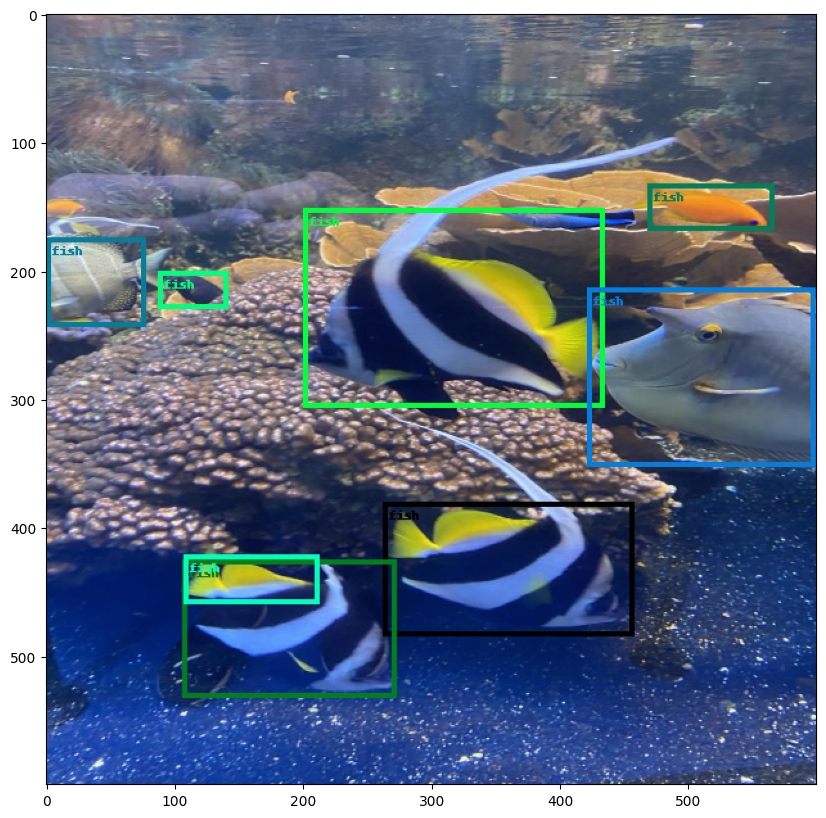

In [110]:
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int, pred['boxes'][pred['scores'] > 0.6],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.6].tolist()], width=4
).permute(1, 2, 0))